In [1]:
%config Completer.use_jedi = False
%matplotlib notebook
%matplotlib inline
from scipy.io import mmread
import numpy as np
import matplotlib.pyplot as plt
import glob
from os import listdir
from os.path import isfile, join
import pylab

from fitter import Fitter, get_common_distributions, get_distributions


starter = "matrix"+"\t"+"nr_rows"+"\t"+"nr_cols"+"\t"+"nr_nnzs"+"\t"+"density"+"\t"+"nnz-r-min"+"\t"+"nnz-r-max"+"\t"+"nnz-r-avg"+"\t"+"nnz-r-std"+"\t"+"nnz-c-min"+"\t"+"nnz-c-max"+"\t"+"nnz-c-avg"+"\t"+"nnz-c-std"+"\t"+"bw-min"+"\t"+"bw-max"+"\t"+"bw-avg"+"\t"+"bw-std"+"\t"+"sc-min"+"\t"+"sc-max"+"\t"+"sc-avg"+"\t"+"sc-std"+"\t"+"ng-min"+"\t"+"ng-max"+"\t"+"ng-avg"+"\t"+"ng-std"+"\t"+"dis-min"+"\t"+"dis-max"+"\t"+"dis-avg"+"\t"+"dis-std"+"\t"+"cl-min"+"\t"+"cl-max"+"\t"+"cl-avg"+"\t"+"cl-std"+"\n"
def retrieve_files(mypath):
    mtx_files = [mypath+f for f in listdir(mypath) if (".mtx" in join(mypath, f) and isfile(join(mypath, f)))]
    return mtx_files

---
# MATRIX FEATURE EXTRACTION
### features
- **nnz/row** : simple
- **nnz/col** : simple
- **bandwidth** : column distance between the first and last nonzero element of each row (normalized by number of columns)
- **scattering** : how nonzeros are scattered within each row (how irregular the accesses to the right hand-side vector will be)
- **ngroups** : number of groups formed by consecutive elements of each row
- **dis** : average distance between each ngroup of each row
- **clustering** : how clustered nonzero groups are within each row

In [2]:
def ngroups_and_dis_calc(row_ptr, col_ind, nnz_per_row):
    ngroups = []
    dis = []
    for i in range(len(row_ptr)-1):
        if(nnz_per_row[i]>0):
            curr_ng = 1
            prev = col_ind[row_ptr[i]]
            tmp_dis = []
            for j in range(row_ptr[i], row_ptr[i+1]):
                if(col_ind[j] > prev+1): # means we need to increase ngroups. in addition, keep in tmp_dis the new distance between the groups
                    curr_ng+=1
                    tmp_dis.append(col_ind[j]-prev)
                prev = col_ind[j]
            ngroups.append(curr_ng)
            dis.append(sum(tmp_dis)/len(tmp_dis) if(len(tmp_dis)>0) else 0)
        else:
            ngroups.append(0)
            dis.append(0)
    ngroups = np.asarray(ngroups)
    dis = np.asarray(dis)
    return ngroups,dis

In [3]:
def mmread_fun(filename, plot_it=False):
    spm_coo = mmread(filename)
    filename = filename.split("/")[-1]

    nr_rows = spm_coo.get_shape()[0]
    nr_cols = spm_coo.get_shape()[1]
    nr_nnzs = spm_coo.getnnz()
    spm = spm_coo.tocsr()
    row_ptr = spm.indptr
    col_ind = spm.indices
    values = spm.data

    mem_footprint = round((row_ptr.nbytes + col_ind.nbytes + values.nbytes)/(1024*1024),3)
    print(filename, ":\tdimensions", spm_coo.get_shape(), "/ nnz", spm_coo.getnnz(),"/ mem footprint",mem_footprint,'MB (CSR)')

    spm_csc = spm_coo.tocsc()
    col_ptr = spm_csc.indptr
    
    # simple, just keep #nnzs of each row and each column separately
    nnz_per_row = np.ediff1d(row_ptr)    
    nnz_per_col = np.ediff1d(col_ptr)
        
    # the column distance between the first and last nonzero element of each row (normalized by number of columns)
    bandwidth   = np.asarray([(col_ind[row_ptr[i+1]-1]-col_ind[row_ptr[i]])/nr_cols if nnz_per_row[i]>0 else 0 for i in range(len(row_ptr)-1)])
    
    # how nonzeros are scattered within each row (how irregular the accesses to the right hand-side vector will be)
    scatter     = np.asarray([(nnz_per_row[i]/(col_ind[row_ptr[i+1]-1]-col_ind[row_ptr[i]])) if (nnz_per_row[i]>0 and (col_ind[row_ptr[i+1]-1]-col_ind[row_ptr[i]])>0) else 0 for i in range(len(row_ptr)-1)])

    # ngroups : number of groups formed by consecutive elements of each row
    # dis : average distance between each ngroup of each row
    ngroups,dis = ngroups_and_dis_calc(row_ptr, col_ind, nnz_per_row)

    # how clustered nonzero groups are within each row
    clustering  = np.asarray([(ngroups[i]/nnz_per_row[i]) if (nnz_per_row[i]>0) else 0 for i in range(len(ngroups))])

    if(plot_it == True):
        fig, axs = plt.subplots(5,2)
        fig.set_size_inches(15,20)
        img_filename = []

        if("sparse_" in filename):
            img_path = "/home/pmpakos/sparse_matrices/"
            img_filename = glob.glob(img_path + "/**/"+filename.replace(".mtx",".png").replace("sparse","fig"), recursive = True)
            if ("_x" in filename):
                ext = "random_matrices_x/"
            elif ("_y" in filename):
                ext = "random_matrices_y/"
            else:
                ext = "./"
        elif("00K.mtx" in filename):
            img_path = "/mnt/various/exafoam_matrices"
            img_filename = glob.glob(img_path + "/**/"+filename.replace(".mtx",".png"), recursive = True)
            ext = "exafoam_matrices/"
        else:
            # img_path = "/home/pmpakos/without_and_with_rcm"
            # img_filename = glob.glob(img_path + "/**/"+filename.replace(".mtx",".png"), recursive = True)
            img_filename = ["/mnt/various/SpMV-Research/validation_matrices/images/" + filename.split(".")[0]+".png"]
        ext = "./"
        if(len(img_filename)>0): # only if png file is found, else show nothing in image plot
            im = plt.imread(img_filename[0])

            axs[0,0].imshow(im)
            axs[0,0].set_title(filename)
            axs[0,0].set_axis_off()

        axs[1,0].plot(nnz_per_row)
        axs[1,0].set_title("nnz_per_row")

        axs[1,1].plot(nnz_per_col)
        axs[1,1].set_title("nnz_per_col")

        axs[2,0].plot(bandwidth)
        axs[2,0].set_title("bandwidth")

        axs[2,1].plot(scatter)
        axs[2,1].set_title("scatter")

        axs[3,0].plot(ngroups)
        axs[3,0].set_title("ngroups")

        axs[3,1].plot(dis)
        axs[3,1].set_title("dis")

        axs[4,0].plot(clustering)
        axs[4,0].set_title("clustering")
        
        plt.tight_layout()
        plt.savefig("/mnt/various/SpMV-Research/validation_matrices/features/"+filename.replace(".mtx","_features.jpg"),transparent=False, dpi=150)
        plt.pause(0.05)
    
    return spm, nnz_per_row, nnz_per_col, bandwidth, scatter, ngroups, dis, clustering

In [4]:
def return_stats(filename, spm,nnz_per_row, nnz_per_col, bandwidth, scatter, ngroups, dis, clustering):
    filename = filename.split("/")[-1]
    nr_rows = spm.get_shape()[0]
    nr_cols = spm.get_shape()[1]
    nr_nnzs = spm.getnnz()
    density = nr_nnzs / (nr_rows*nr_cols) * 100
    
    min_nnz_per_row = np.min(nnz_per_row)
    max_nnz_per_row = np.max(nnz_per_row)
    avg_nnz_per_row = np.mean(nnz_per_row)
    std_nnz_per_row = np.std(nnz_per_row)

    min_nnz_per_col = np.min(nnz_per_col)
    max_nnz_per_col = np.max(nnz_per_col)
    avg_nnz_per_col = np.mean(nnz_per_col)
    std_nnz_per_col = np.std(nnz_per_col)
    
    min_bandwidth = np.min(bandwidth)
    max_bandwidth = np.max(bandwidth)
    avg_bandwidth = np.mean(bandwidth)
    std_bandwidth = np.std(bandwidth)
    
    min_scatter = np.min(scatter)
    max_scatter = np.max(scatter)
    avg_scatter = np.mean(scatter)
    std_scatter = np.std(scatter)
    
    min_ngroups = np.min(ngroups)
    max_ngroups = np.max(ngroups)
    avg_ngroups = np.mean(ngroups)
    std_ngroups = np.std(ngroups)
    
    min_dis = np.min(dis)
    max_dis = np.max(dis)
    avg_dis = np.mean(dis)
    std_dis = np.std(dis)
    
    min_clustering = np.min(clustering)
    max_clustering = np.max(clustering)
    avg_clustering = np.mean(clustering)
    std_clustering = np.std(clustering)

    stats = [nr_rows,nr_cols,nr_nnzs,density,min_nnz_per_row,max_nnz_per_row,avg_nnz_per_row,std_nnz_per_row,min_nnz_per_col,max_nnz_per_col,avg_nnz_per_col,std_nnz_per_col,min_bandwidth,max_bandwidth,avg_bandwidth,std_bandwidth,min_scatter,max_scatter,avg_scatter,std_scatter,min_ngroups,max_ngroups,avg_ngroups,std_ngroups,min_dis,max_dis,avg_dis,std_dis,min_clustering,max_clustering,avg_clustering,std_clustering]
    stats = "\t".join((str(x) for x in stats))
    line = filename.replace(".mtx","") + "\t" + stats
    return line
    
def stats_extraction(filename, plot_it):
#     spm, nnz_per_row, nnz_per_col, bandwidth, scatter, ngroups, dis, clustering, nnz_r_hist, bin_edges_r = mmread_fun(filename, plot_it)
    spm, nnz_per_row, nnz_per_col, bandwidth, scatter, ngroups, dis, clustering = mmread_fun(filename, plot_it)
    line = return_stats(filename, spm, nnz_per_row, nnz_per_col, bandwidth, scatter, ngroups, dis, clustering)
    
    return line #, nnz_r_hist, bin_edges_r, nnz_per_row

In [ ]:
filenames = [
    "/mnt/various/SpMV-Research/validation_matrices/cop20k_A.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/scircuit.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/mac_econ_fwd500.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/mc2depi.real.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/raefsky3.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/bbmat.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/pdb1HYS.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/conf5_4-8x8-15.real.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/cant.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/rma10.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/mip1.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/webbase-1M.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/consph.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/shipsec1.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/TSOPF_RS_b300_c3.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/crankseg_2.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/pwtk.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/rail4284.real.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/Chebyshev4.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/in-2004.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/Si41Ge41H72.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/PR02R.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/eu-2005.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/wikipedia-20051105.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/Ga41As41H72.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/TSOPF_RS_b2383.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/rajat31.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/ldoor.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/bone010.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/circuit5M.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/cage15.sorted.mtx",
]

plot_it = True

stats_list = []
plot_it = True
for filename in filenames:
    line = stats_extraction(filename, plot_it)
    stats_list.append(line)

file = open("/mnt/various/SpMV-Research/validation_matrices/features/validation_matrices_features.txt","w")
for line in stats_list:
    file.write(line+"\n")
file.close()

---
# DISTRIBUTION ESTIMATION (of nnz-row and bandwidth)

In [5]:
print(get_common_distributions())
print('---')
print(get_distributions())

['cauchy', 'chi2', 'expon', 'exponpow', 'gamma', 'lognorm', 'norm', 'powerlaw', 'rayleigh', 'uniform']
---
['alpha', 'anglit', 'arcsine', 'argus', 'beta', 'betaprime', 'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 'crystalball', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponnorm', 'exponpow', 'exponweib', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_l', 'frechet_r', 'gamma', 'gausshyper', 'genexpon', 'genextreme', 'gengamma', 'genhalflogistic', 'geninvgauss', 'genlogistic', 'gennorm', 'genpareto', 'gilbrat', 'gompertz', 'gumbel_l', 'gumbel_r', 'halfcauchy', 'halfgennorm', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kappa3', 'kappa4', 'ksone', 'kstwo', 'kstwobign', 'laplace', 'levy', 'levy_l', 'levy_stable', 'loggamma', 'logistic', 'loglaplace', 'lognorm', 'loguniform', 'lomax', 'maxwell', 'mielke', 'moyal', 'nakagami', 'ncf', 'nct', 'ncx2', 'norm', 'norminvgauss', 'pareto', 'pearson3', '

In [6]:
def summary2(f_obj, Nbest=5, lw=2, plot=True, method="sumsquare_error", clf=True):
    """Plots the distribution of the data and Nbest distribution"""
    if plot:
        if clf:
            pylab.clf()
        f_obj.hist()
        f_obj.plot_pdf(Nbest=Nbest, lw=lw, method=method)
        pylab.grid(True)
    Nbest = min(Nbest, len(f_obj.distributions))
    try:
        names = f_obj.df_errors.sort_values(by=method).index[0:Nbest]
    except:  # pragma: no cover
        names = f_obj.df_errors.sort(method).index[0:Nbest]
    return f_obj.df_errors.loc[names]

def plot_histogram(vector, name):
    threshold = 250
    if((max(vector)-min(vector)) > threshold):
        step = (max(vector)+2 - min(vector))//threshold
        bins_range = range(min(vector), max(vector)+2,step)
        print("GOOD", len(list(bins_range)))
    else:
        bins_range = range(min(vector), max(vector)+2,1)
        print("BADD", len(list(bins_range)))

    vector_hist, bin_edges_r = np.histogram(vector, bins=bins_range)
    print(name,": min =",min(vector), "max =",max(vector), "nr_bins =",len(list(bins_range)))
    
    # plot histogram of nonzeros per row separately
    fig,ax = plt.subplots(1,1)
    fig.set_size_inches(20,12)
    ax.hist(vector, bins=bins_range)
    ax.set_title(filename + "       " + name + " histogram")
    ax.set_xlabel(name)
    ax.set_ylabel("occurences")
    # Make some labels.
    rects = ax.patches
    labels = [str(vector_hist[i]) if vector_hist[i]>0 else "" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,ha='center', va='bottom')        
    plt.tight_layout()
    plt.savefig("../../validation_matrices/images/distribution_estimation/"+filename.split("/")[-1].replace(".mtx","_histogram_"+name+".jpg"),transparent=False, dpi=150)
    plt.pause(0.05)

    fig,ax = plt.subplots(1,1)
    fig.set_size_inches(20,12)
    f = Fitter(vector, timeout=45,
               distributions=["gamma", "beta", "cauchy", "chi2", "exponpow", "lognorm", "powerlaw", "rayleigh",
                              "burr","norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"])
    f.fit()
    # f.summary(Nbest=10)
    summary2(f, Nbest=10)

    plt.savefig("../../validation_matrices/images/distribution_estimation/"+filename.split("/")[-1].replace(".mtx","_histogram_distr_"+name+".jpg"),transparent=False, dpi=150)
    plt.pause(0.05)
    print(f.get_best(method = 'sumsquare_error'))
    return vector_hist, bin_edges_r

def mmread_fun2(filename, plot_it=False):
    spm_coo = mmread(filename)
    filename = filename.split("/")[-1]

    nr_rows = spm_coo.get_shape()[0]
    nr_cols = spm_coo.get_shape()[1]
    nr_nnzs = spm_coo.getnnz()
    spm = spm_coo.tocsr()
    row_ptr = spm.indptr
    col_ind = spm.indices
    values = spm.data

    mem_footprint = round((row_ptr.nbytes + col_ind.nbytes + values.nbytes)/(1024*1024),3)
    print(filename, ":\tdimensions", spm_coo.get_shape(), "/ nnz", spm_coo.getnnz(),"/ mem footprint",mem_footprint,'MB (CSR)')

    nnz_per_row = np.ediff1d(row_ptr)
    print("nnz_per_row ready")
    bandwidth2  = np.asarray([(col_ind[row_ptr[i+1]-1]-col_ind[row_ptr[i]]) if nnz_per_row[i]>0 else 0 for i in range(len(row_ptr)-1)])
    print("bandwidth2  ready")

    nnzr_hist, nnzr_bin_edges_r = plot_histogram(nnz_per_row, "nnz-row")
    bw_hist,   bw_bin_edges_r   = plot_histogram(bandwidth2,  "bandwidth")
    
    return nnzr_hist, nnzr_bin_edges_r, bw_hist, bw_bin_edges_r

------
cop20k_A.sorted.mtx :	dimensions (121192, 121192) / nnz 2624331 / mem footprint 30.495 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 83
nnz-row : min = 0 max = 81 nr_bins = 83


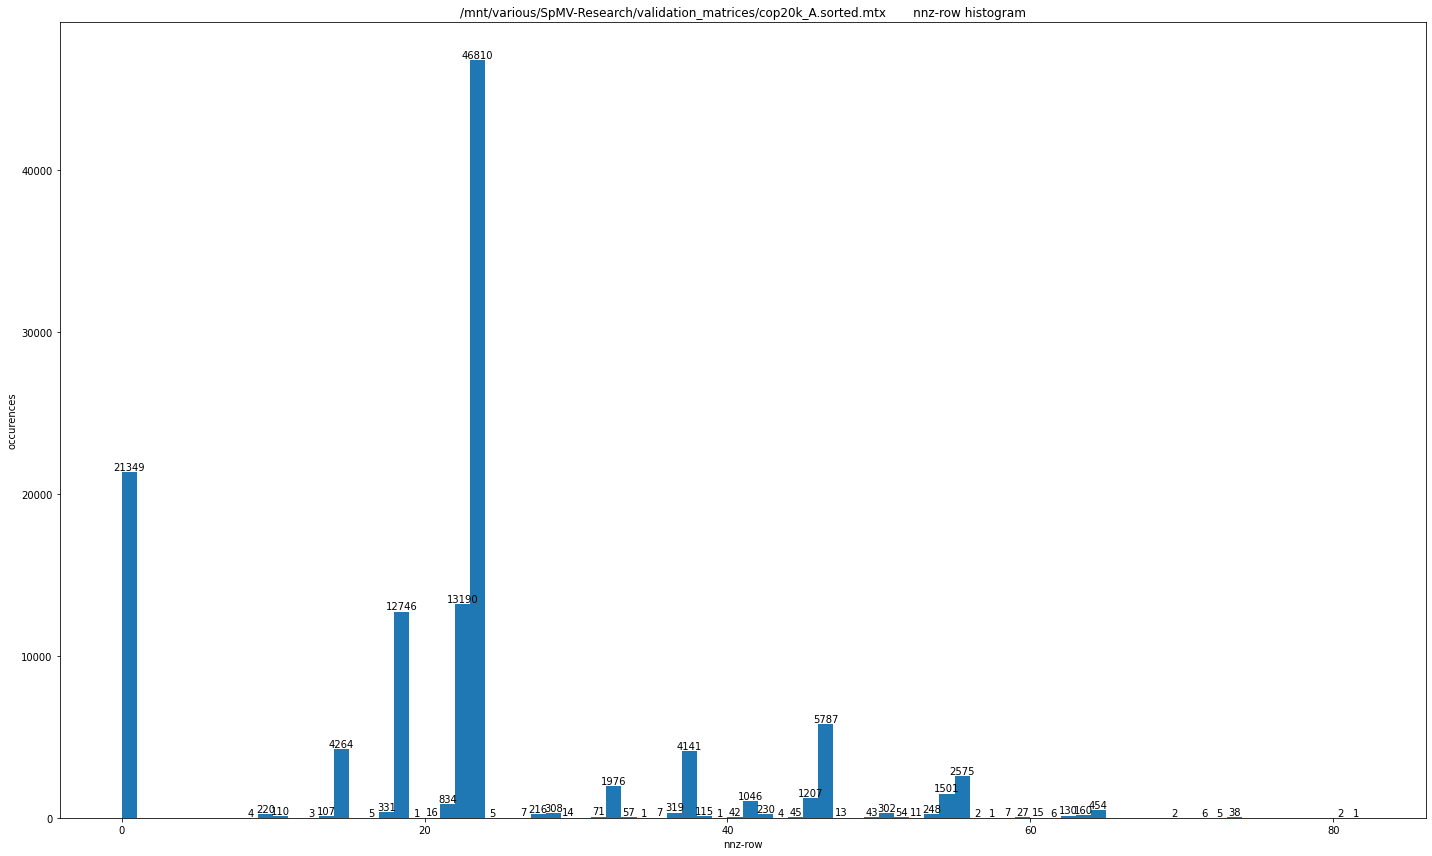

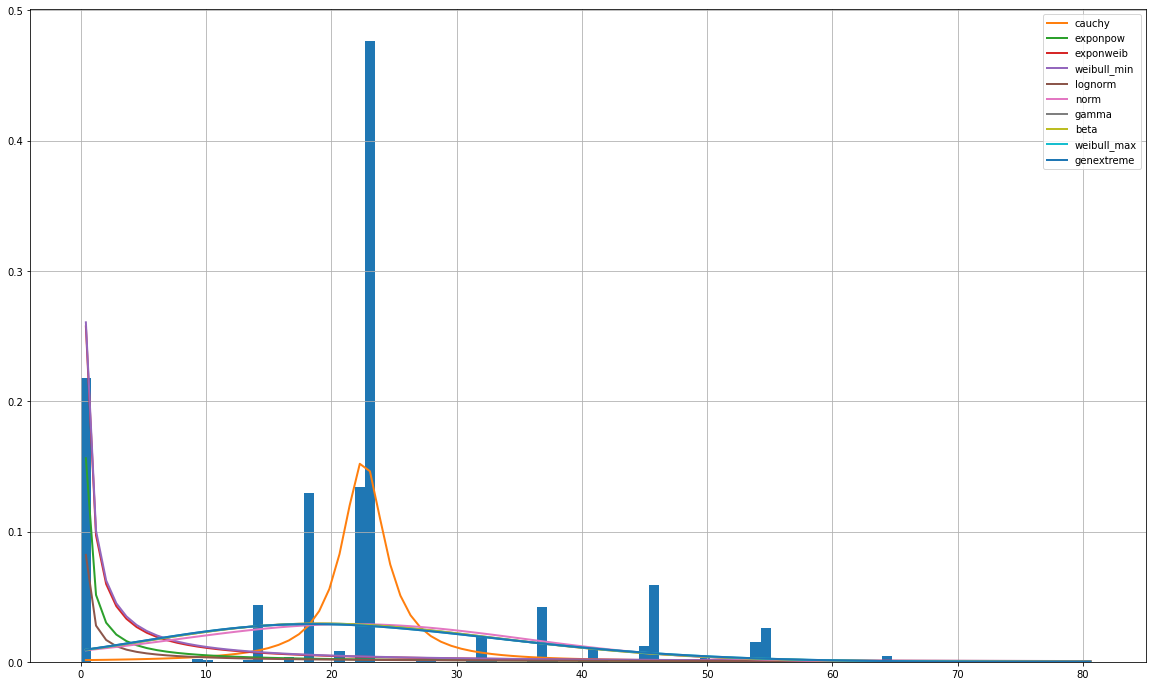

{'cauchy': {'loc': 22.575843802721586, 'scale': 2.0501605772807543}}
GOOD 251
bandwidth : min = 0 max = 121052 nr_bins = 251


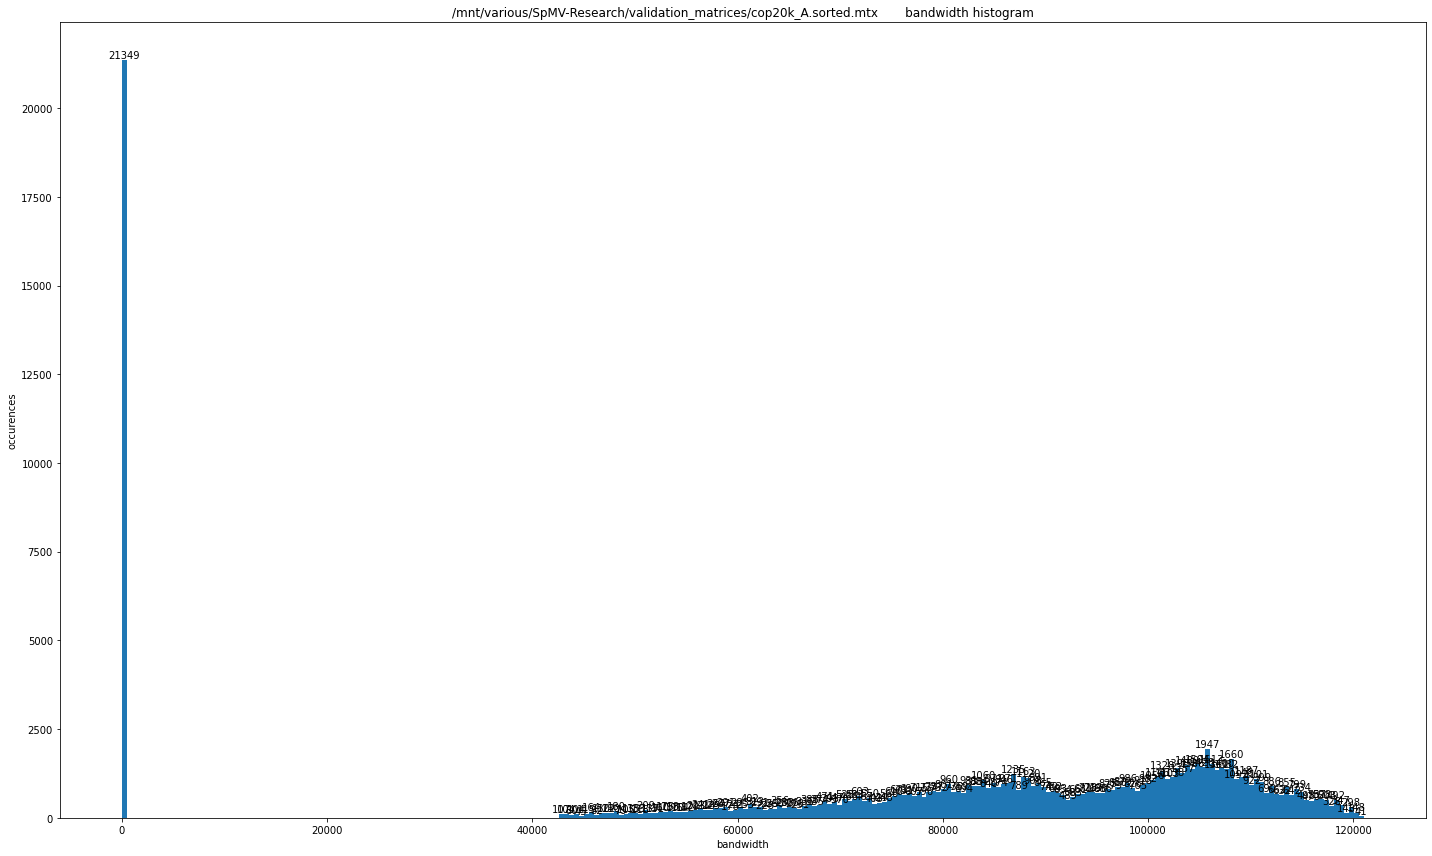

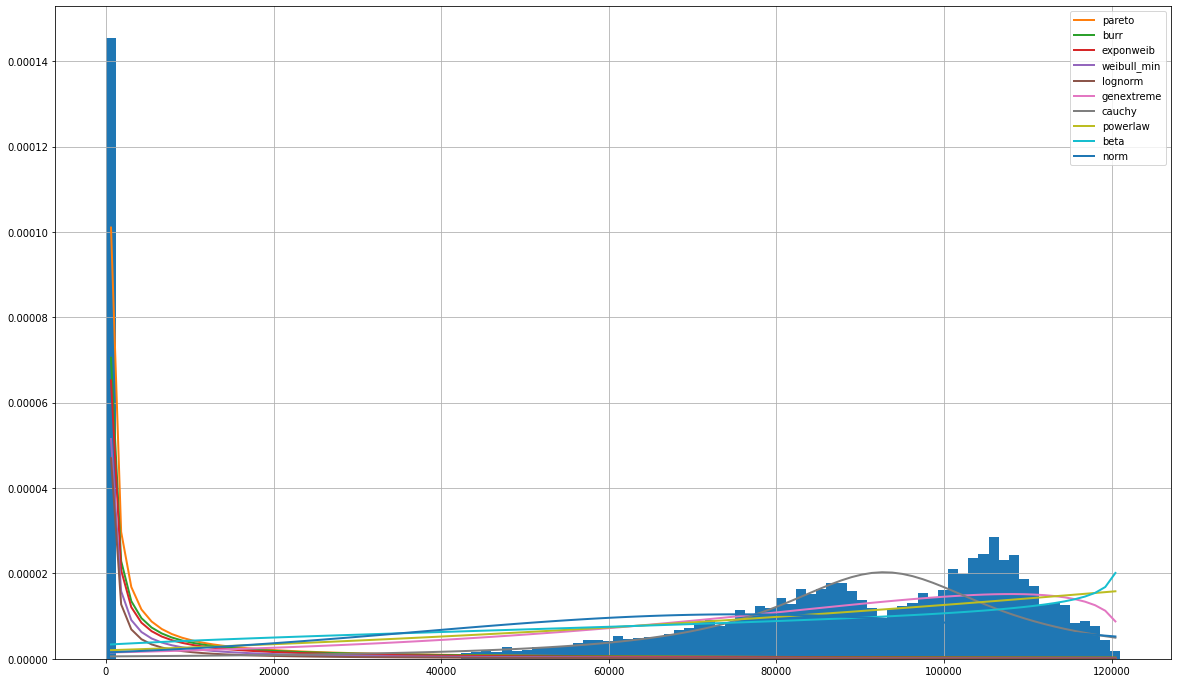

{'pareto': {'b': 0.1160126406341278, 'loc': -2.520771984589822, 'scale': 2.5207719824517447}}
------
scircuit.sorted.mtx :	dimensions (170998, 170998) / nnz 958936 / mem footprint 11.626 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 354
nnz-row : min = 1 max = 353 nr_bins = 354


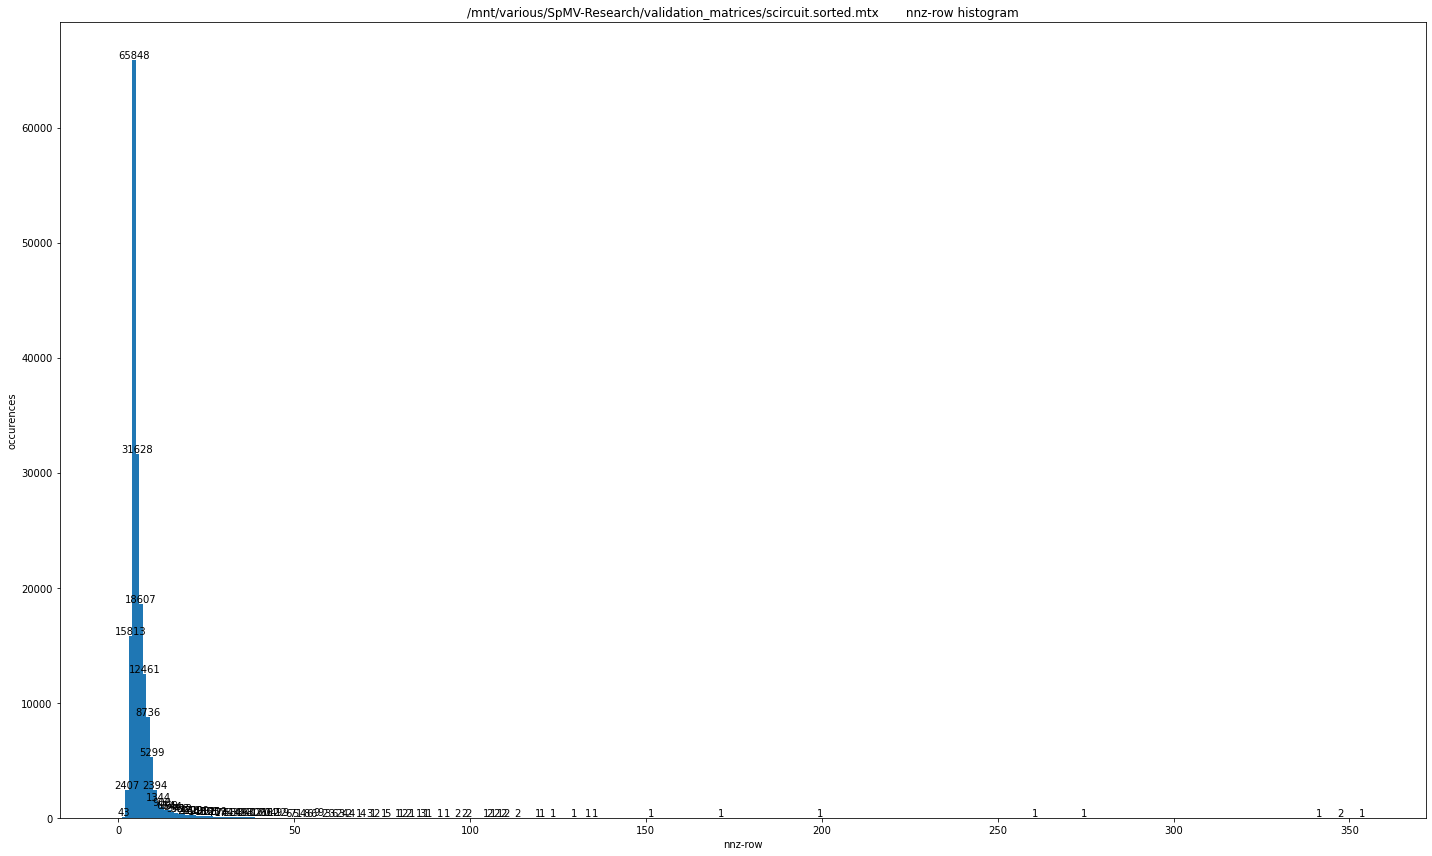

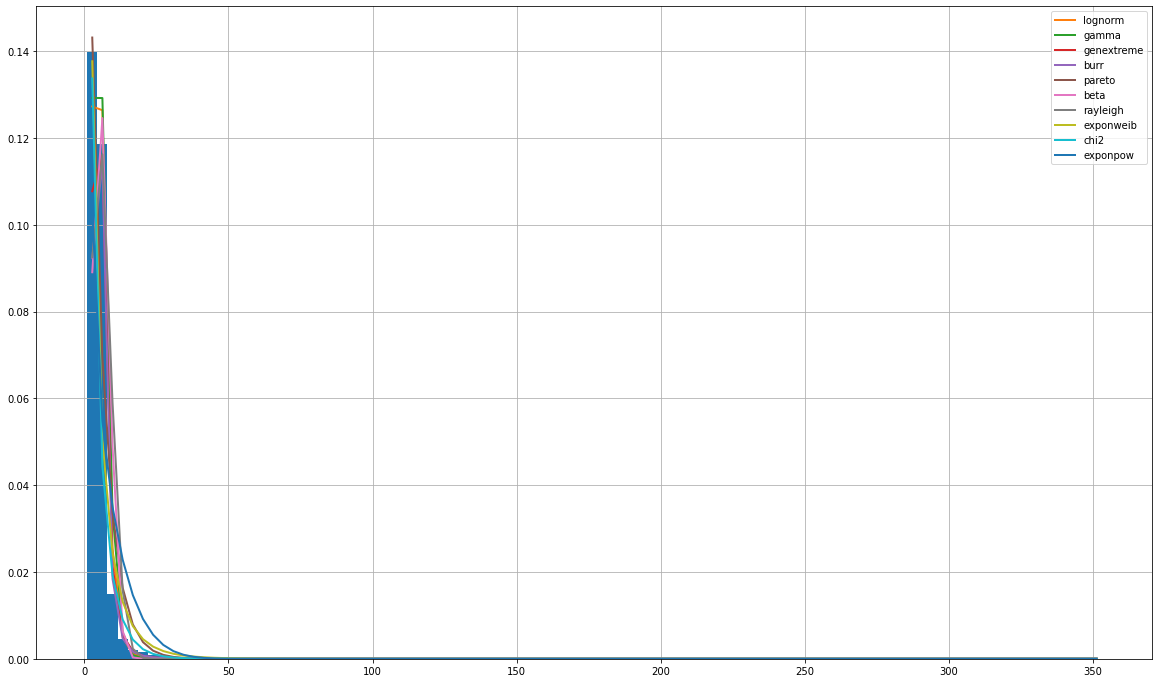

{'lognorm': {'s': 0.49779578119588275, 'loc': 0.9201994374752103, 'scale': 4.0168897188889865}}
GOOD 251
bandwidth : min = 0 max = 170975 nr_bins = 251


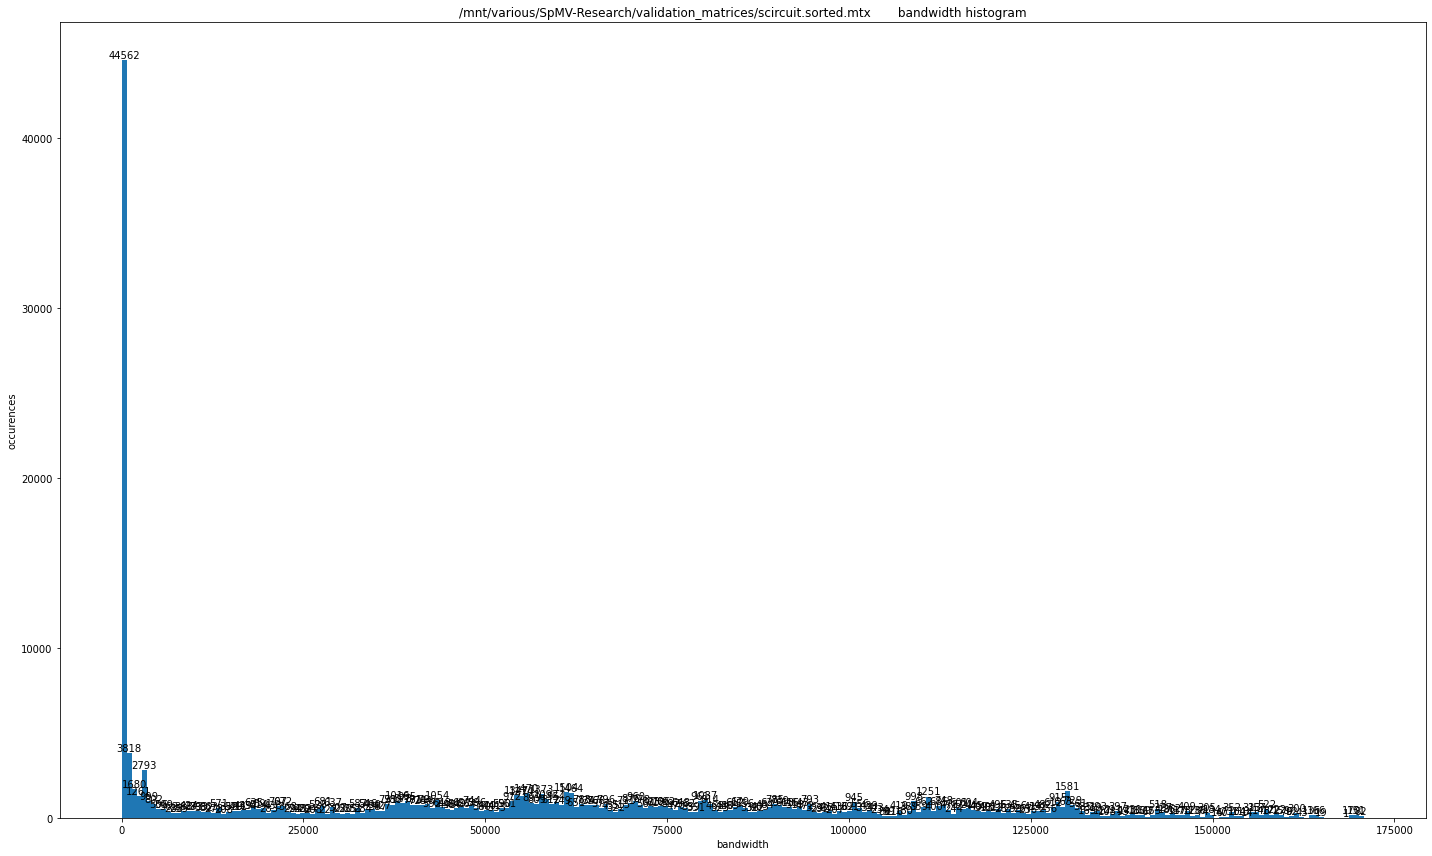

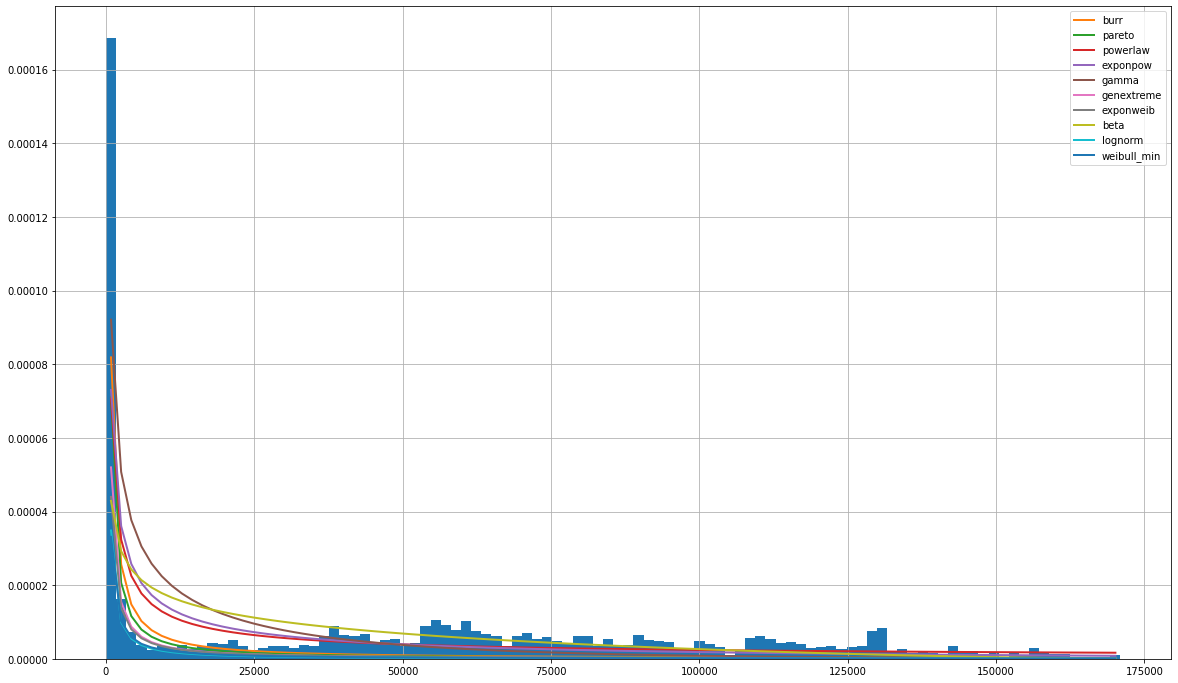

{'burr': {'c': 0.22658599867306384, 'd': 2.9269849310720177, 'loc': -6.588450662597007e-25, 'scale': 2.592528364664335}}
------
mac_econ_fwd500.sorted.mtx :	dimensions (206500, 206500) / nnz 1273389 / mem footprint 15.361 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 45
nnz-row : min = 1 max = 44 nr_bins = 45


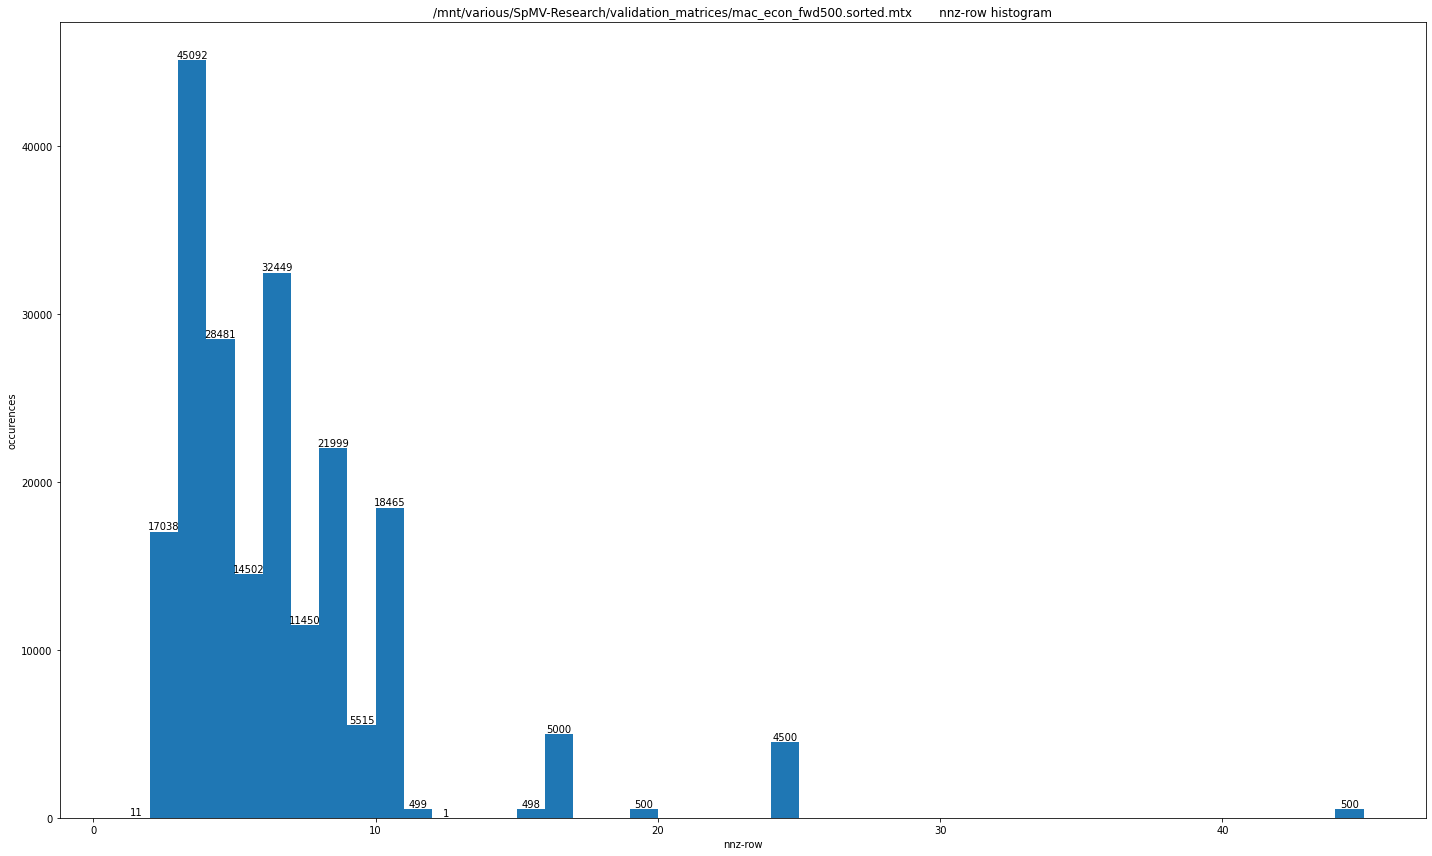

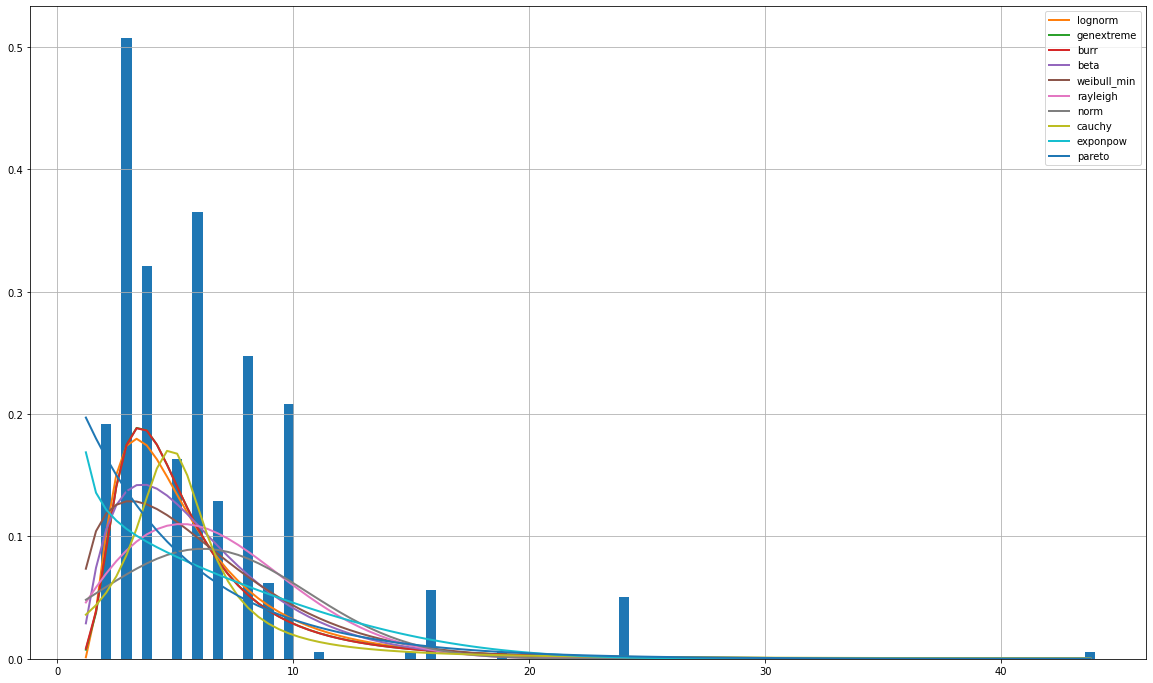

{'lognorm': {'s': 0.7237707925347006, 'loc': 0.9749526929904465, 'scale': 3.9817037768372865}}
GOOD 262
bandwidth : min = 0 max = 2090 nr_bins = 262


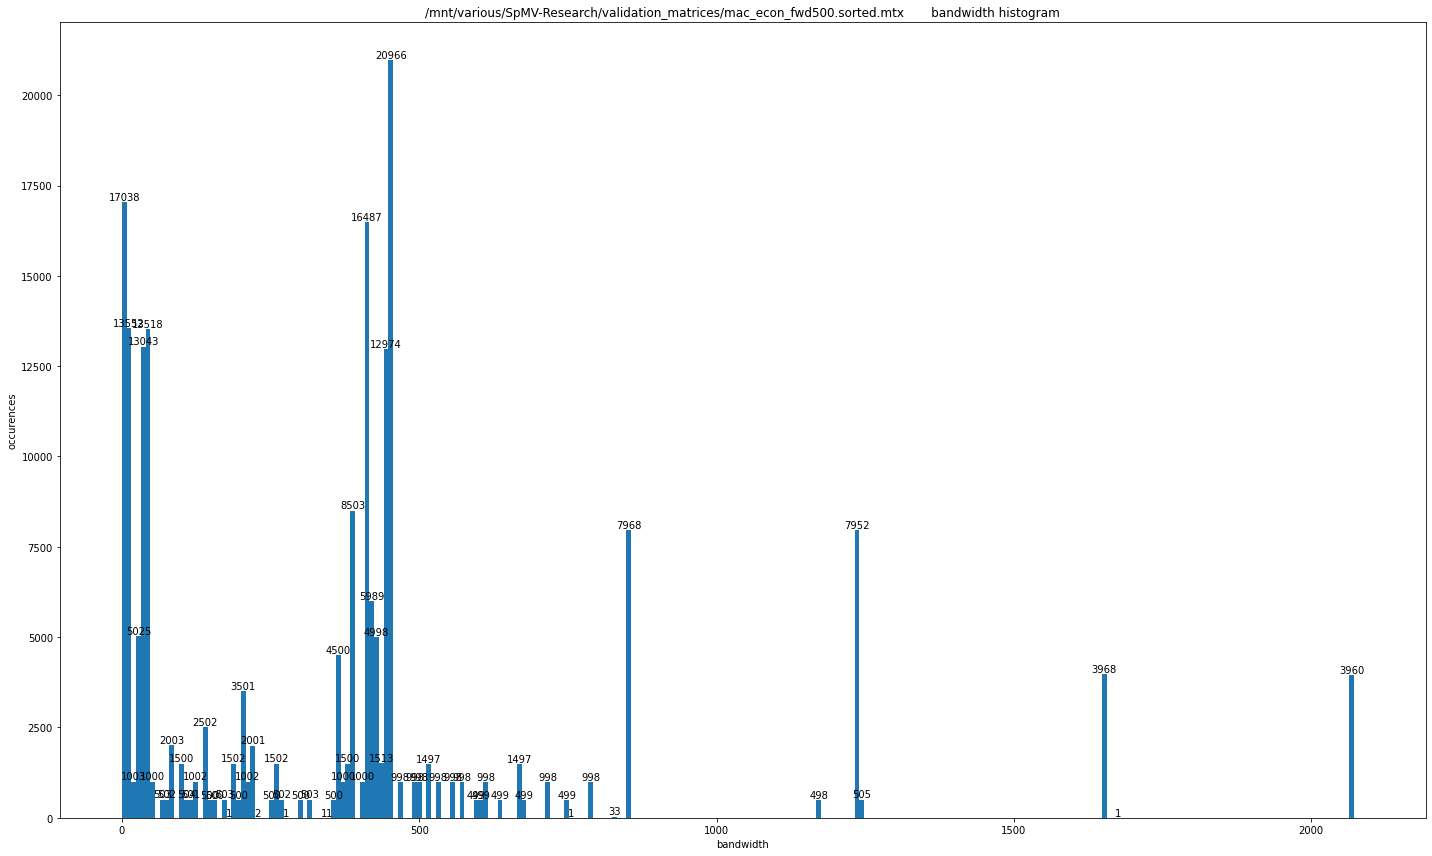

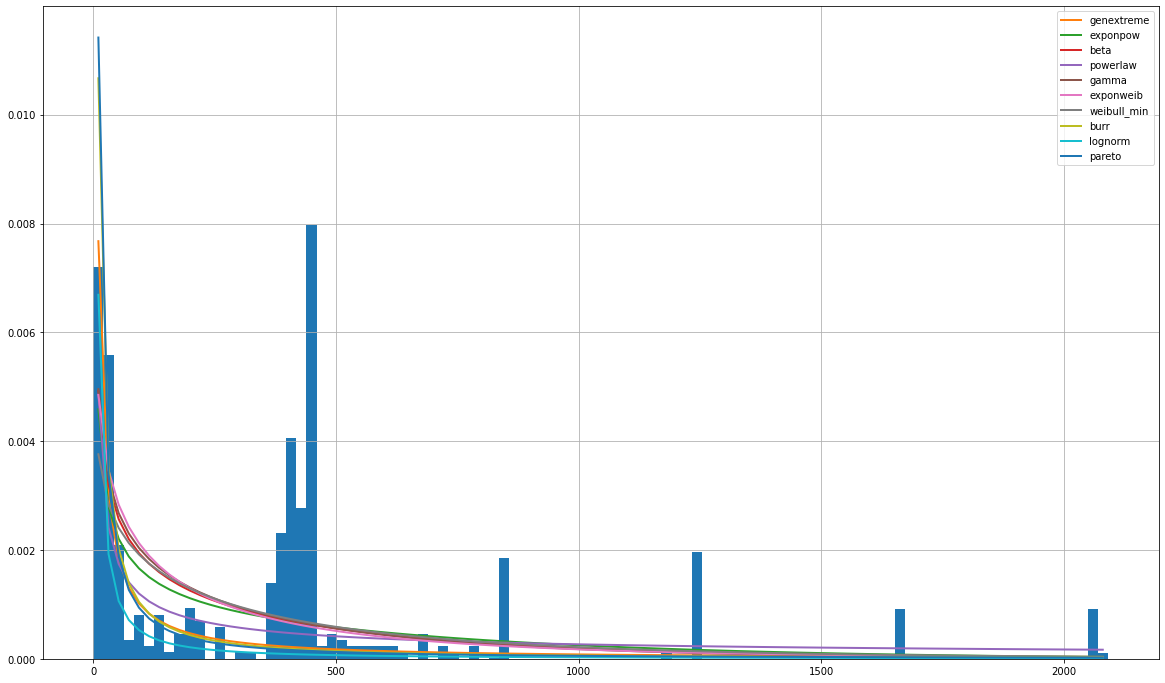

{'genextreme': {'c': -3.842379395776817, 'loc': 82.83464203704091, 'scale': 318.36566289186806}}
------
mc2depi.real.mtx :	dimensions (525825, 525825) / nnz 2100225 / mem footprint 26.041 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 4
nnz-row : min = 2 max = 4 nr_bins = 4


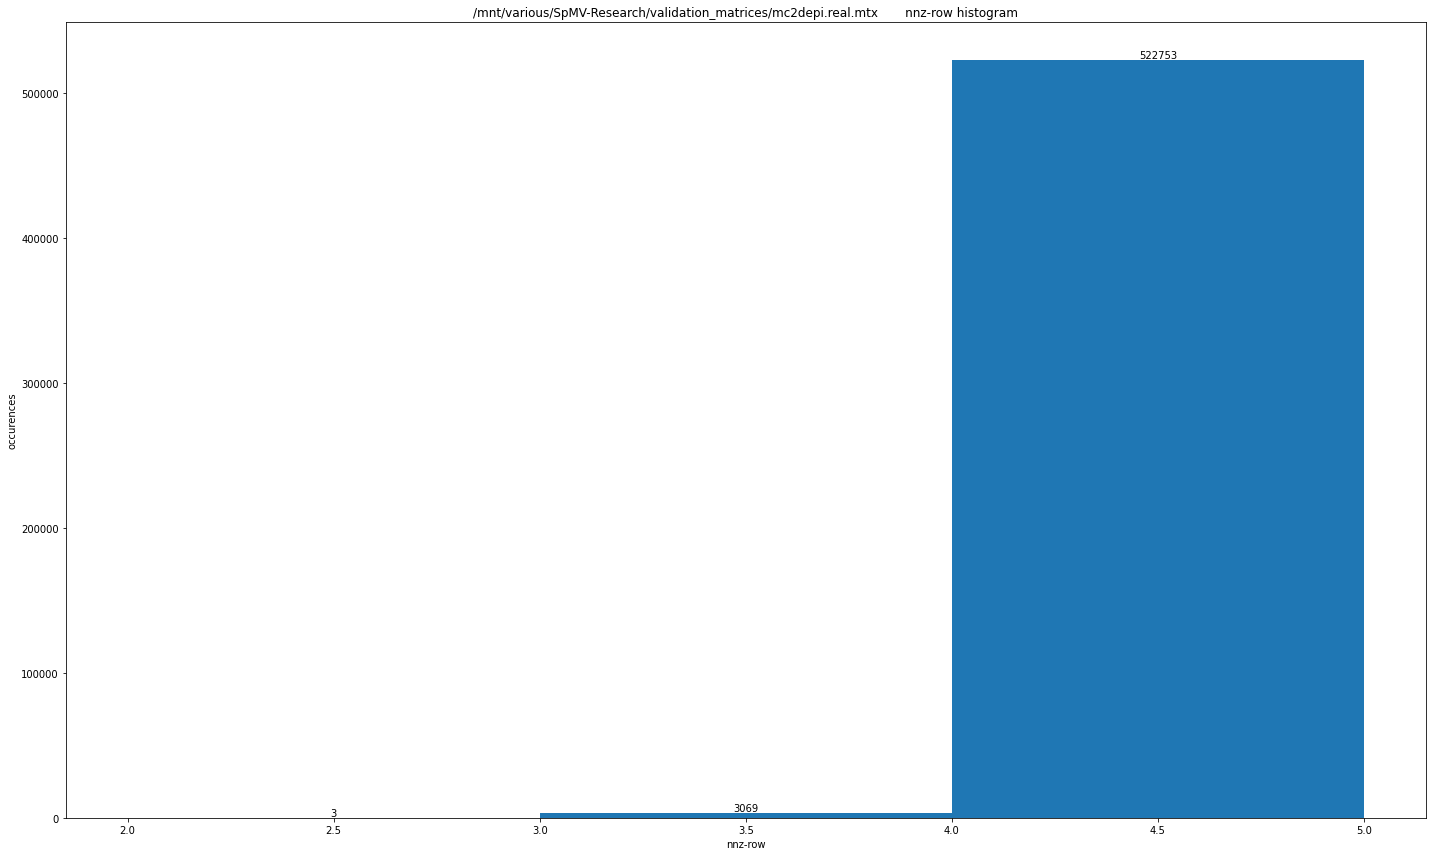

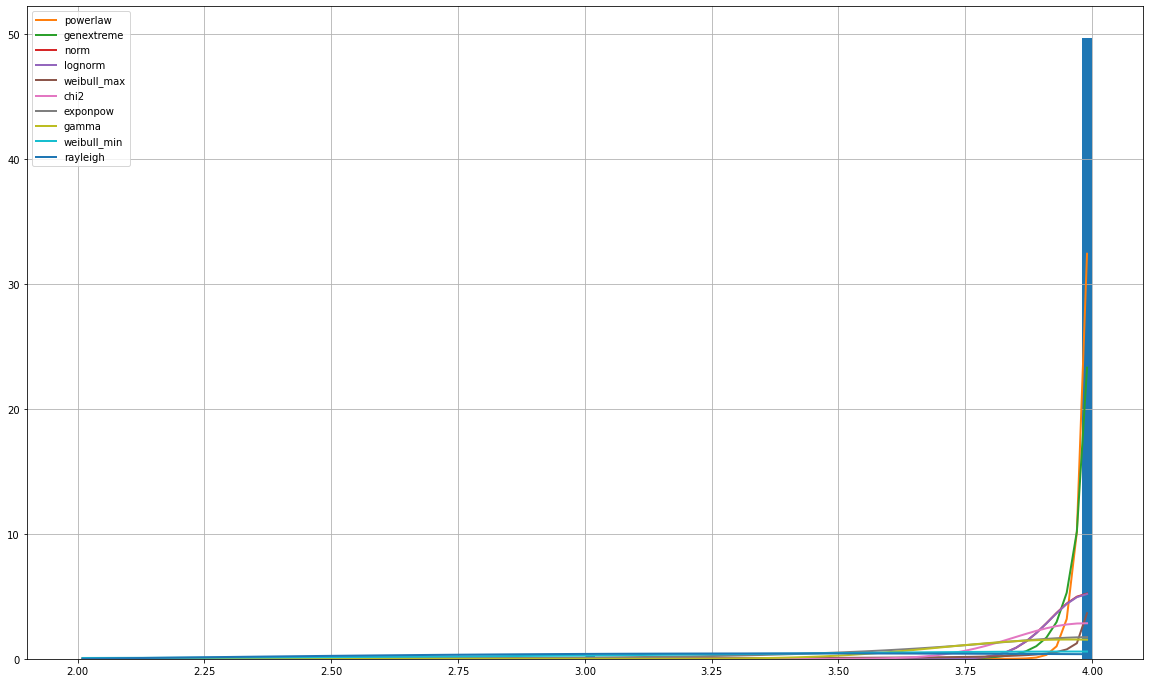

{'powerlaw': {'a': 13077.486561038622, 'loc': -221.5931820561622, 'scale': 225.5932131733303}}
GOOD 257
bandwidth : min = 1 max = 770 nr_bins = 257


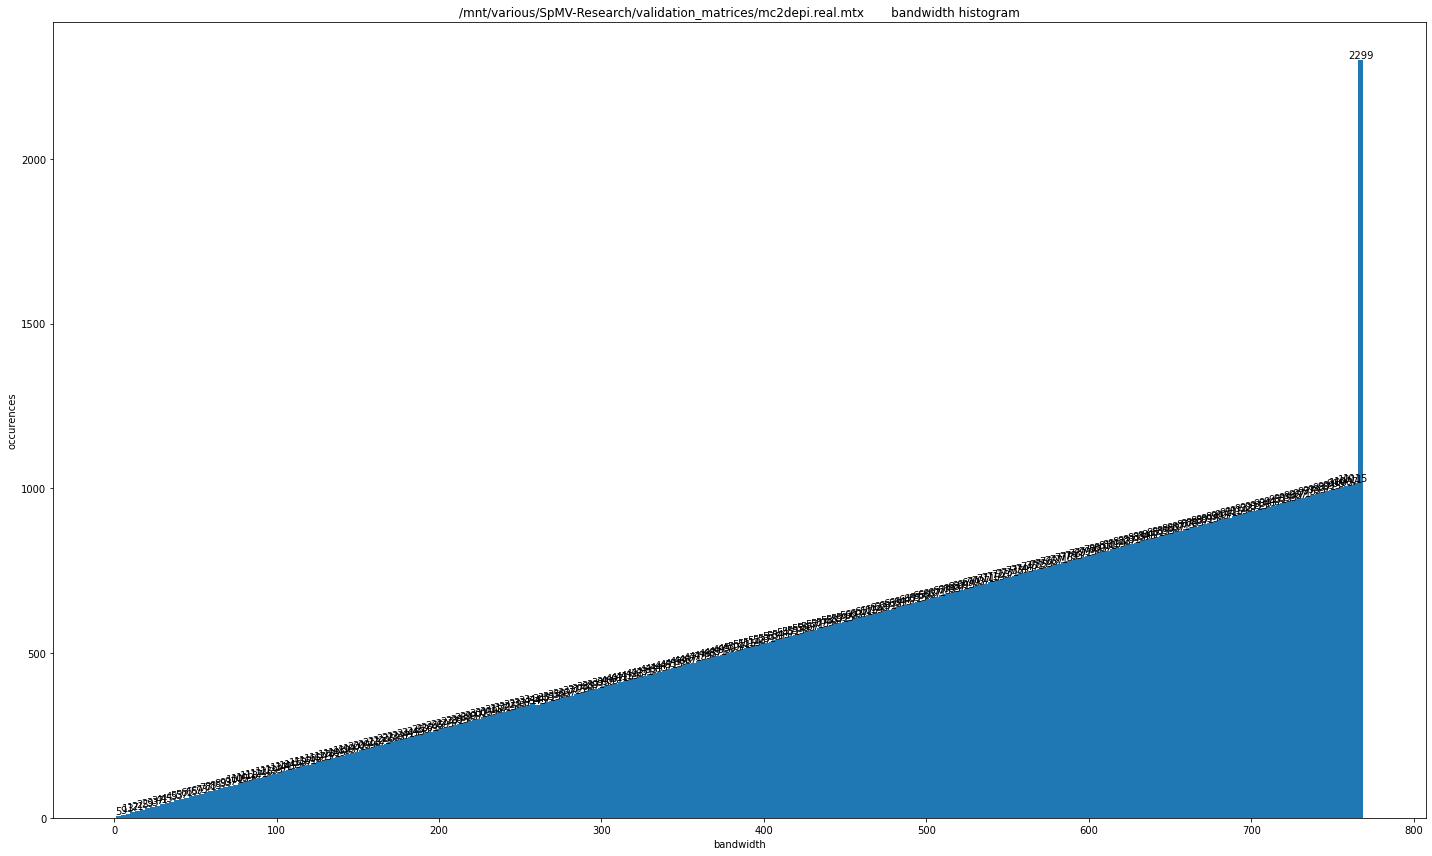

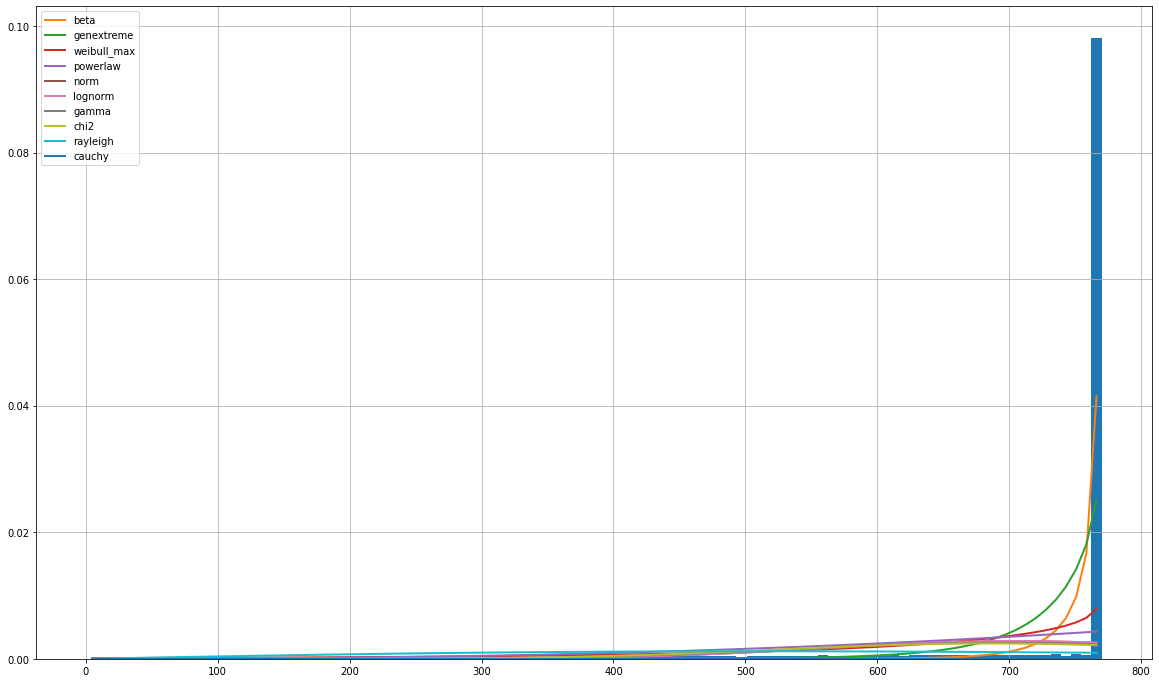

{'beta': {'a': 147.02453299442567, 'b': 0.35418797900581744, 'loc': -4827.688157907108, 'scale': 5597.688157907109}}
------
raefsky3.sorted.mtx :	dimensions (21200, 21200) / nnz 1488768 / mem footprint 17.118 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 50
nnz-row : min = 32 max = 80 nr_bins = 50


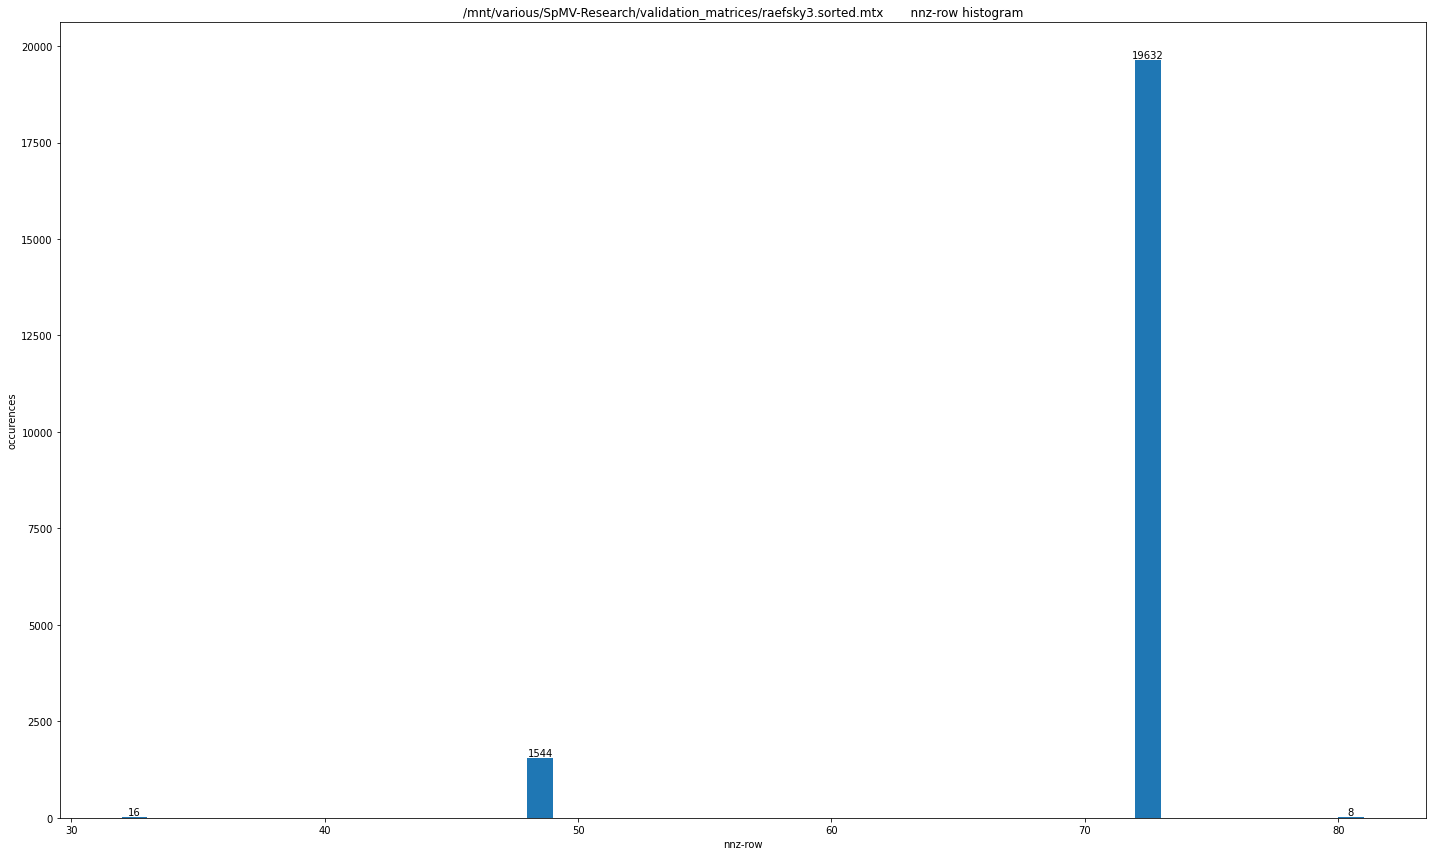

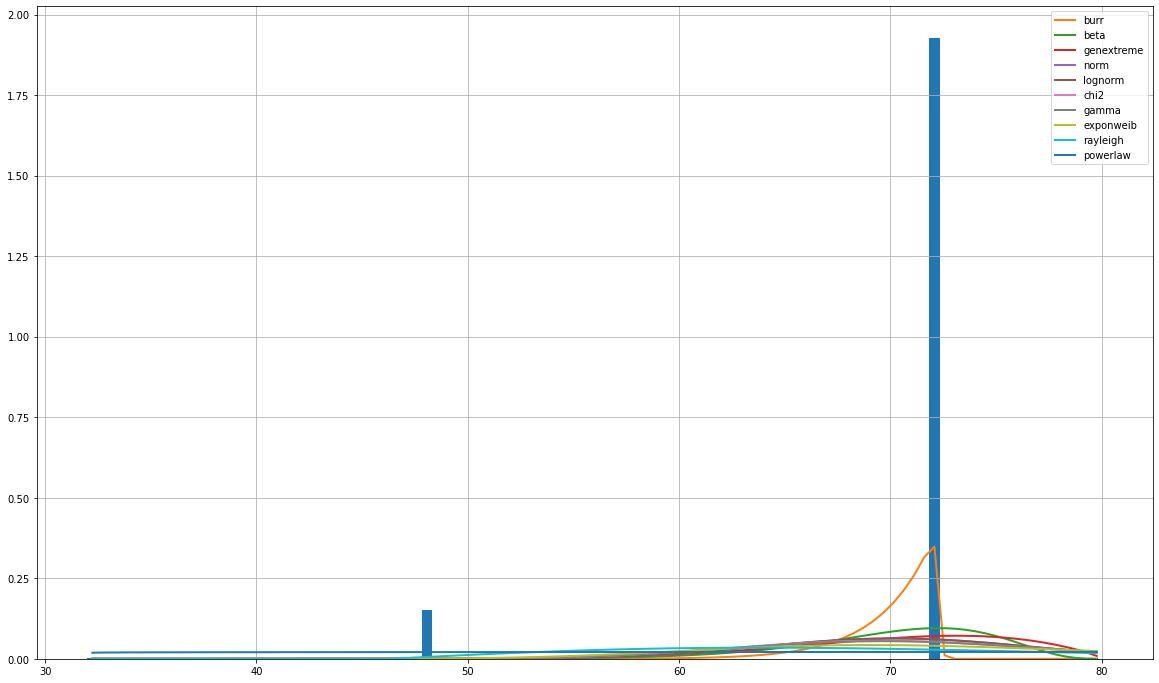

{'burr': {'c': 945.7515624536733, 'd': 0.03332571141396756, 'loc': -4.016695242704621, 'scale': 76.28513990094415}}
GOOD 281
bandwidth : min = 575 max = 1975 nr_bins = 281


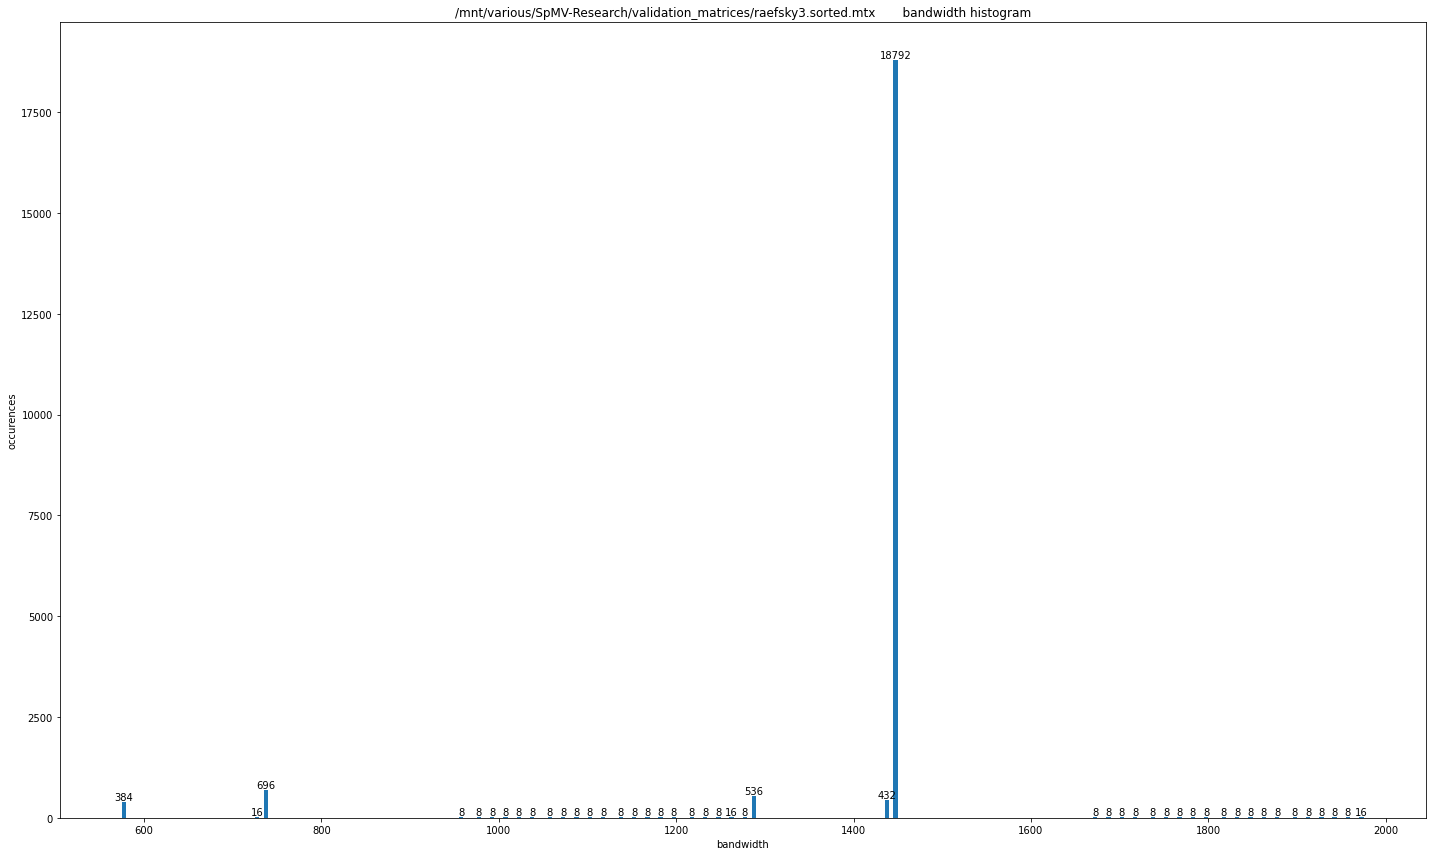

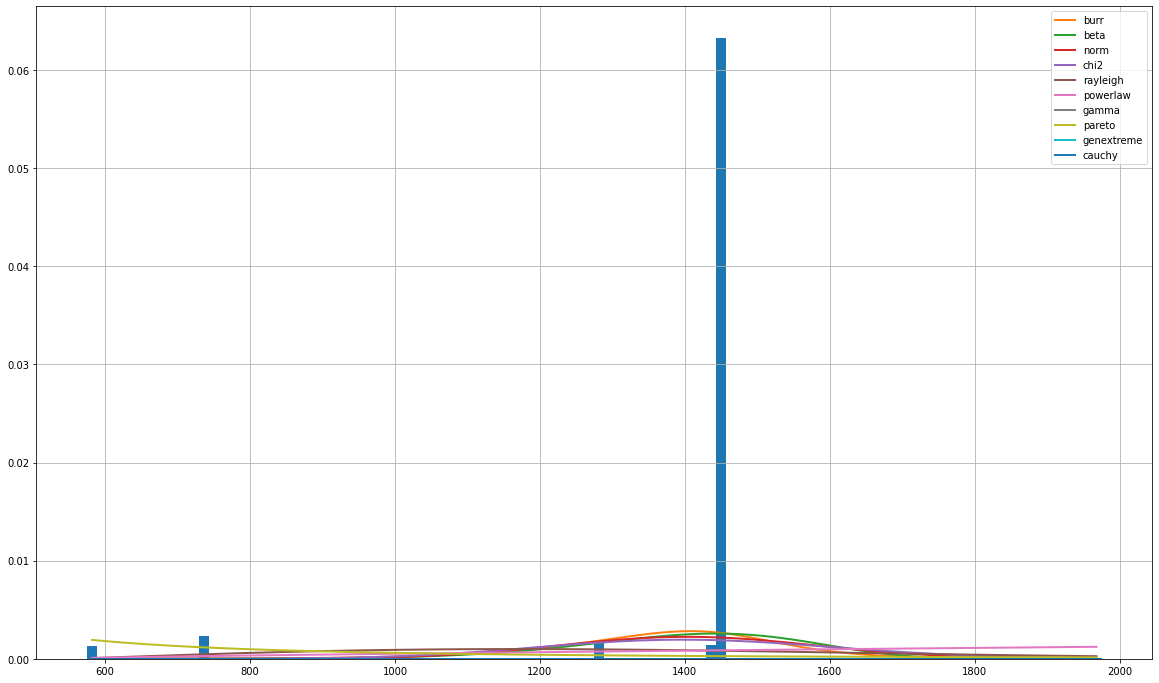

{'burr': {'c': 22.087714834350017, 'd': 0.43737481409741186, 'loc': -3.2262845001031035, 'scale': 1475.3845036064777}}
------
bbmat.sorted.mtx :	dimensions (38744, 38744) / nnz 1771722 / mem footprint 20.424 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 122
nnz-row : min = 6 max = 126 nr_bins = 122


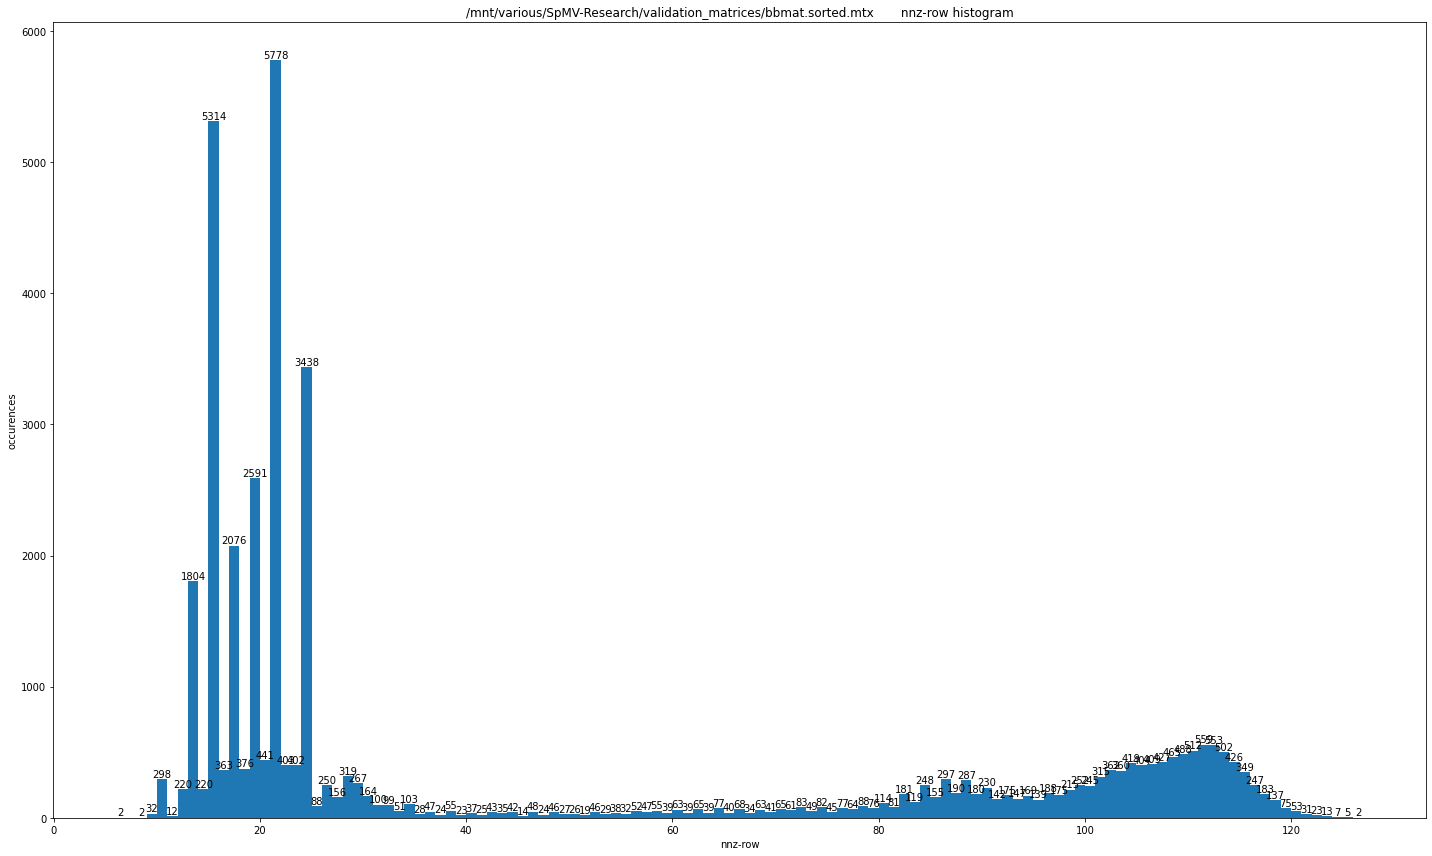

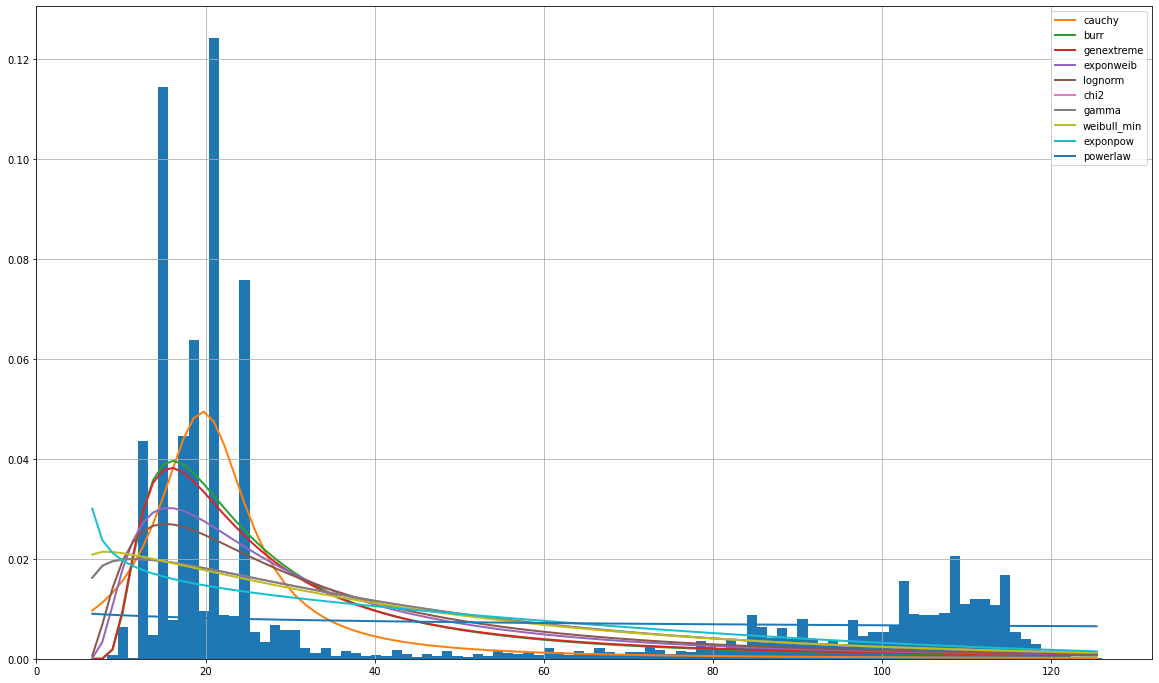

{'cauchy': {'loc': 19.661764700241882, 'scale': 6.435484914097718}}
GOOD 251
bandwidth : min = 233 max = 38524 nr_bins = 251


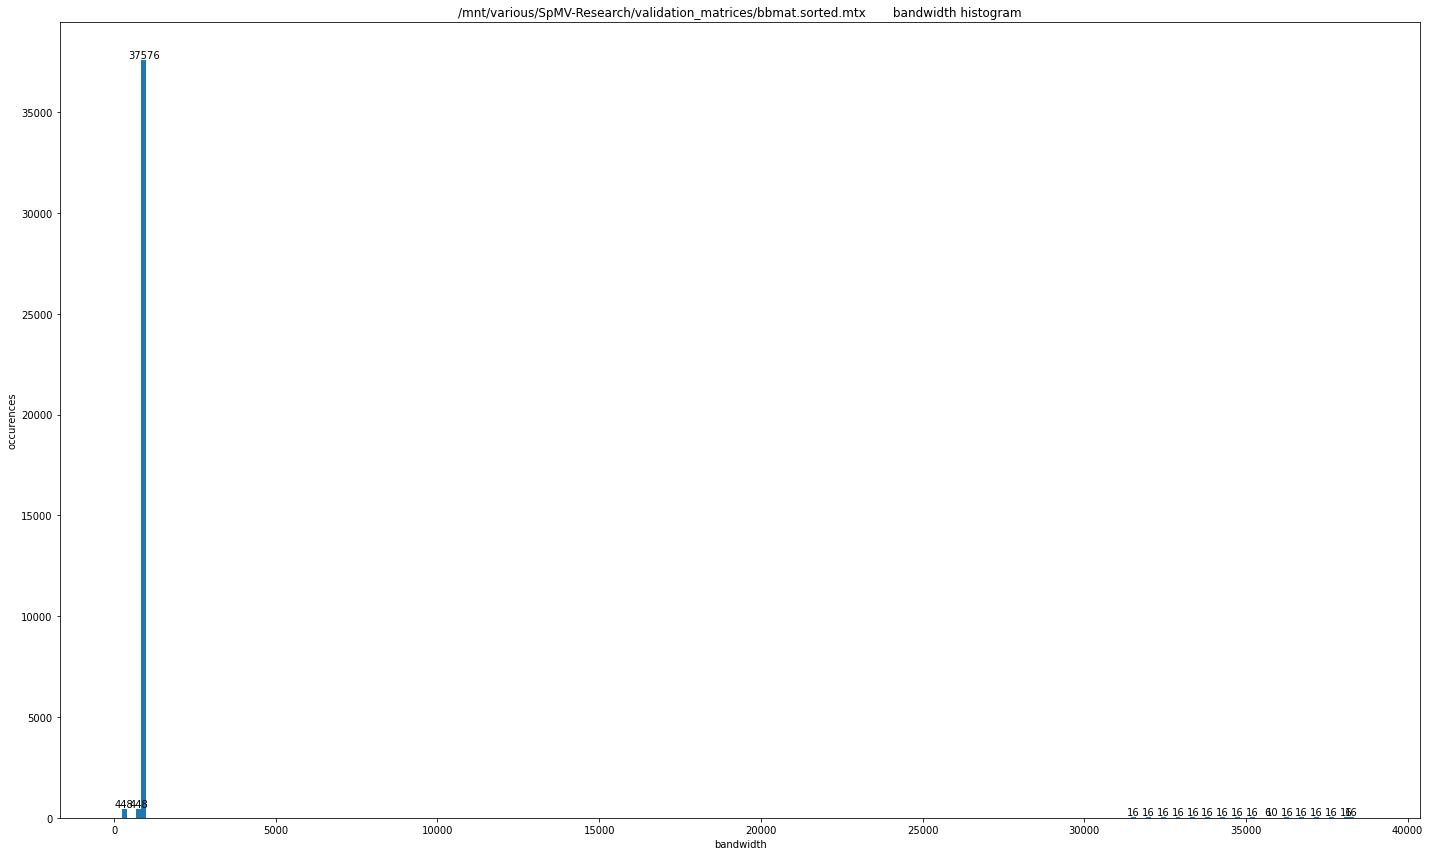

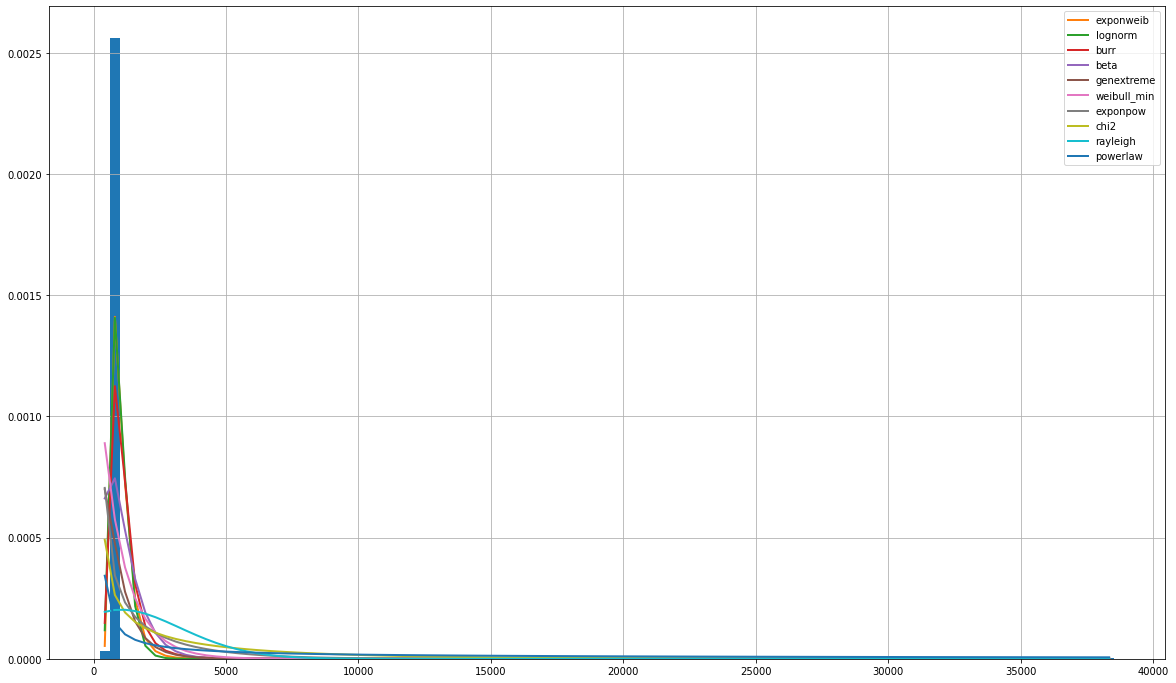

{'exponweib': {'a': 10692.10573971533, 'c': 0.4262392954832757, 'loc': -191.28547056275227, 'scale': 5.596237214052786}}
------
pdb1HYS.sorted.mtx :	dimensions (36417, 36417) / nnz 4344765 / mem footprint 49.861 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 188
nnz-row : min = 18 max = 204 nr_bins = 188


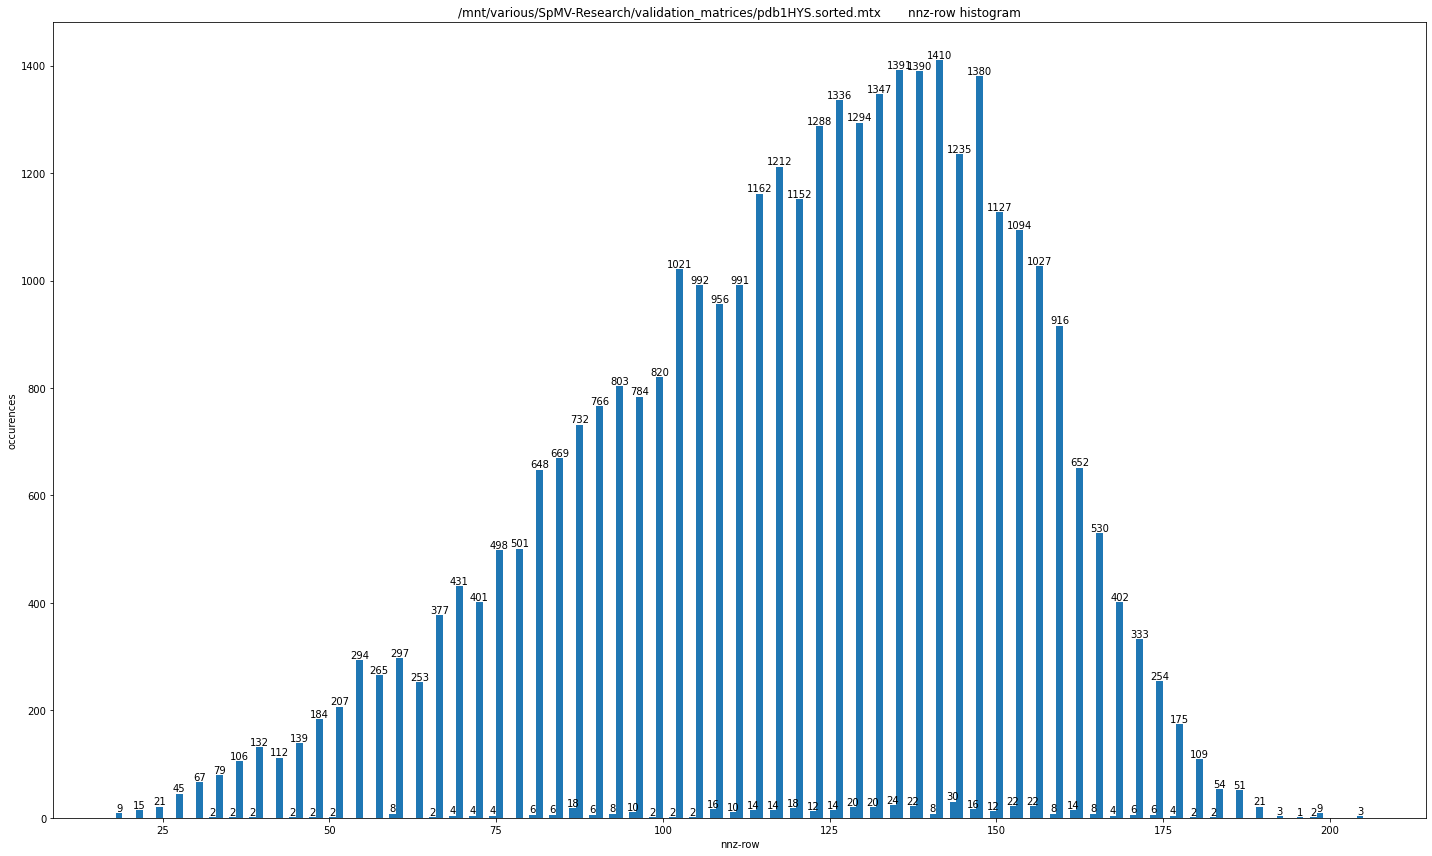

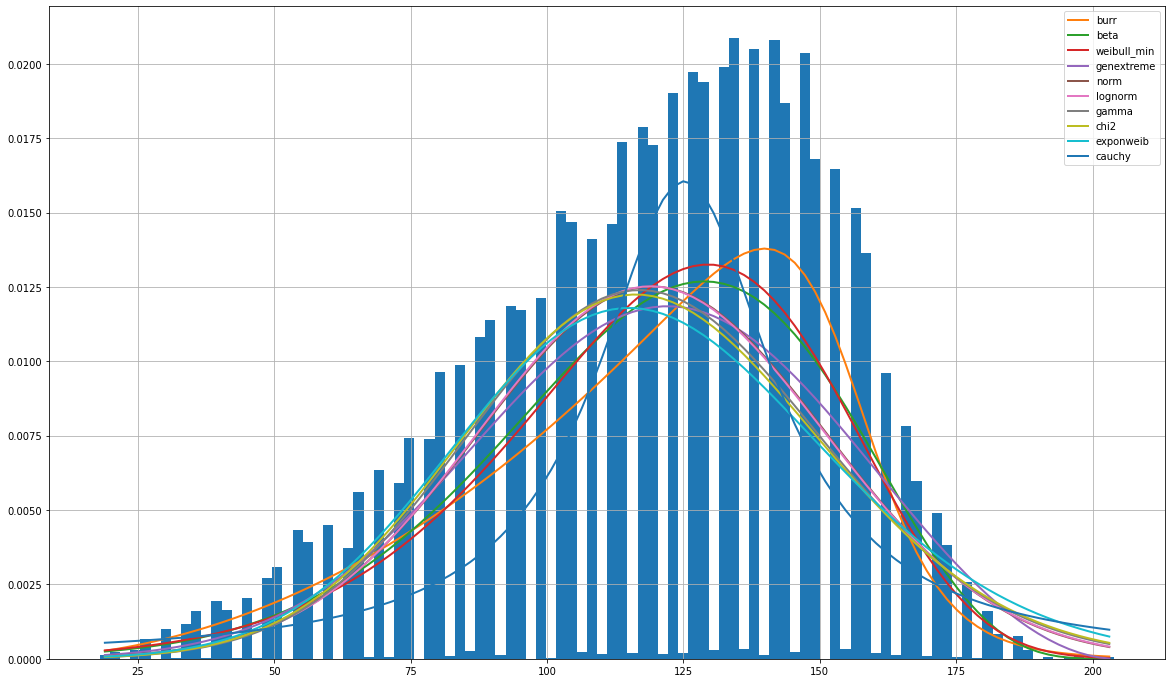

{'burr': {'c': 20.544131359766553, 'd': 0.14858129891985267, 'loc': -0.6446288456225413, 'scale': 157.59701616180791}}
GOOD 252
bandwidth : min = 23 max = 34475 nr_bins = 252


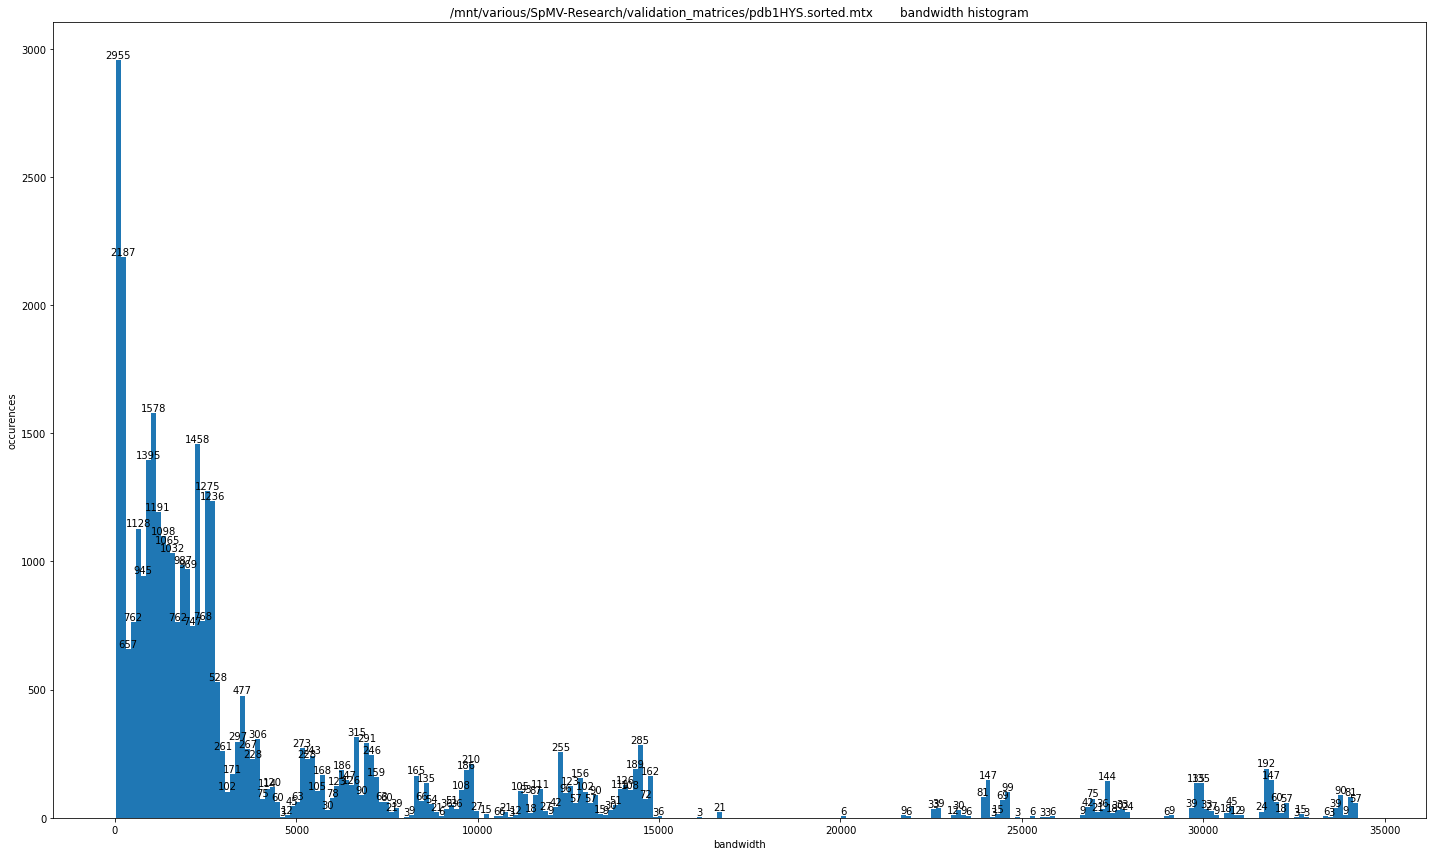

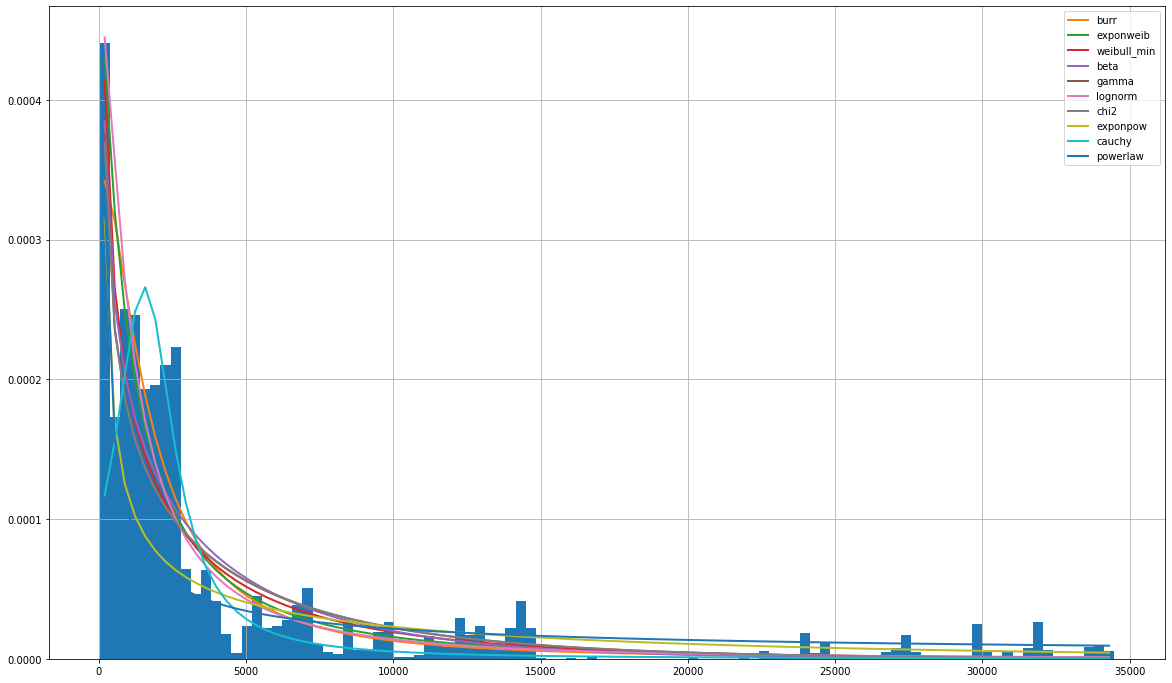

{'burr': {'c': 1.2869735807407956, 'd': 0.8600464735886773, 'loc': -11.963754855537132, 'scale': 2305.8680579041265}}
------
conf5_4-8x8-15.real.mtx :	dimensions (49152, 49152) / nnz 1916928 / mem footprint 22.125 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 2
nnz-row : min = 39 max = 39 nr_bins = 2


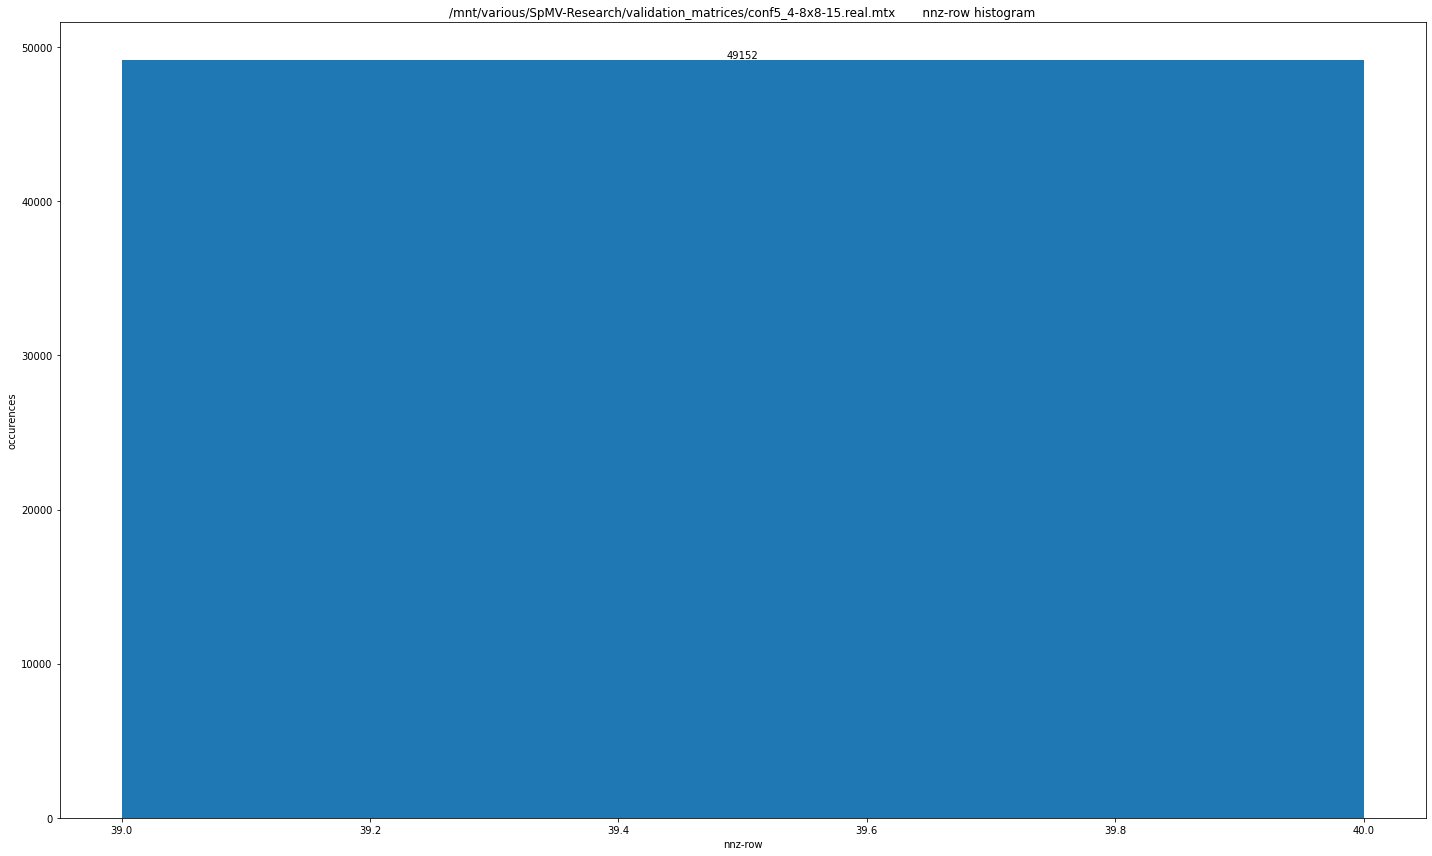

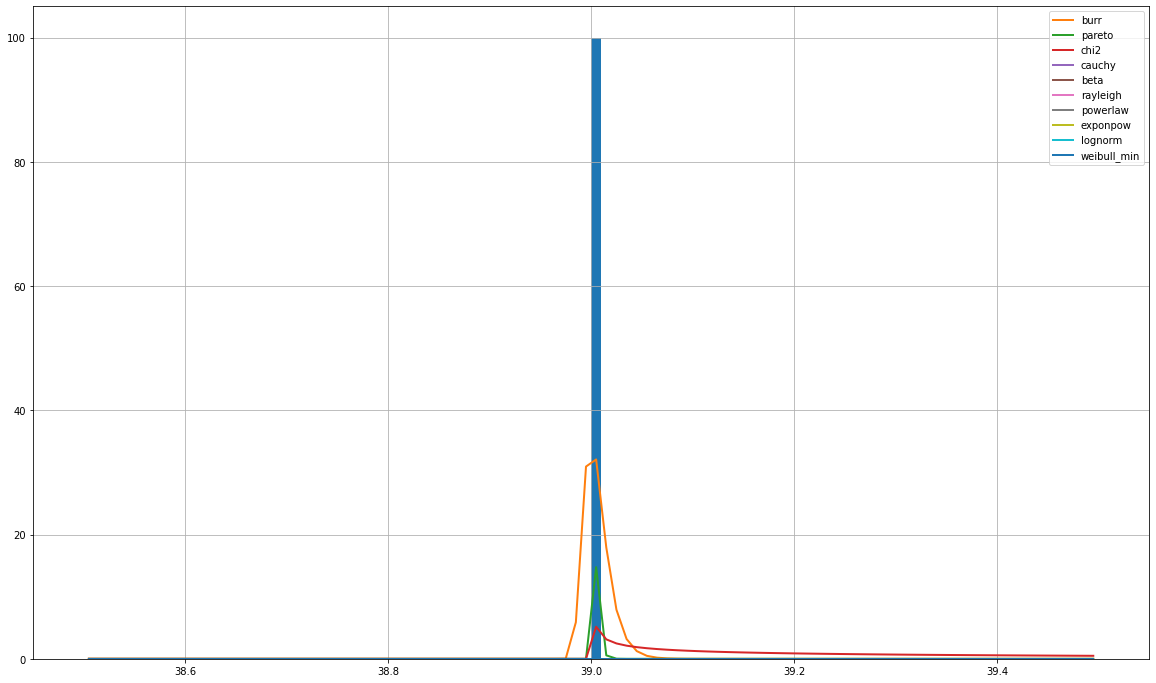

{'burr': {'c': 13042645.079910628, 'd': 28217496.010697115, 'loc': -135233.6802911588, 'scale': 135272.50234799058}}
GOOD 251
bandwidth : min = 6137 max = 48386 nr_bins = 251


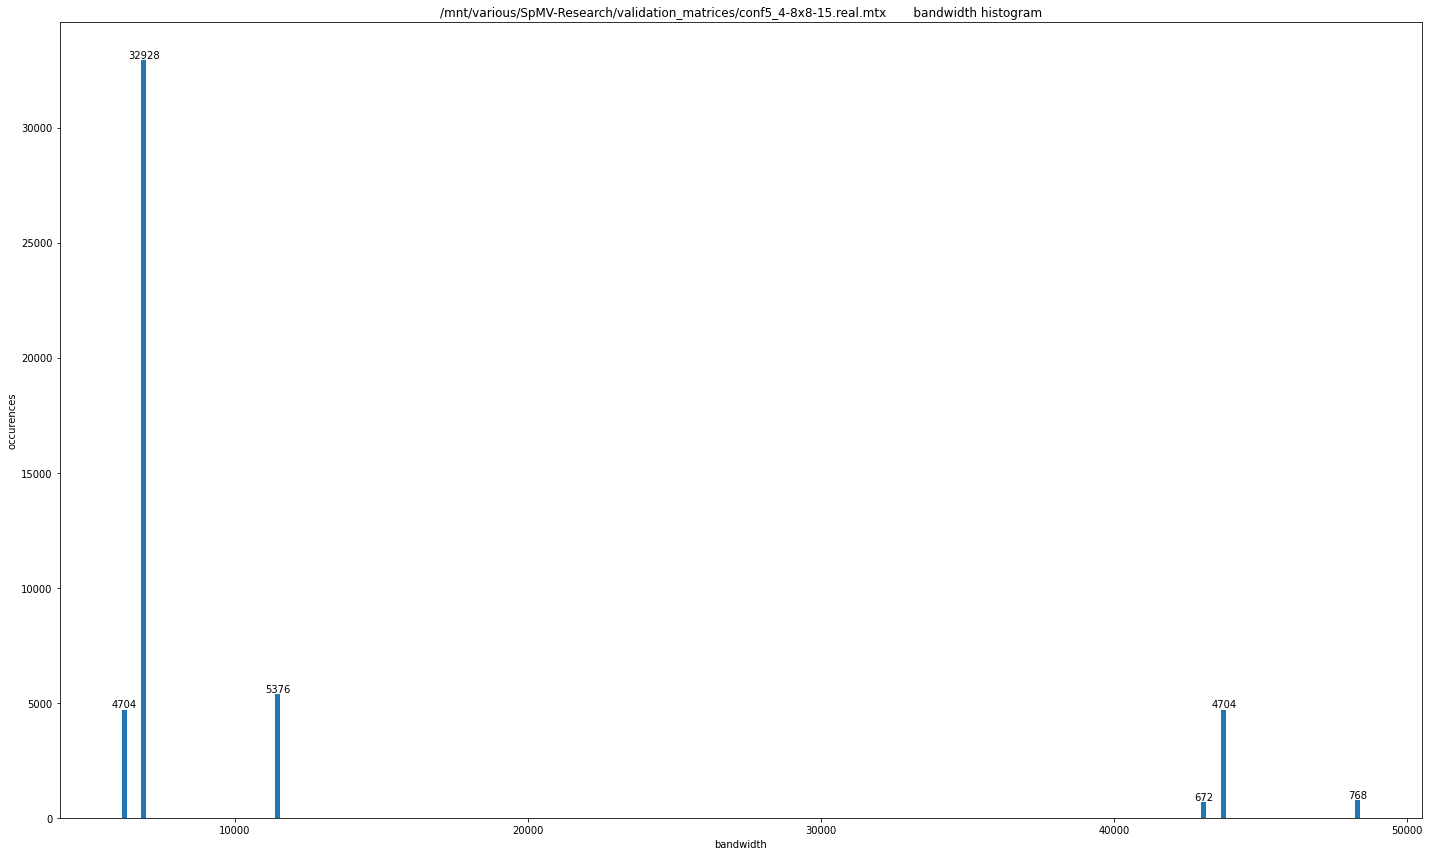

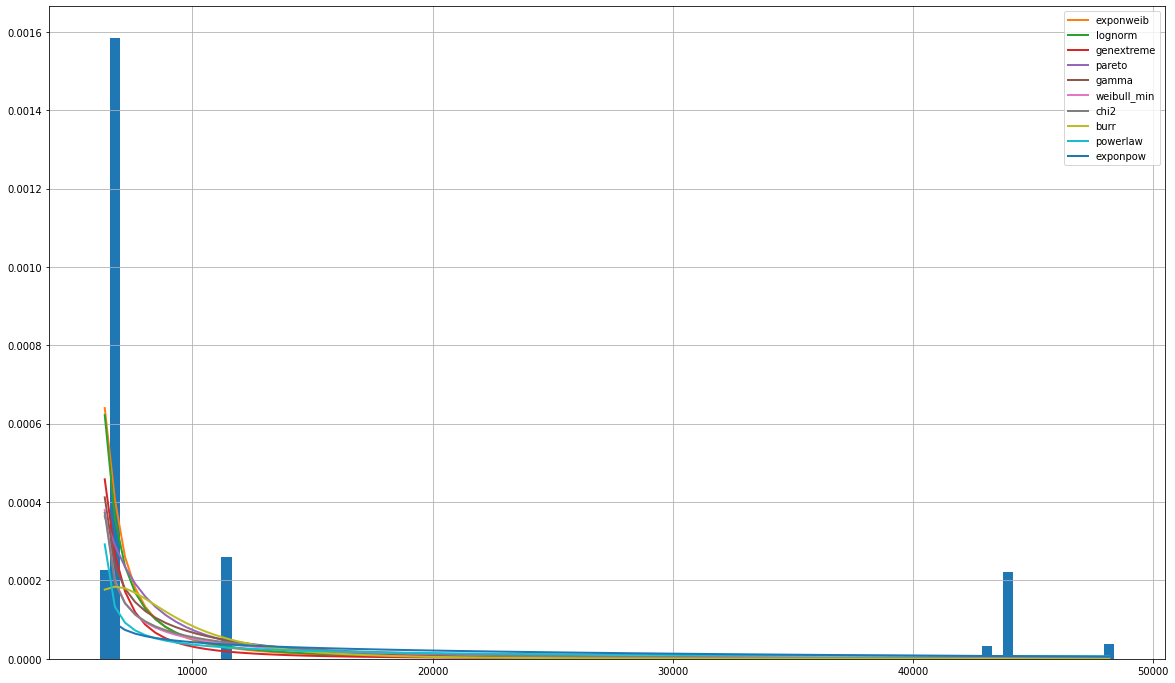

{'exponweib': {'a': 77.22488980302828, 'c': 0.16899381352189324, 'loc': 6118.95570052334, 'scale': 0.12489543154144261}}
------
cant.sorted.mtx :	dimensions (62451, 62451) / nnz 4007383 / mem footprint 46.099 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 79
nnz-row : min = 1 max = 78 nr_bins = 79


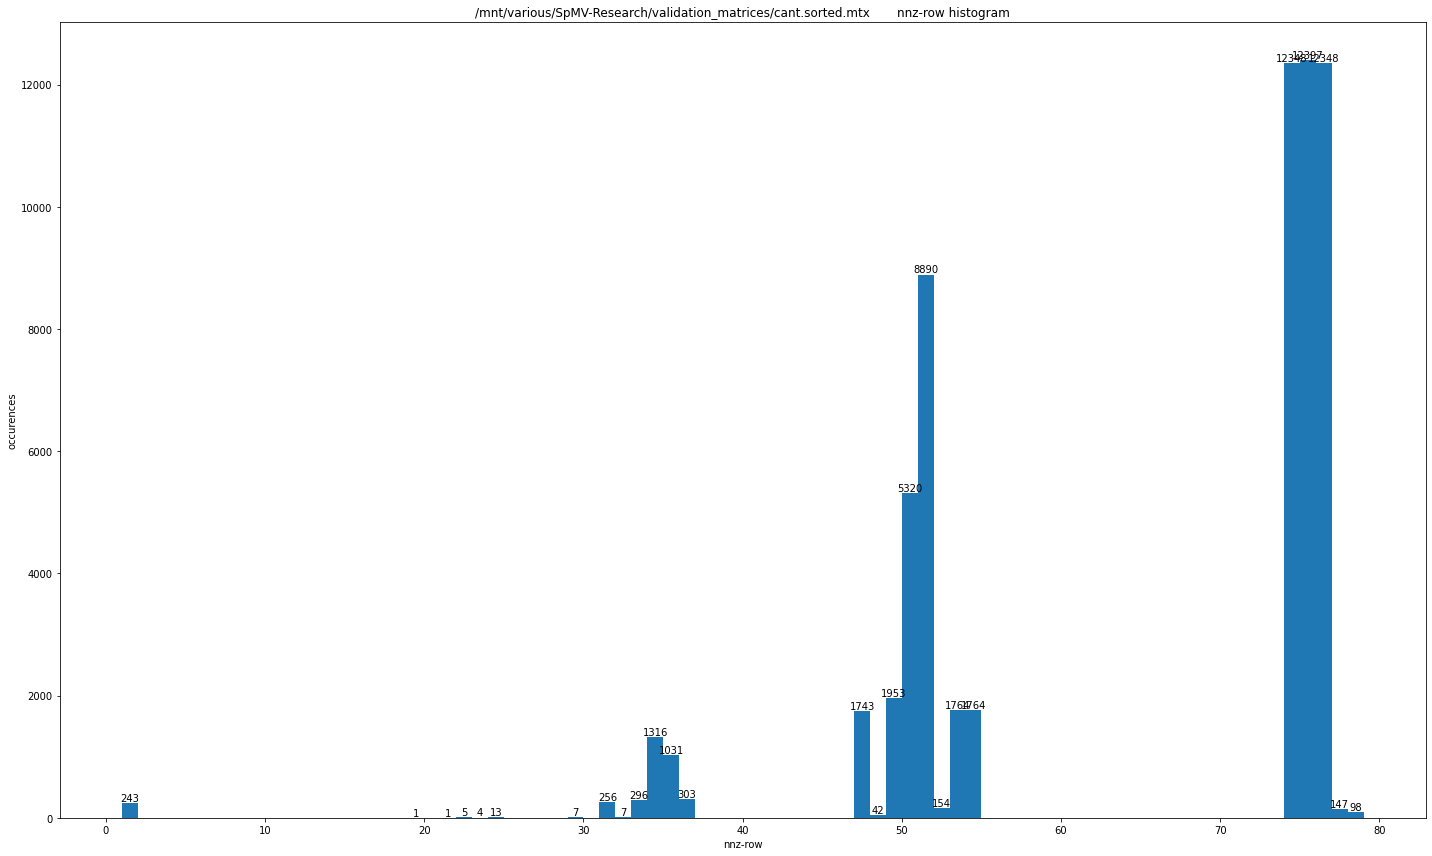

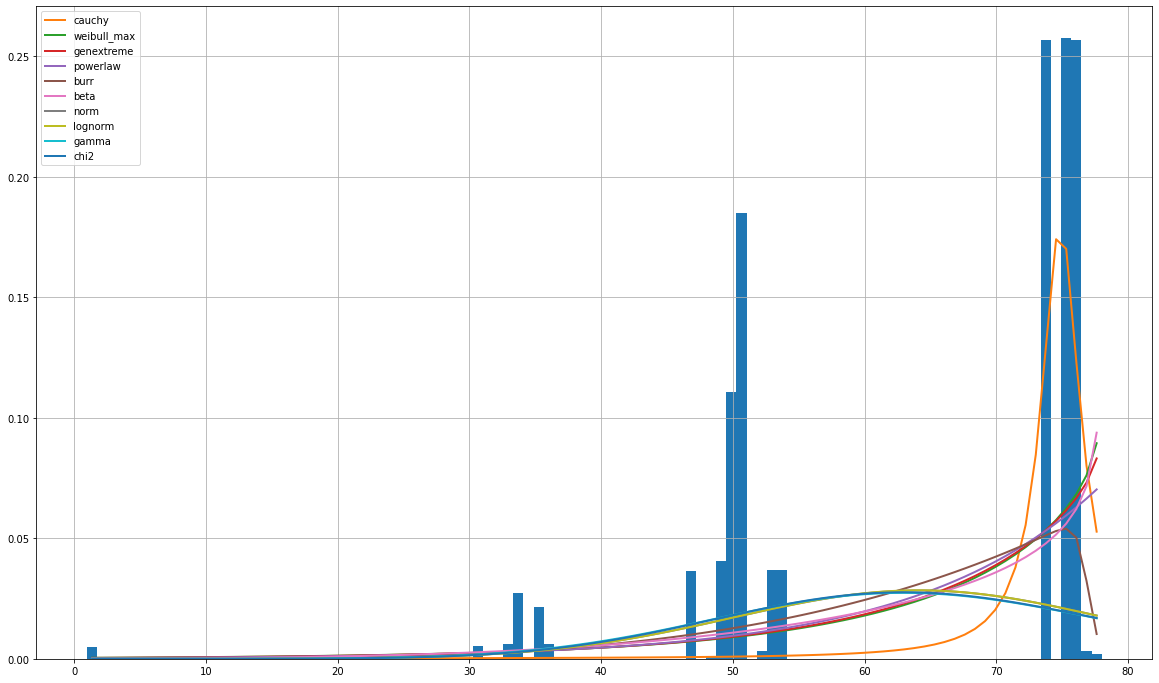

{'cauchy': {'loc': 74.87089637188272, 'scale': 1.764244173729399}}
GOOD 275
bandwidth : min = 0 max = 548 nr_bins = 275


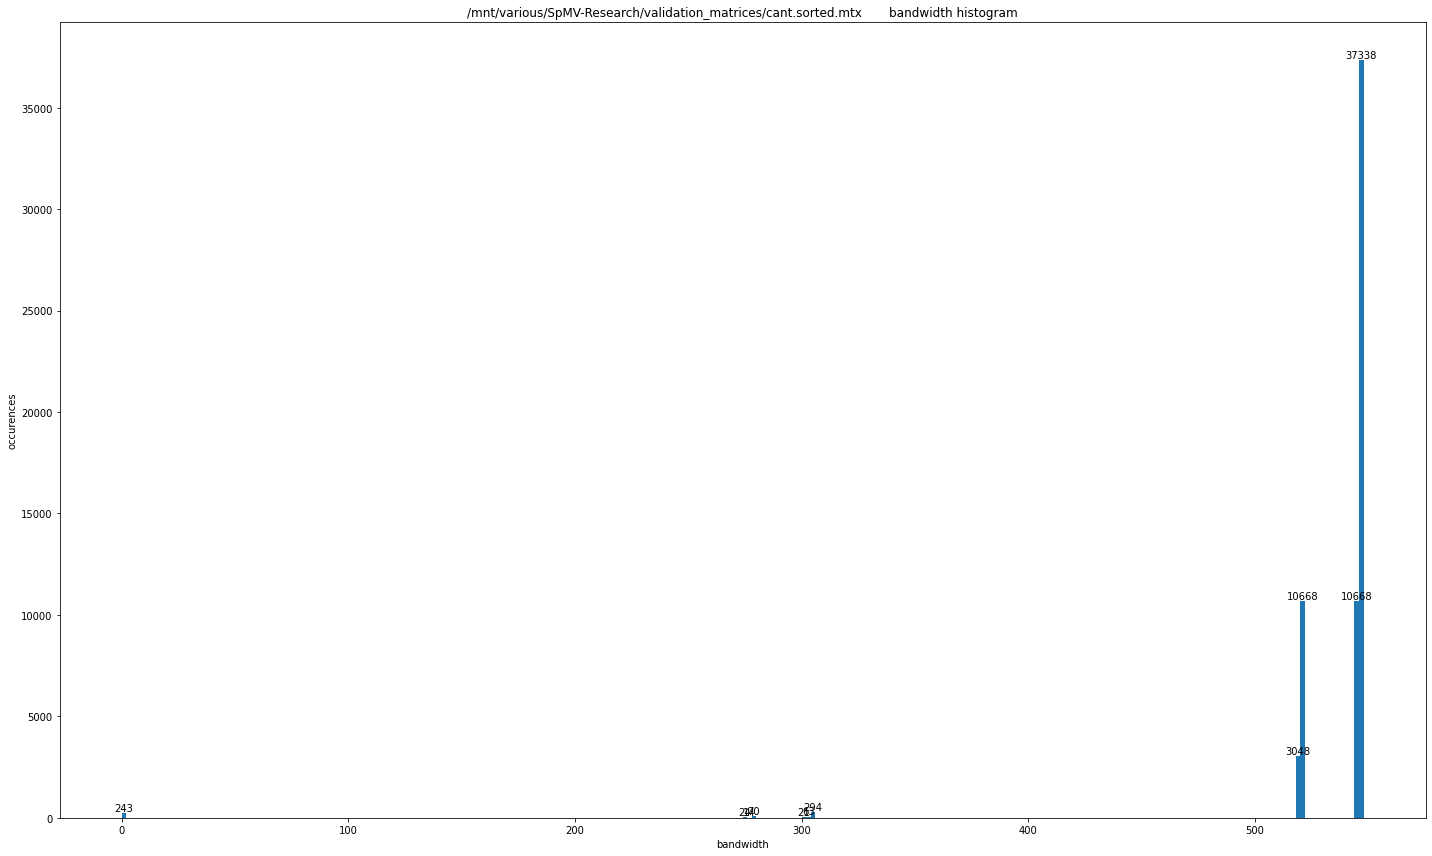

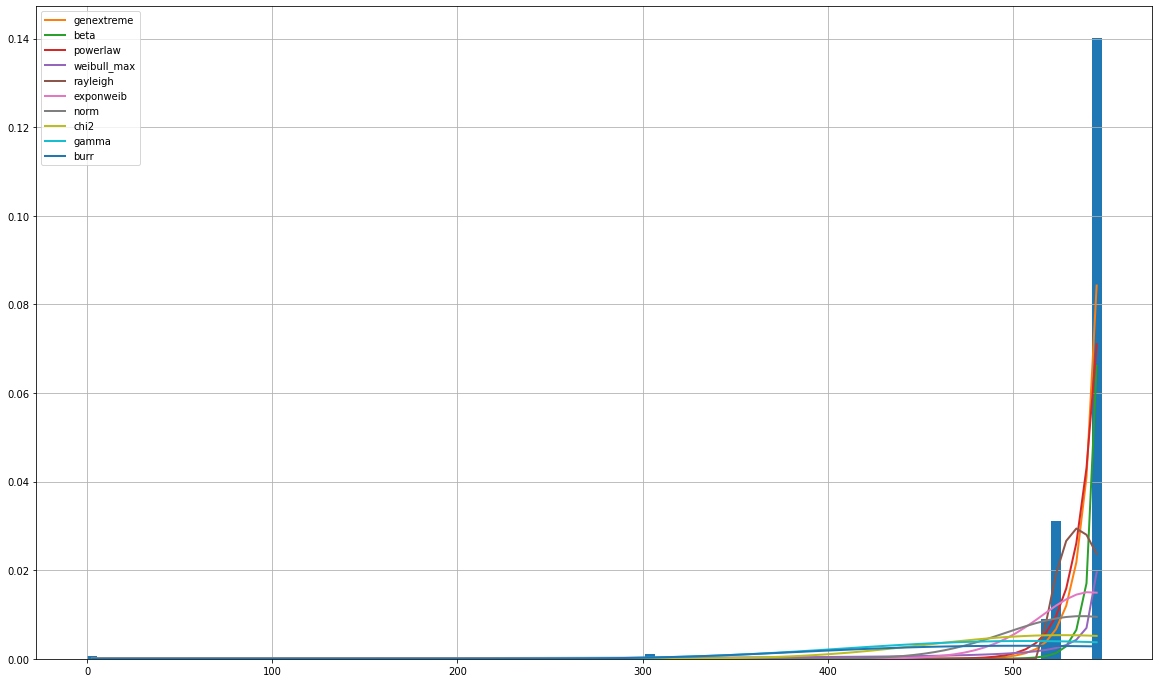

{'genextreme': {'c': 1.0896624063669207, 'loc': 539.6850783494232, 'scale': 9.060457534519948}}
------
rma10.sorted.mtx :	dimensions (46835, 46835) / nnz 2374001 / mem footprint 27.347 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 143
nnz-row : min = 4 max = 145 nr_bins = 143


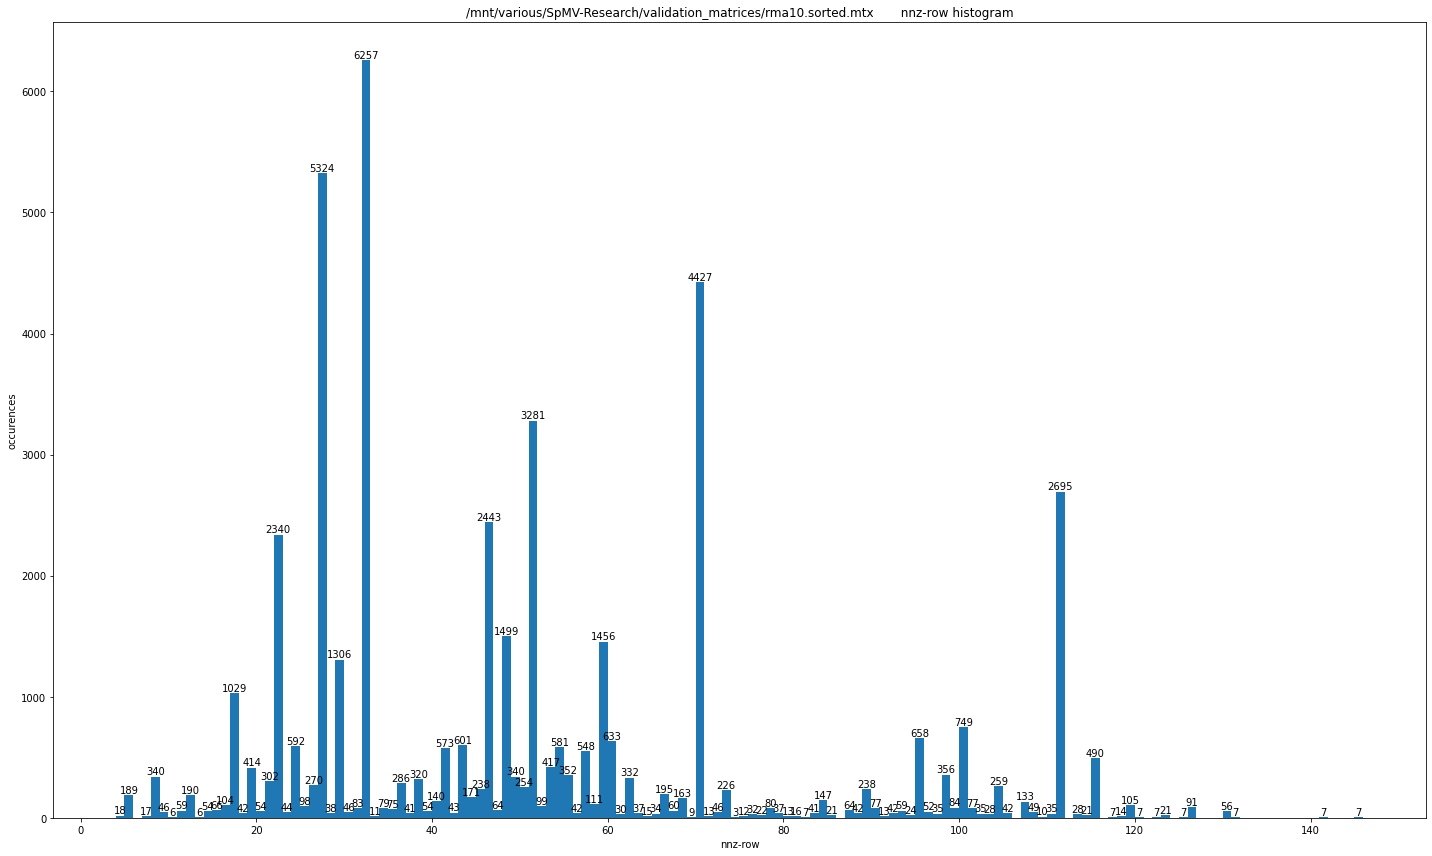

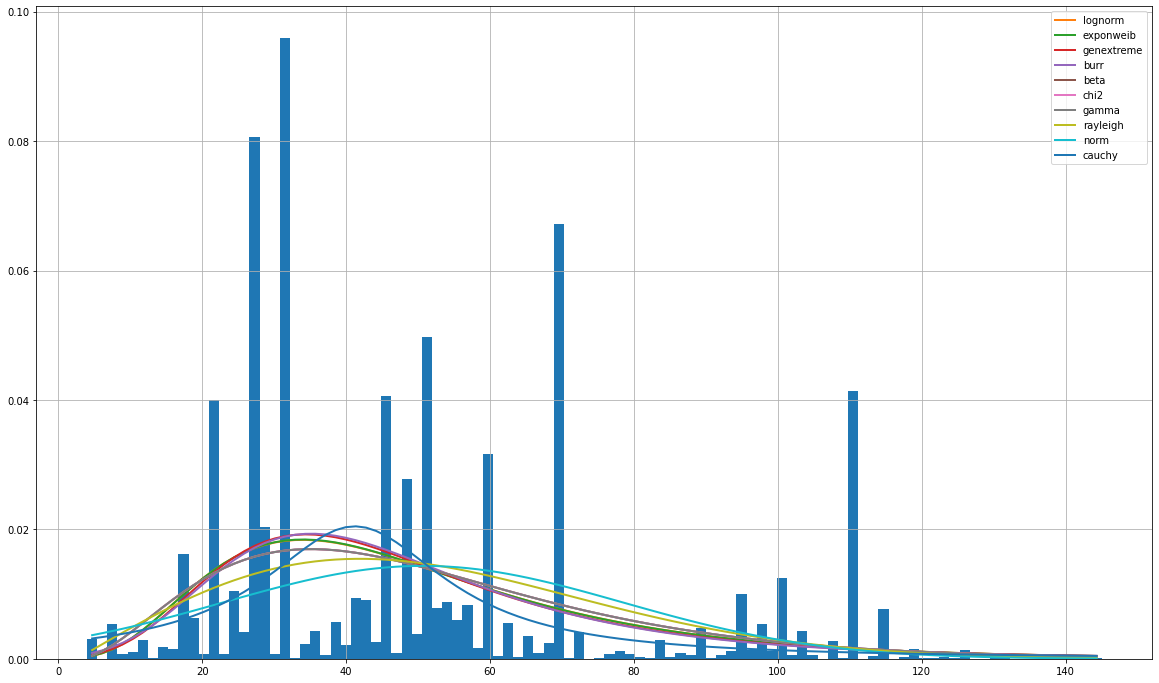

{'lognorm': {'s': 0.48384593232555284, 'loc': -5.923446860758588, 'scale': 50.430034861797374}}
GOOD 252
bandwidth : min = 9 max = 25380 nr_bins = 252


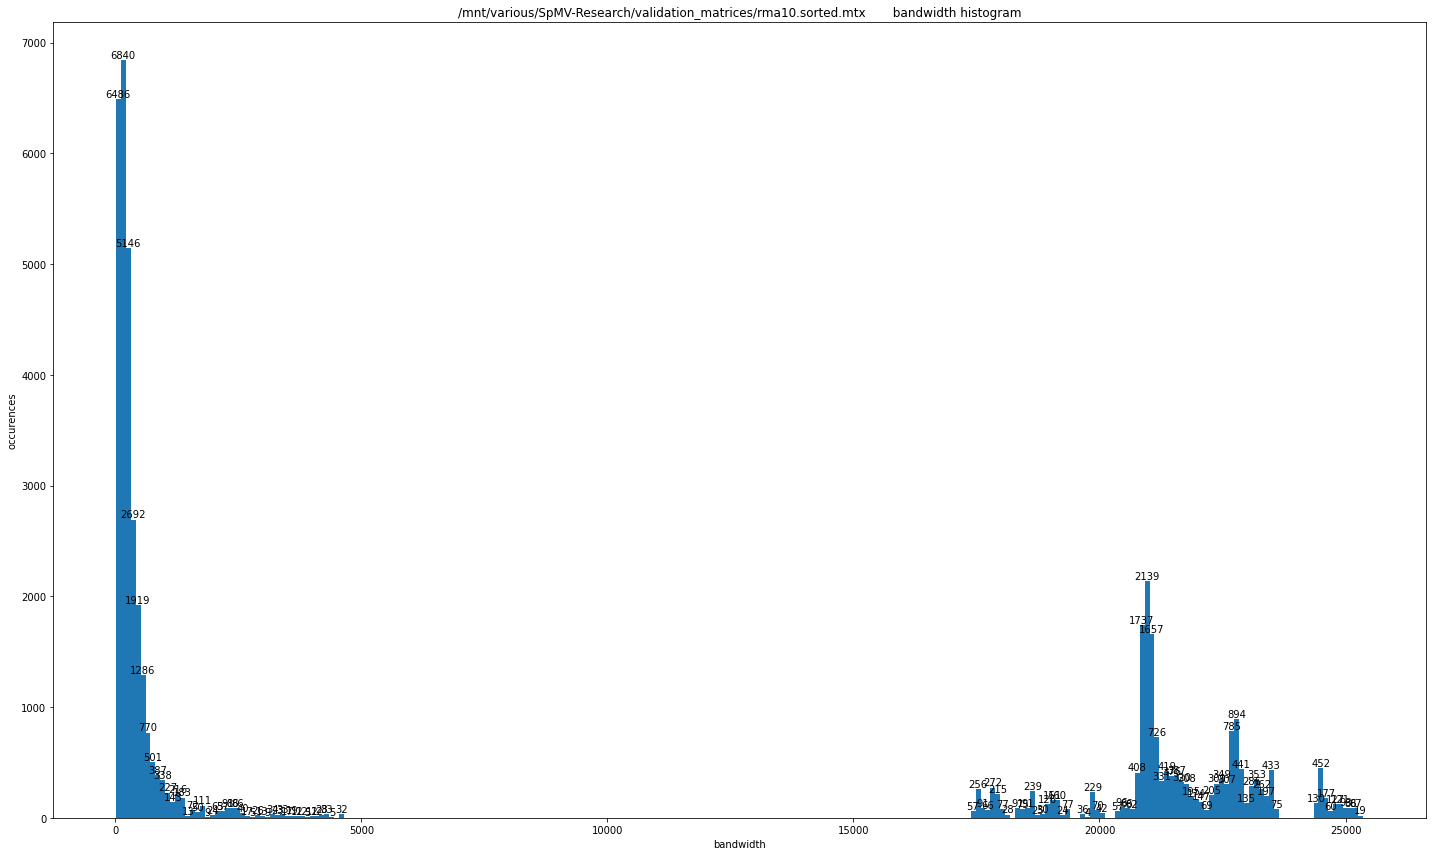

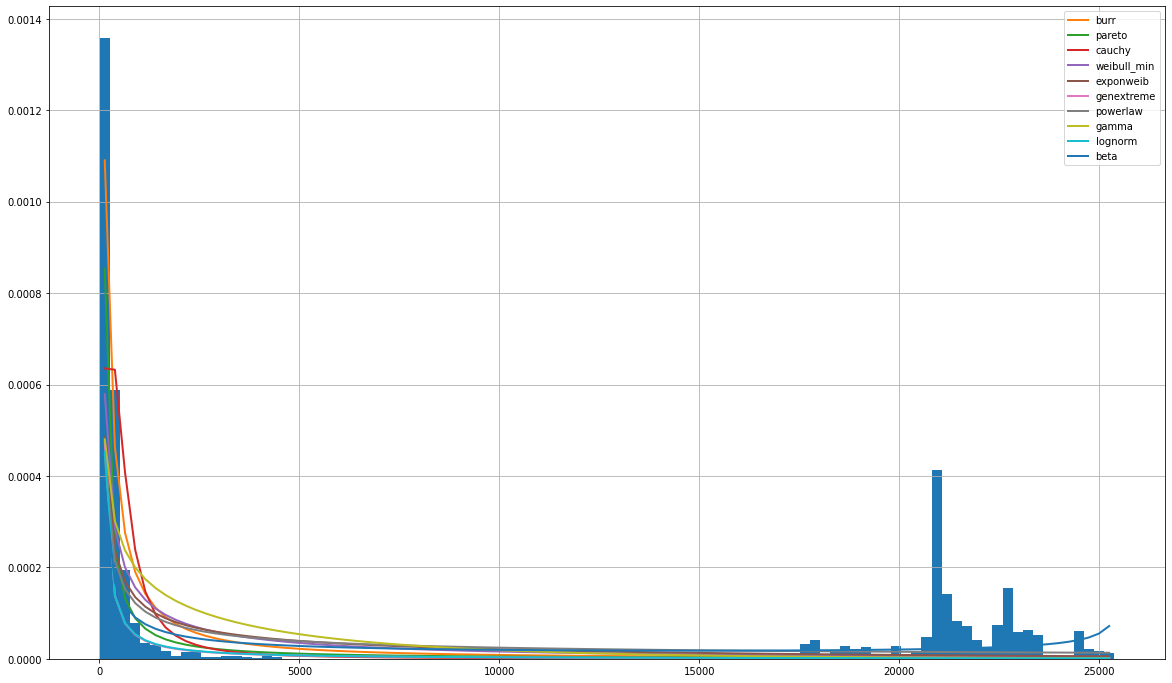

{'burr': {'c': 0.4928884823324906, 'd': 124.83047787813803, 'loc': -0.21099578512820338, 'scale': 0.024175379997521798}}
------
mip1.sorted.mtx :	dimensions (66463, 66463) / nnz 10352819 / mem footprint 118.732 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 251
nnz-row : min = 4 max = 66395 nr_bins = 251


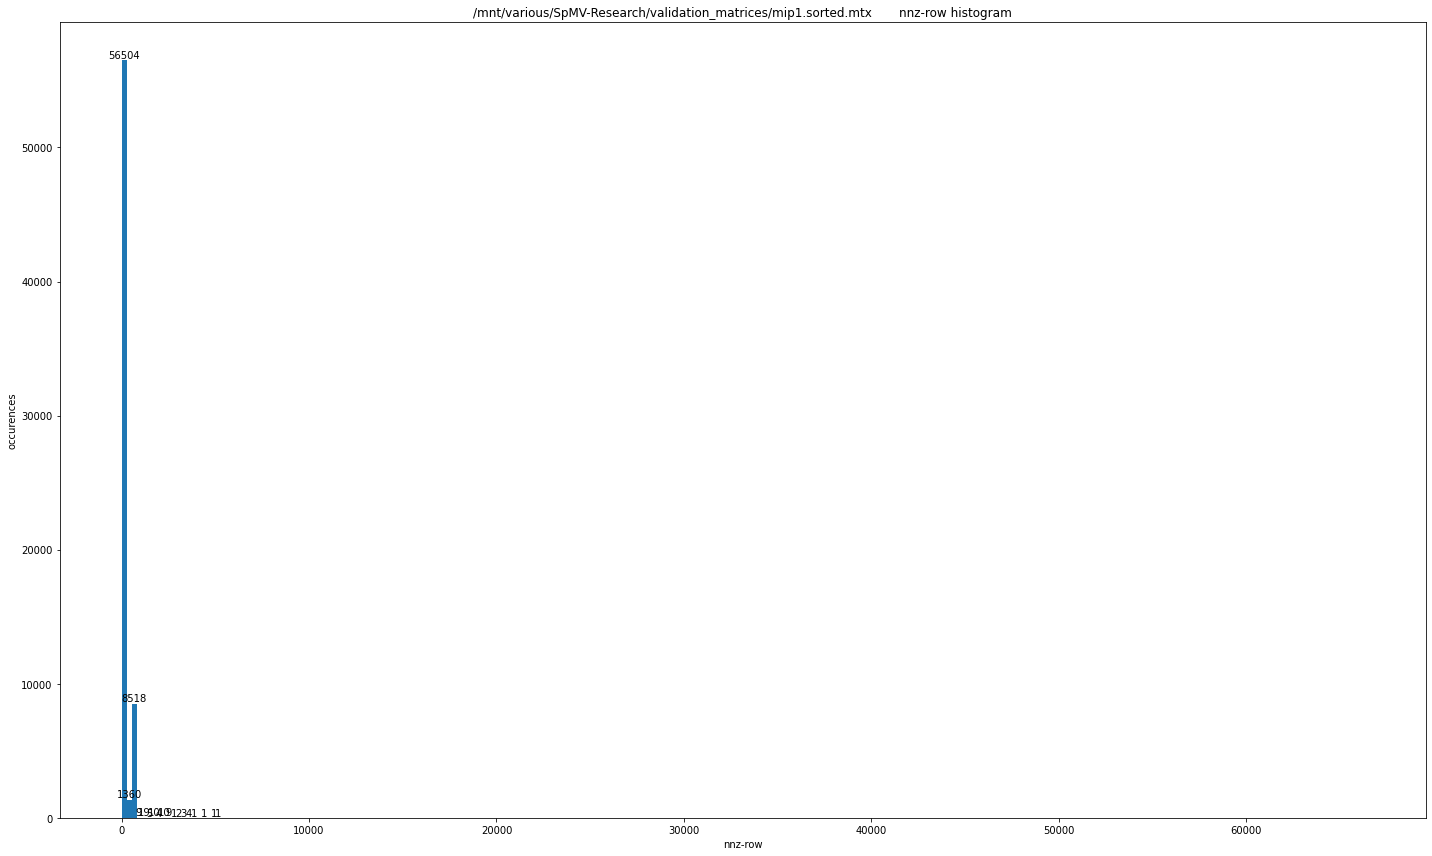

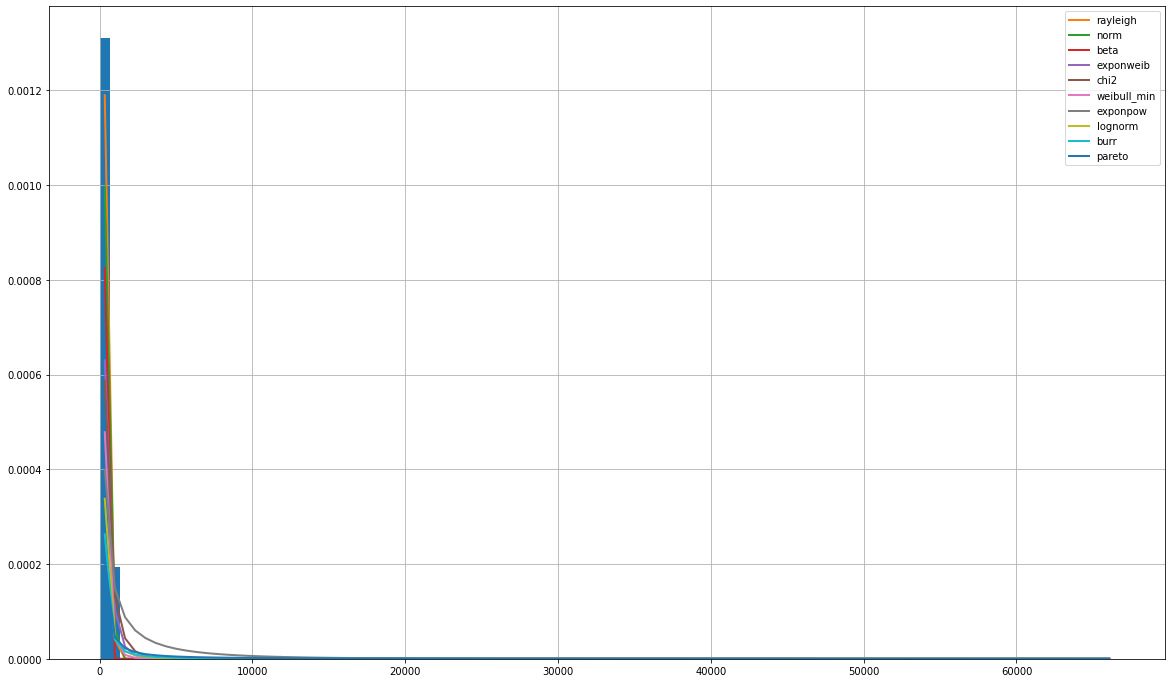

{'rayleigh': {'loc': -270.9359902568163, 'scale': 390.5752203775115}}
GOOD 251
bandwidth : min = 9 max = 66462 nr_bins = 251


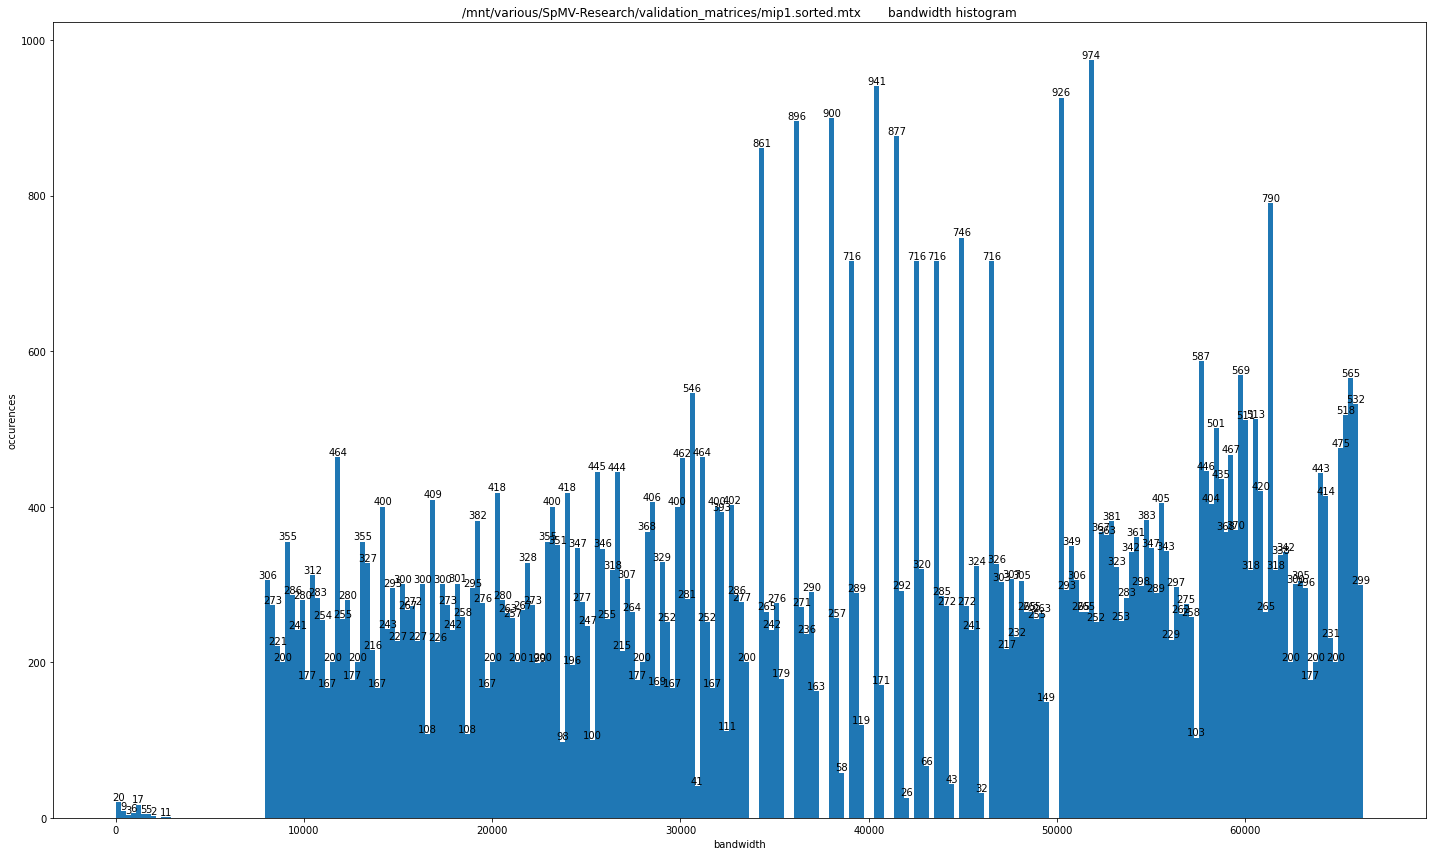

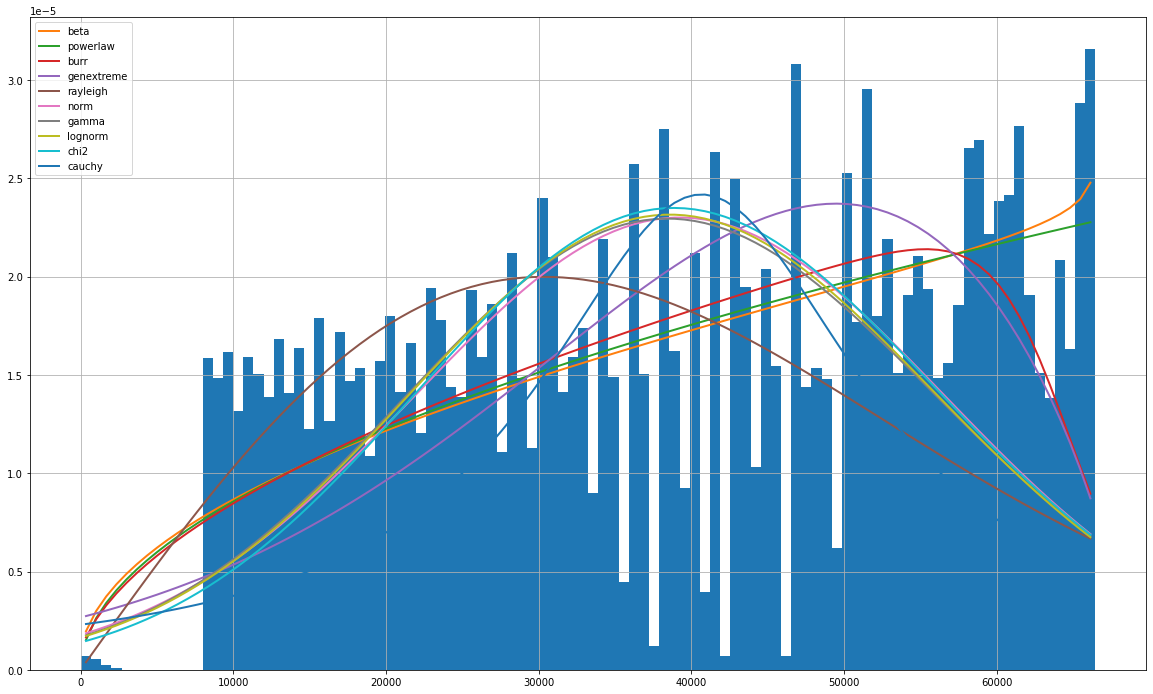

{'beta': {'a': 1.4864689410928698, 'b': 0.9732827153528993, 'loc': -142.02725478041214, 'scale': 66604.02725478042}}
------
webbase-1M.sorted.mtx :	dimensions (1000005, 1000005) / nnz 3105536 / mem footprint 39.355 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 262
nnz-row : min = 1 max = 4700 nr_bins = 262


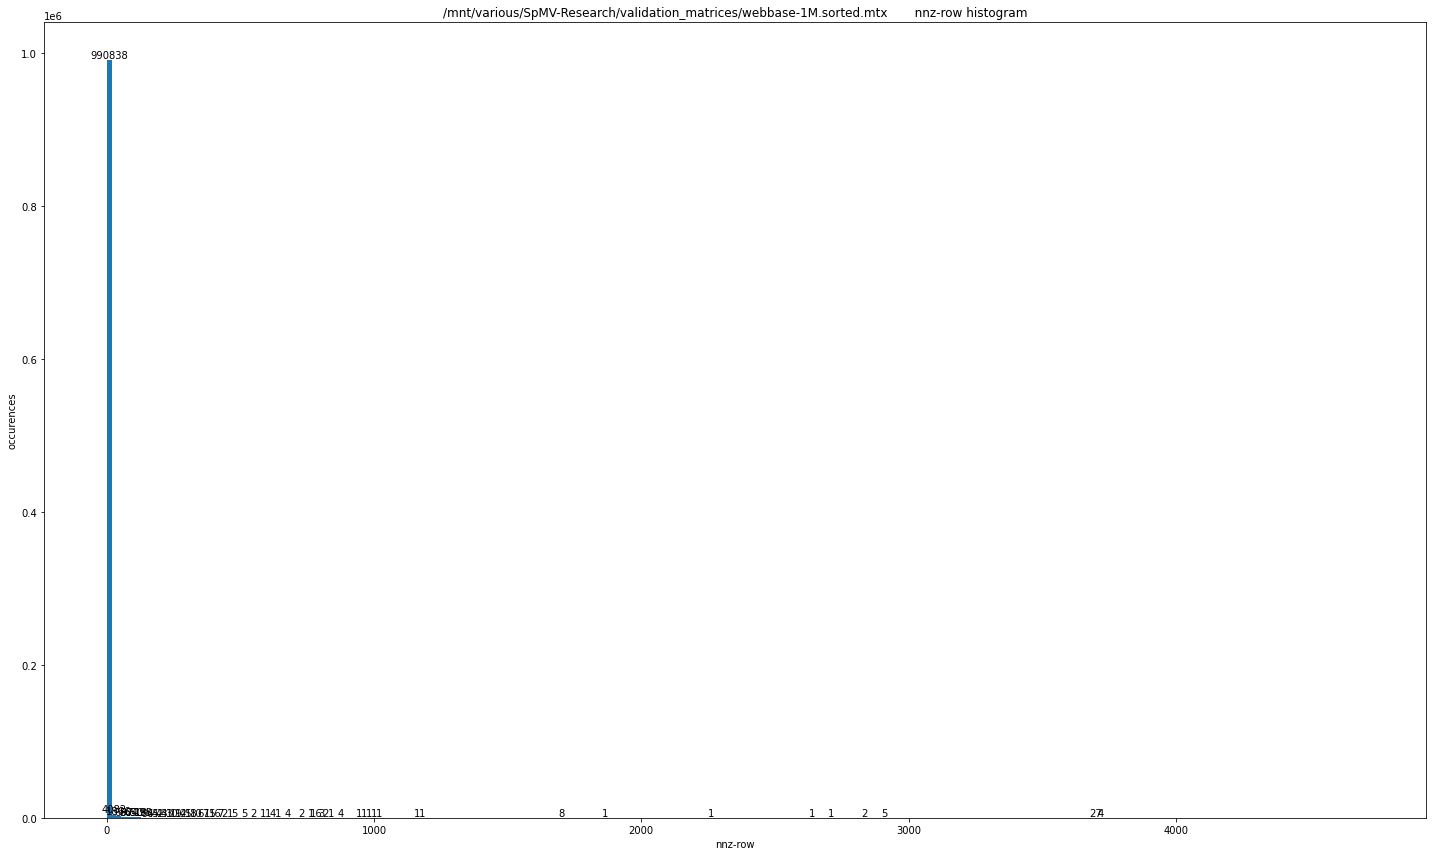

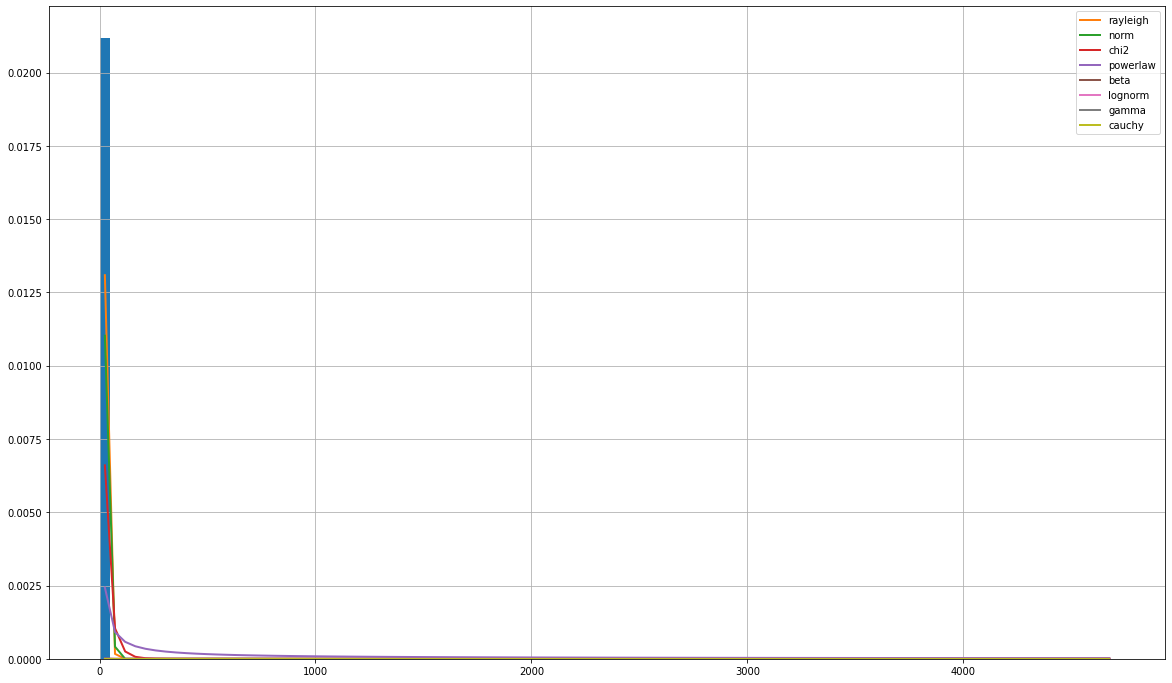

{'rayleigh': {'loc': -22.88565444360042, 'scale': 25.670221365187572}}
GOOD 251
bandwidth : min = 0 max = 987689 nr_bins = 251


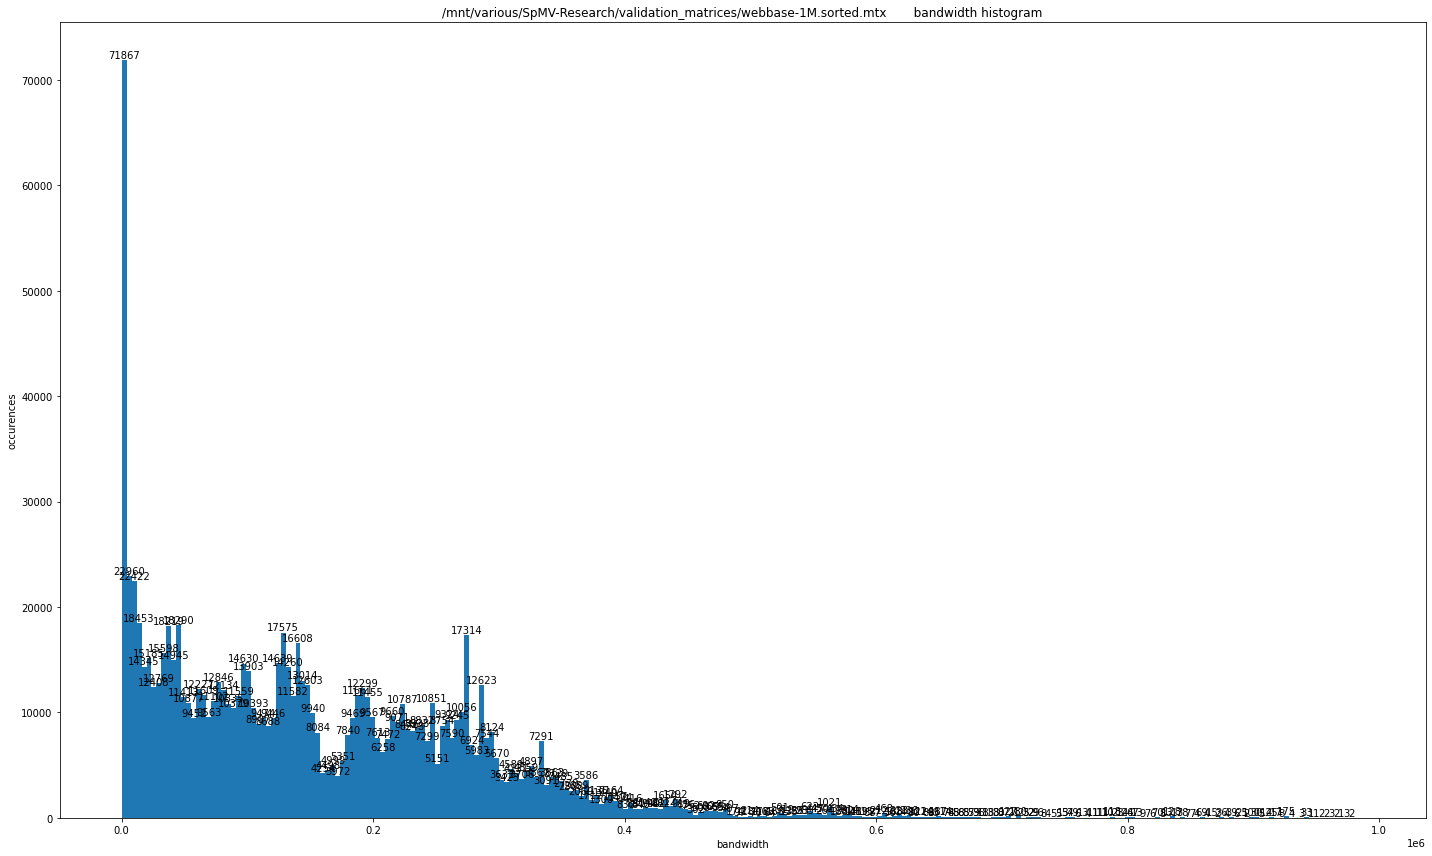

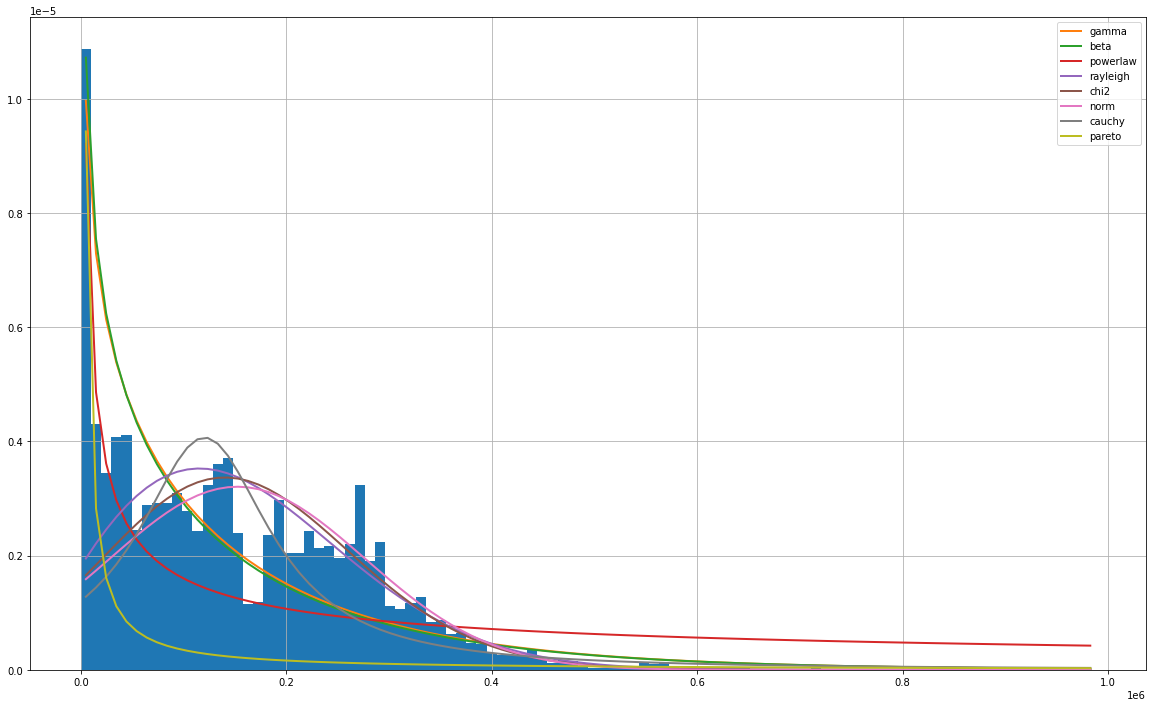

{'gamma': {'a': 0.7622868237702576, 'loc': -7.562642083013939e-22, 'scale': 193442.35665108523}}
------
consph.sorted.mtx :	dimensions (83334, 83334) / nnz 6010480 / mem footprint 69.102 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 82
nnz-row : min = 1 max = 81 nr_bins = 82


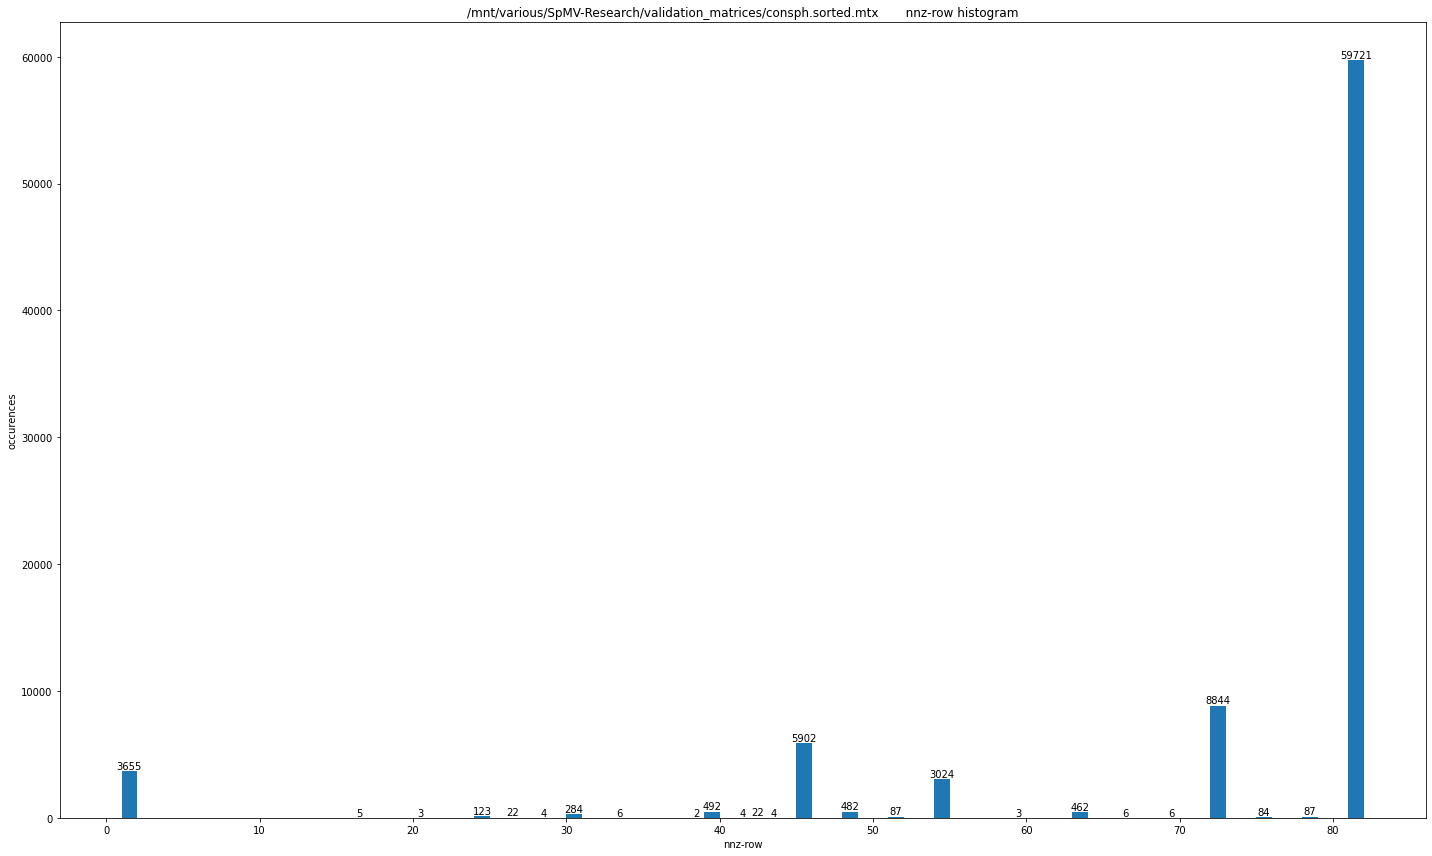

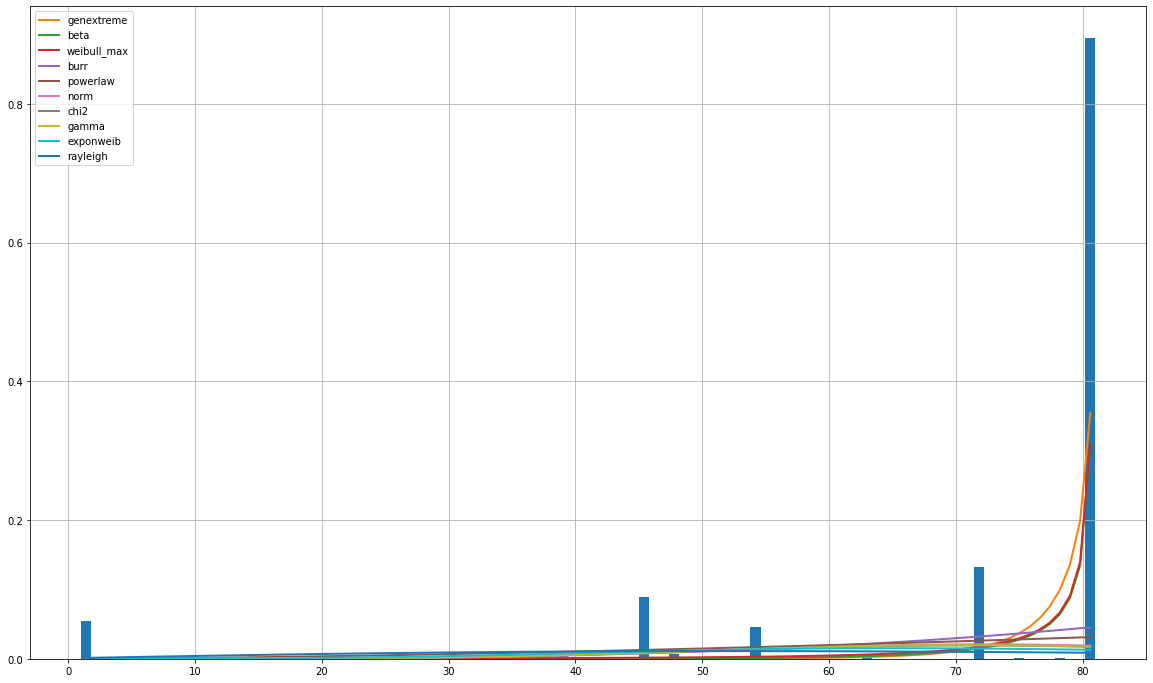

{'genextreme': {'c': 1.3219907214073183, 'loc': 78.32860922125178, 'scale': 3.531553822758216}}
GOOD 252
bandwidth : min = 0 max = 46481 nr_bins = 252


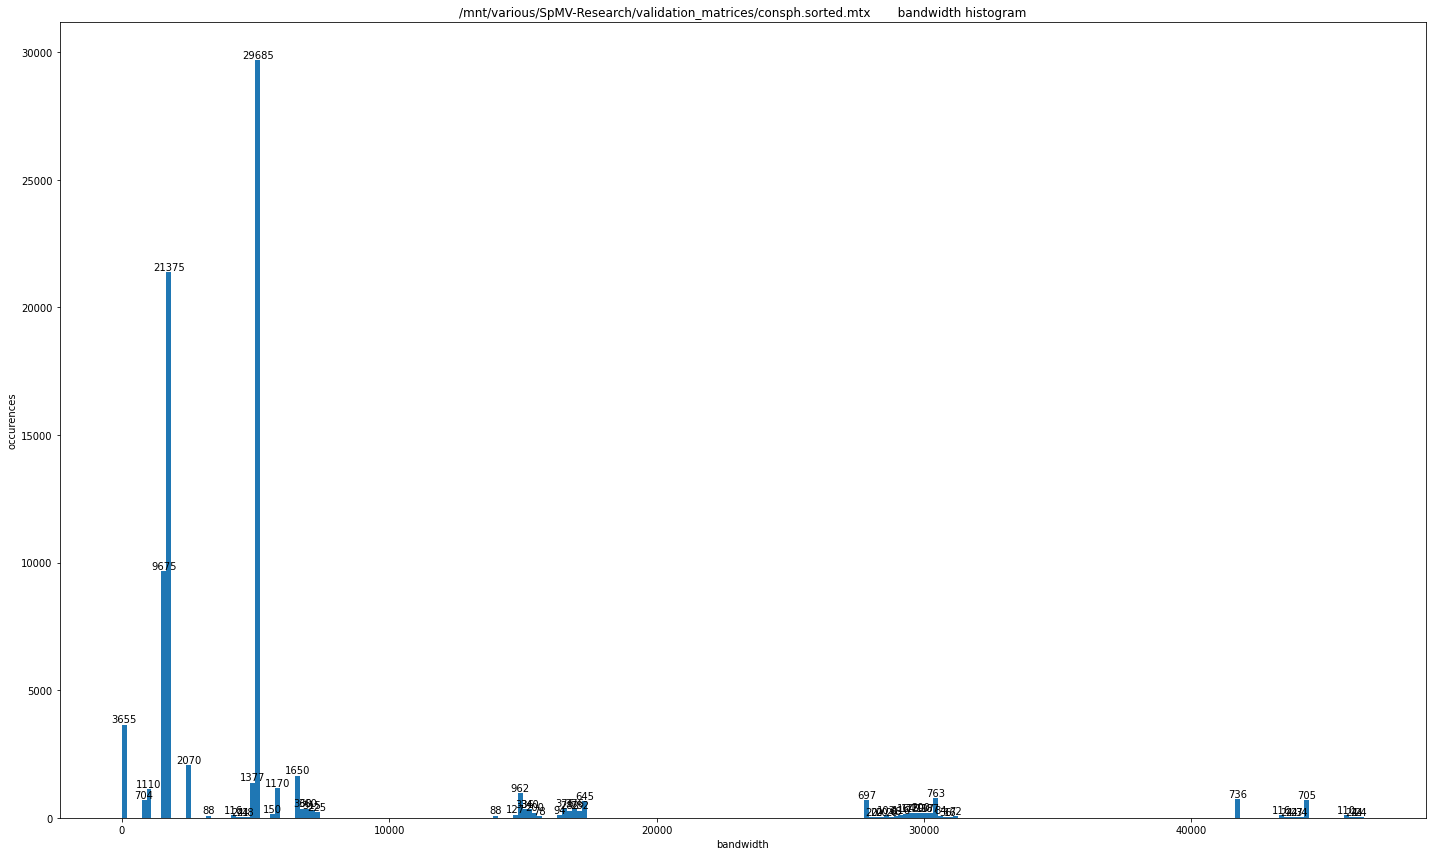

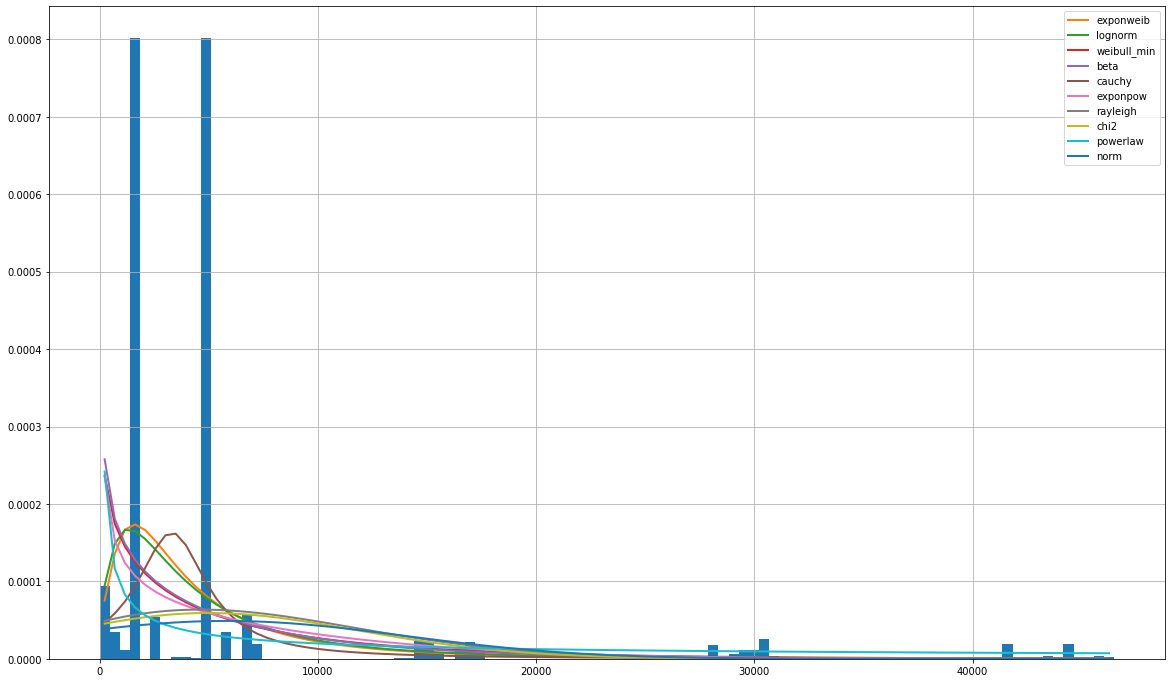

{'exponweib': {'a': 151.77932170954145, 'c': 0.28389645432094424, 'loc': -911.9536256043687, 'scale': 11.577117266004457}}
------
shipsec1.sorted.mtx :	dimensions (140874, 140874) / nnz 7813404 / mem footprint 89.955 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 80
nnz-row : min = 24 max = 102 nr_bins = 80


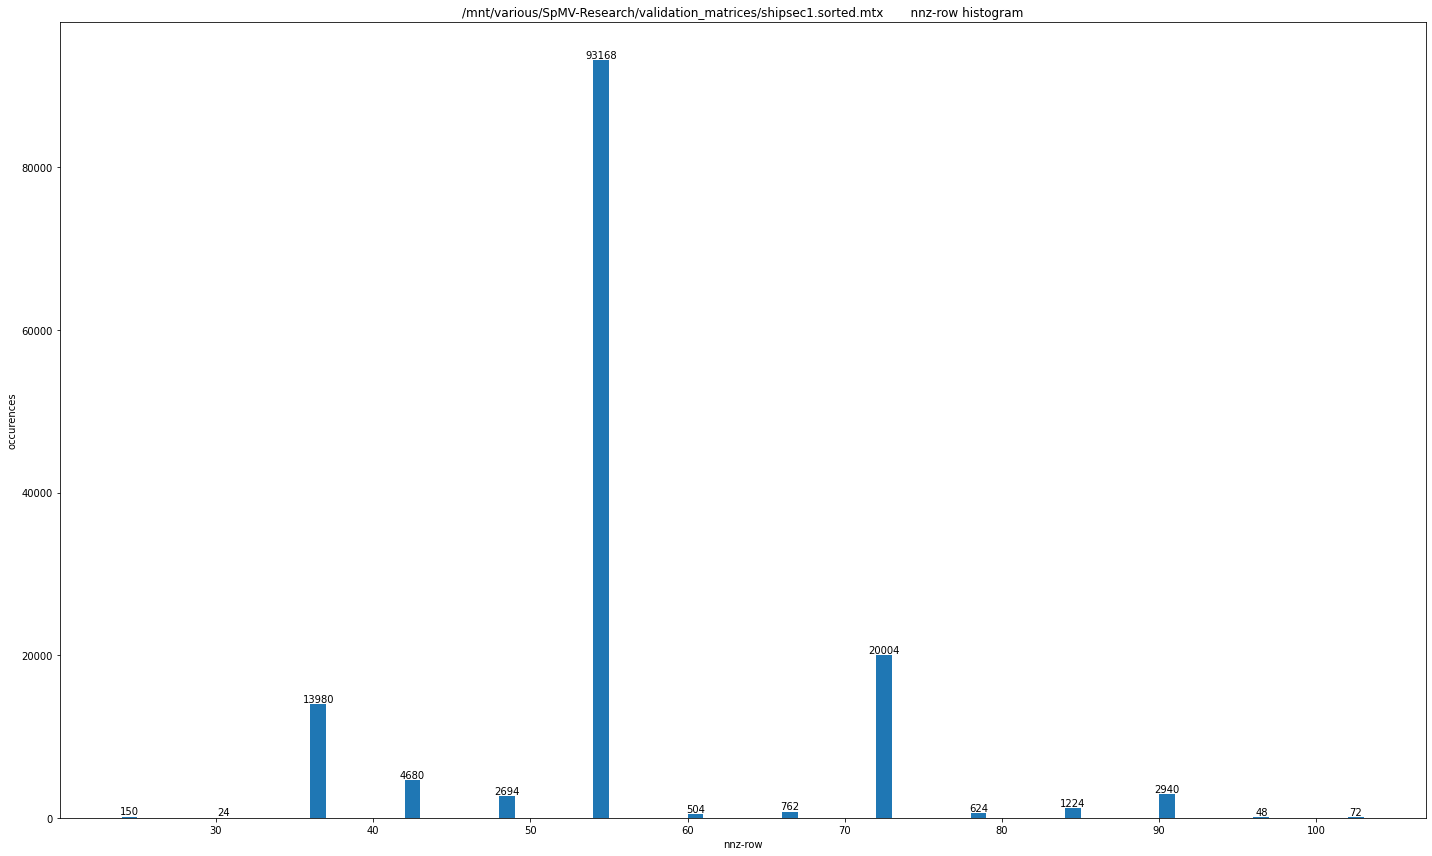

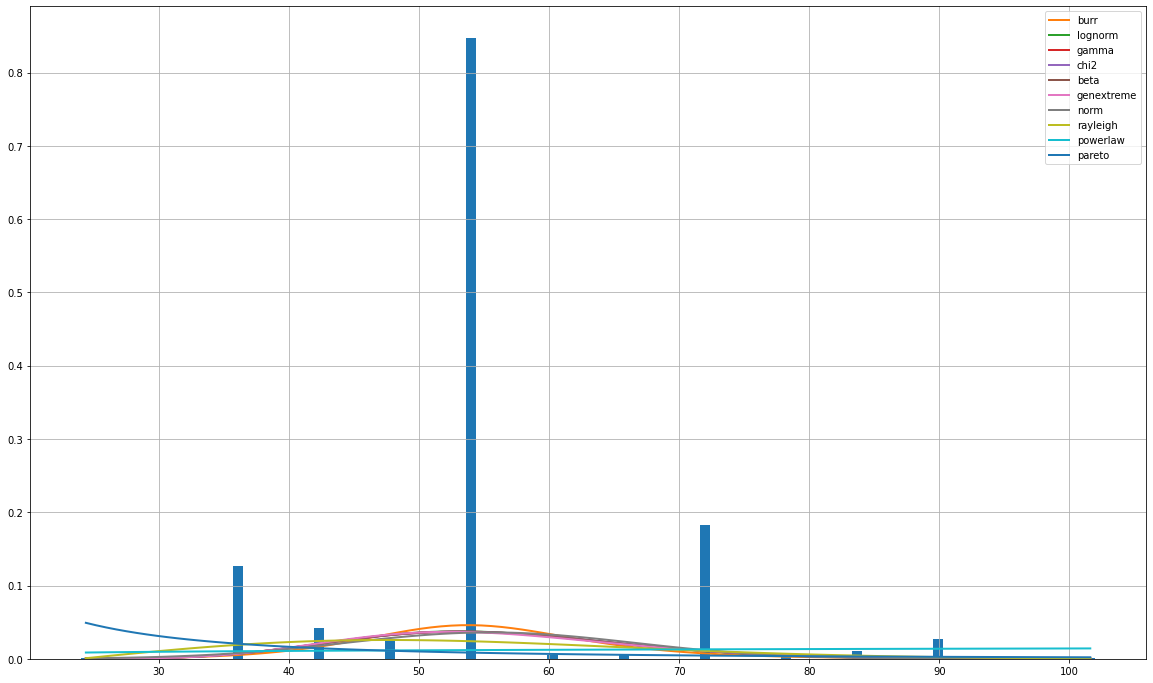

{'burr': {'c': 10.648846075787652, 'd': 0.830473159419452, 'loc': -0.25793601095600555, 'scale': 56.07172324155589}}
GOOD 253
bandwidth : min = 35 max = 10145 nr_bins = 253


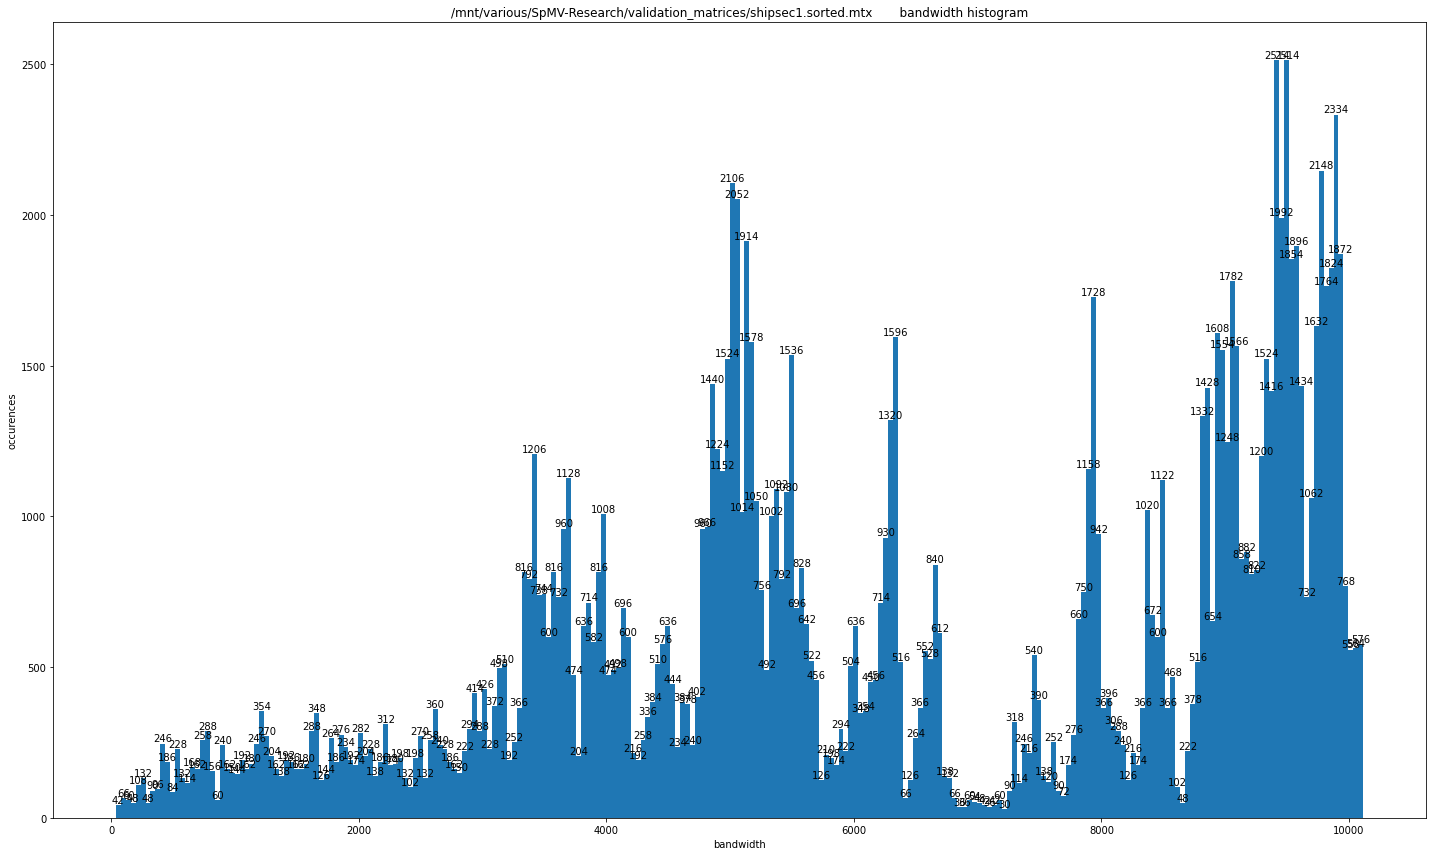

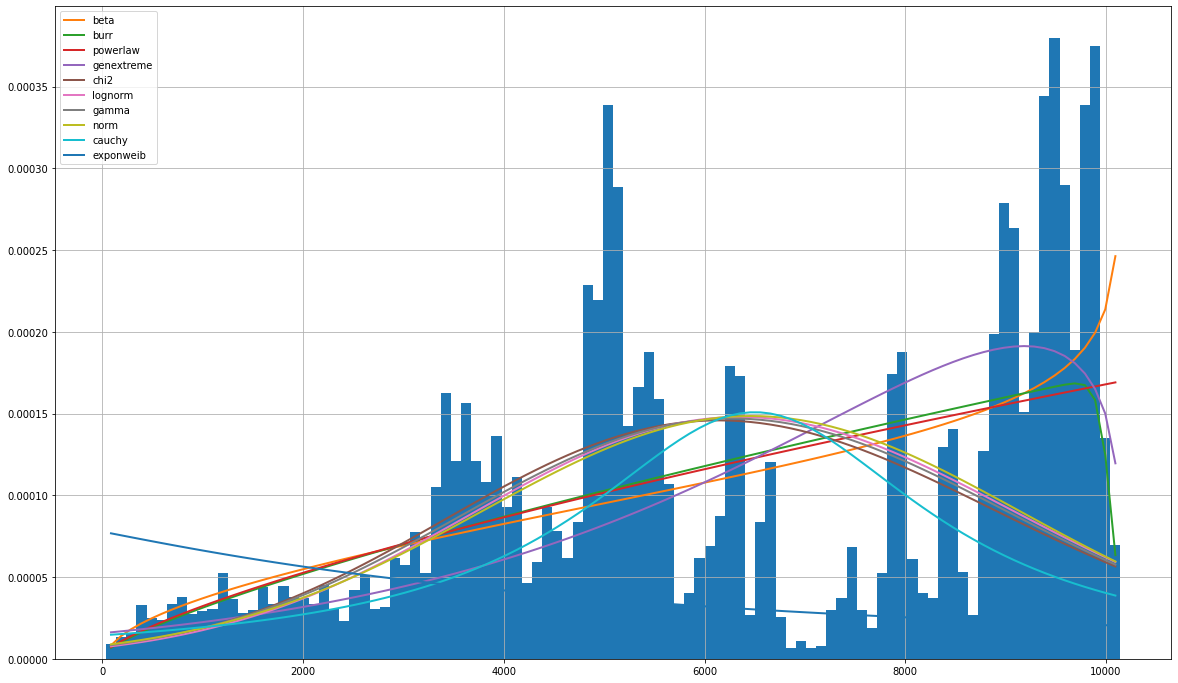

{'beta': {'a': 1.5350740523033992, 'b': 0.8758089326831808, 'loc': 25.460229404439318, 'scale': 10119.539770595562}}
------
TSOPF_RS_b300_c3.sorted.mtx :	dimensions (42138, 42138) / nnz 4413449 / mem footprint 50.669 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 210
nnz-row : min = 1 max = 209 nr_bins = 210


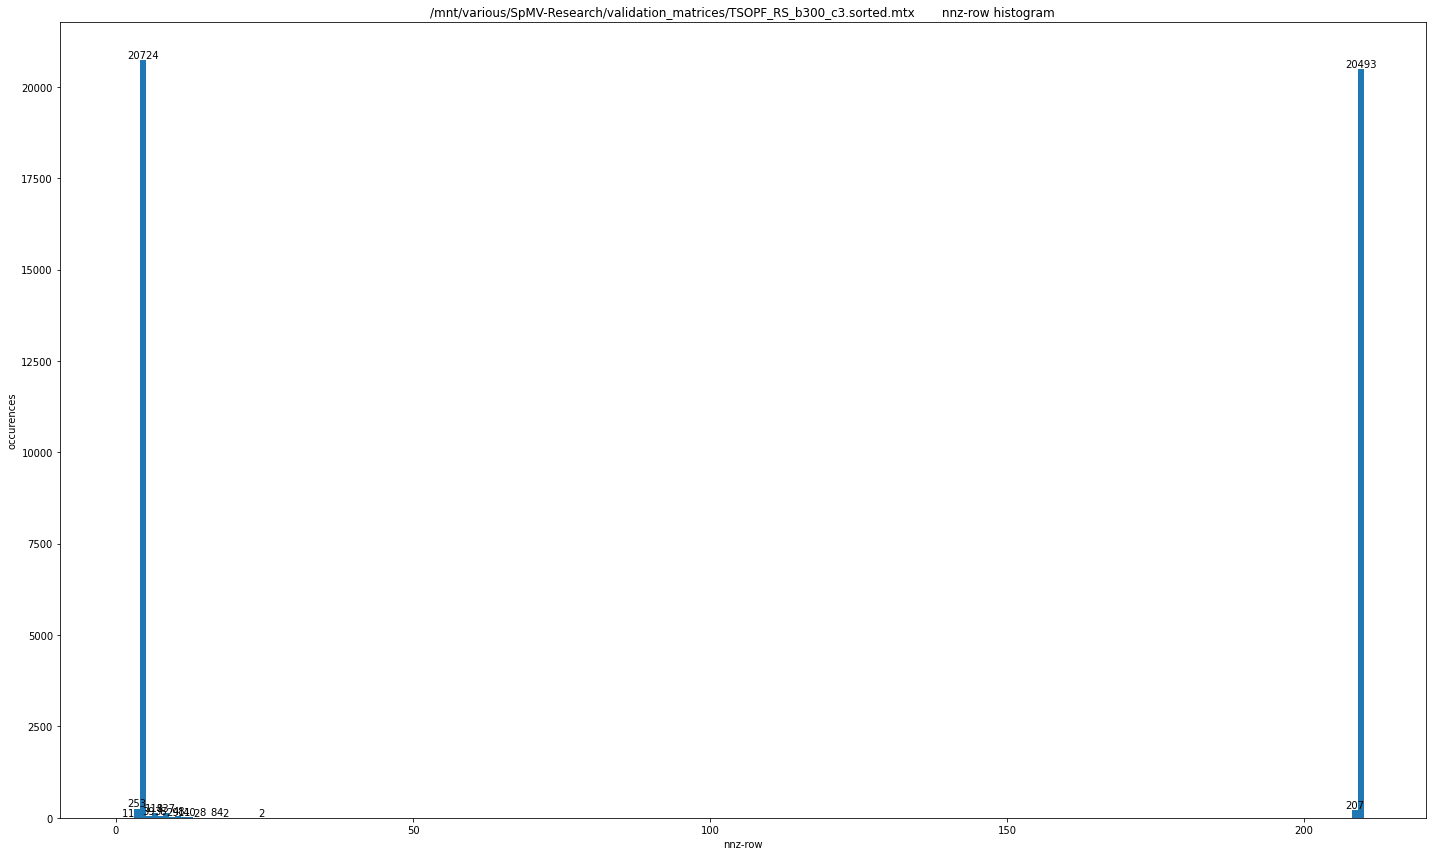

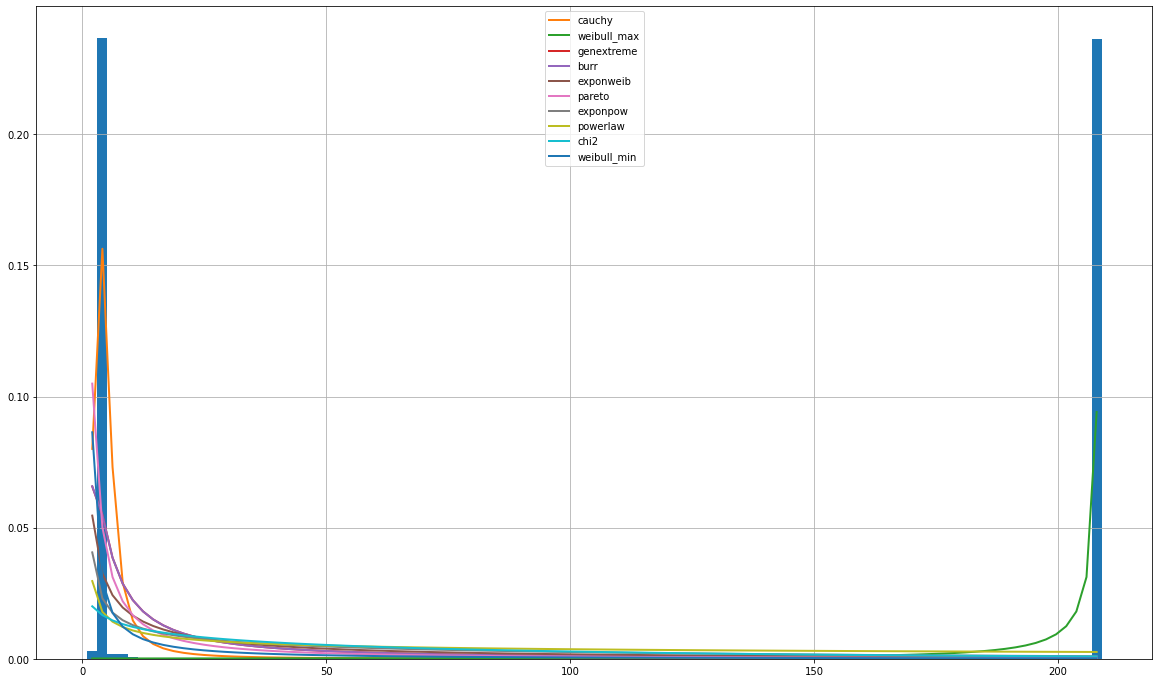

{'cauchy': {'loc': 4.027954420885375, 'scale': 2.0317219938011966}}
GOOD 251
bandwidth : min = 0 max = 41537 nr_bins = 251


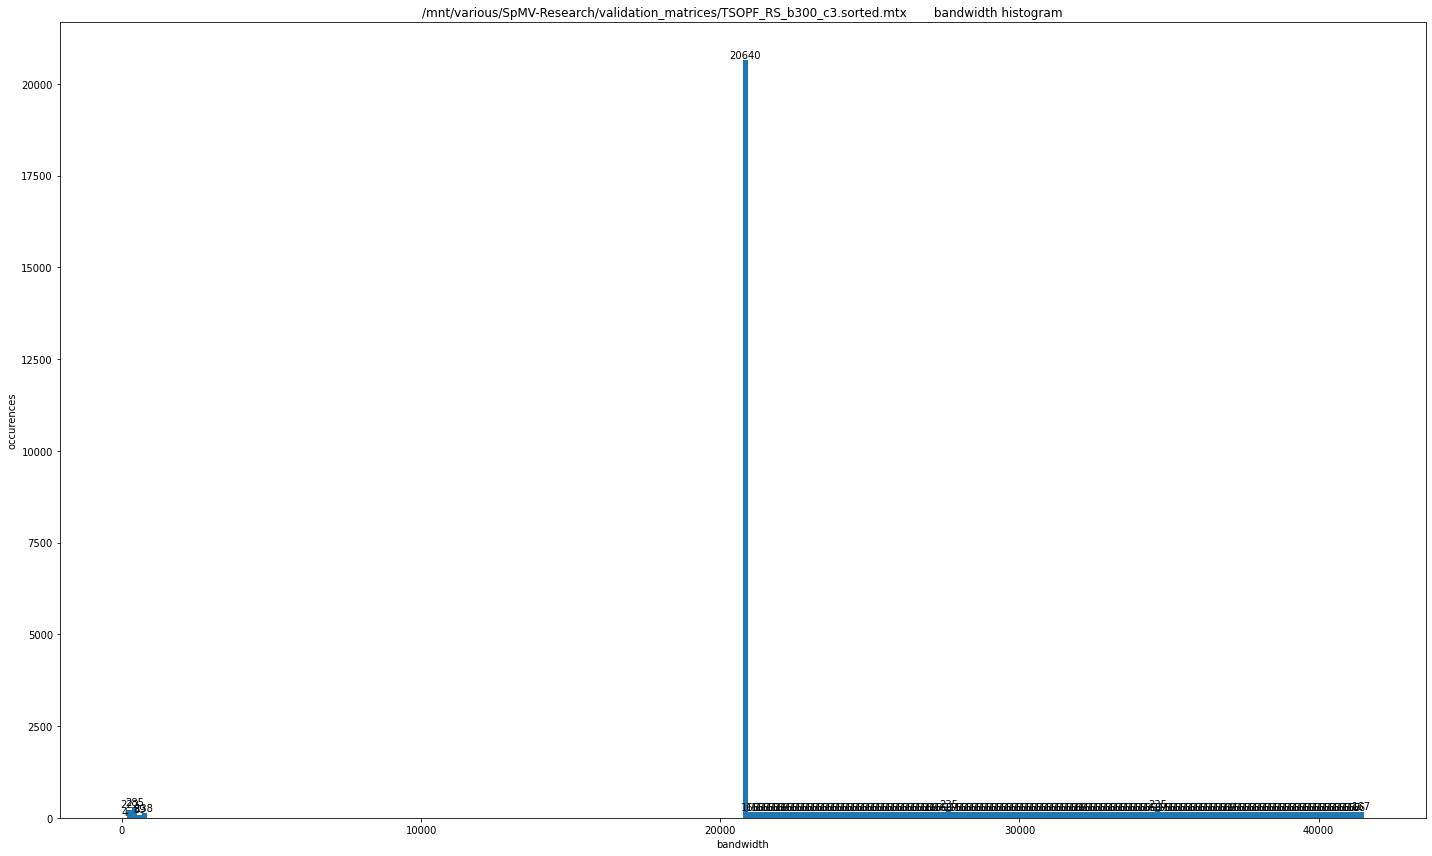

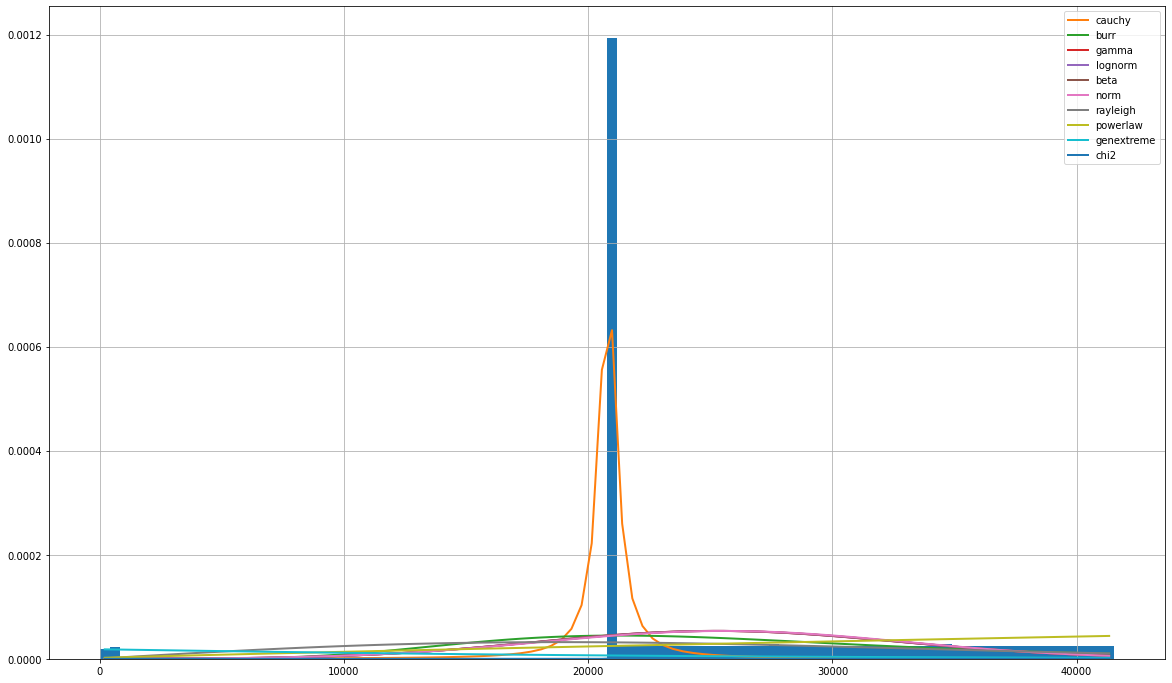

{'cauchy': {'loc': 20804.77200742187, 'scale': 436.3571773255194}}
------
crankseg_2.sorted.mtx :	dimensions (63838, 63838) / nnz 14148858 / mem footprint 162.164 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 260
nnz-row : min = 48 max = 3423 nr_bins = 260


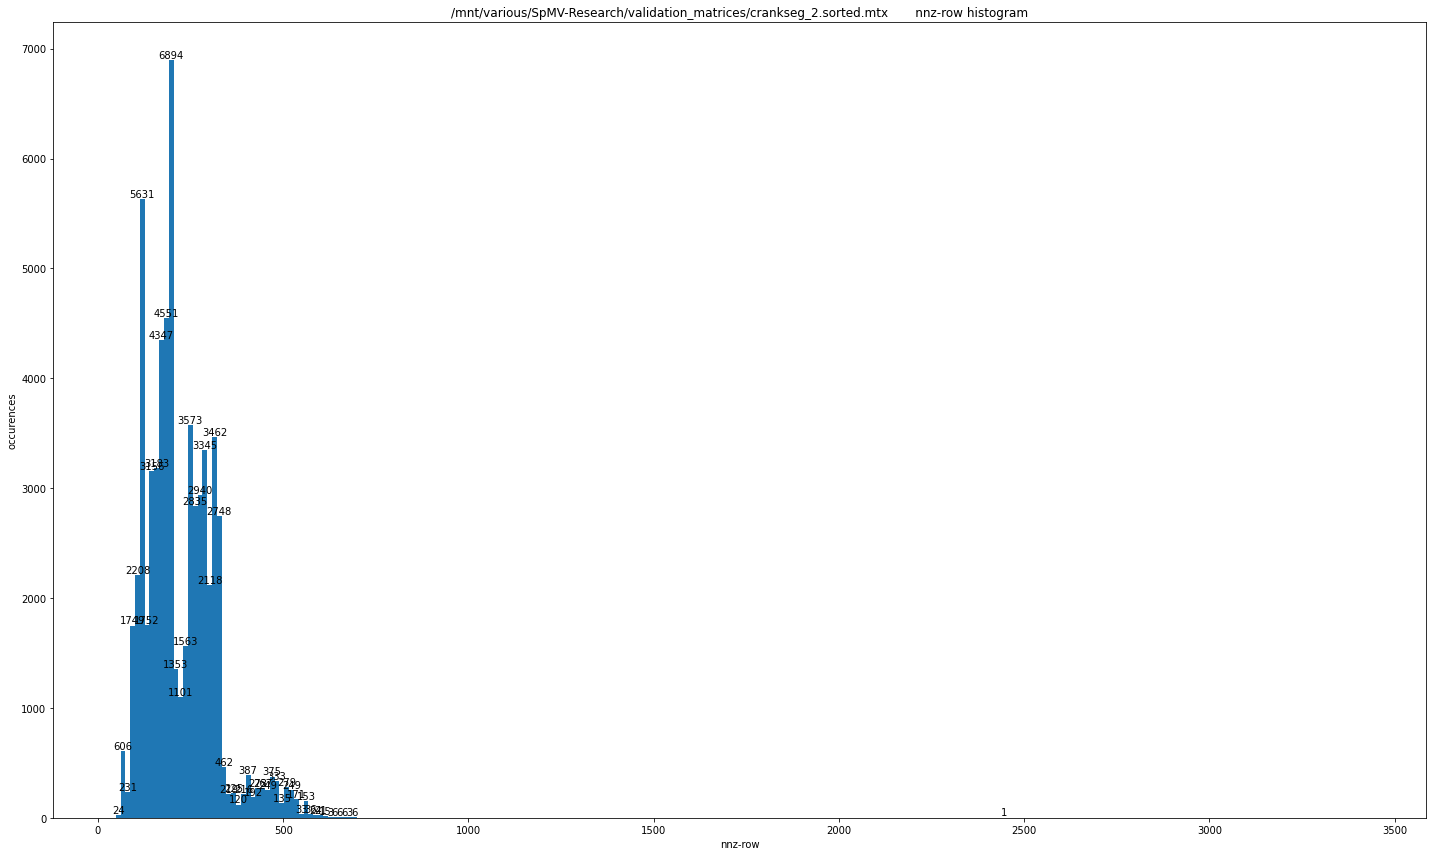

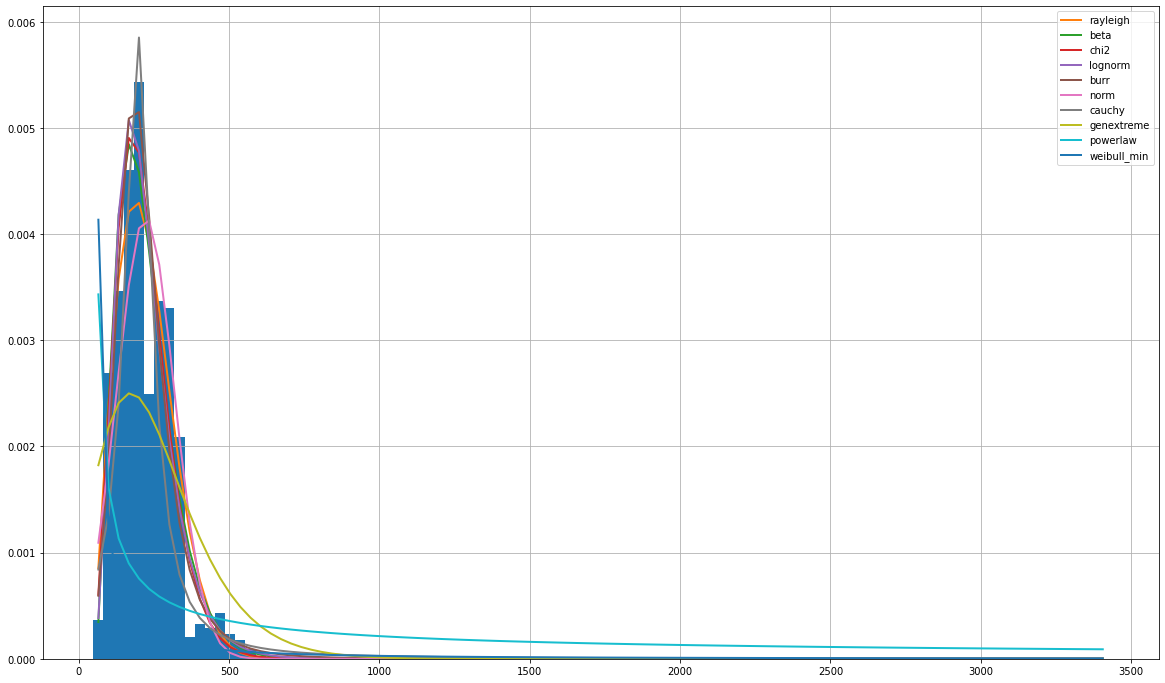

{'rayleigh': {'loc': 47.935062668155695, 'scale': 140.29344070227026}}
GOOD 251
bandwidth : min = 10146 max = 62040 nr_bins = 251


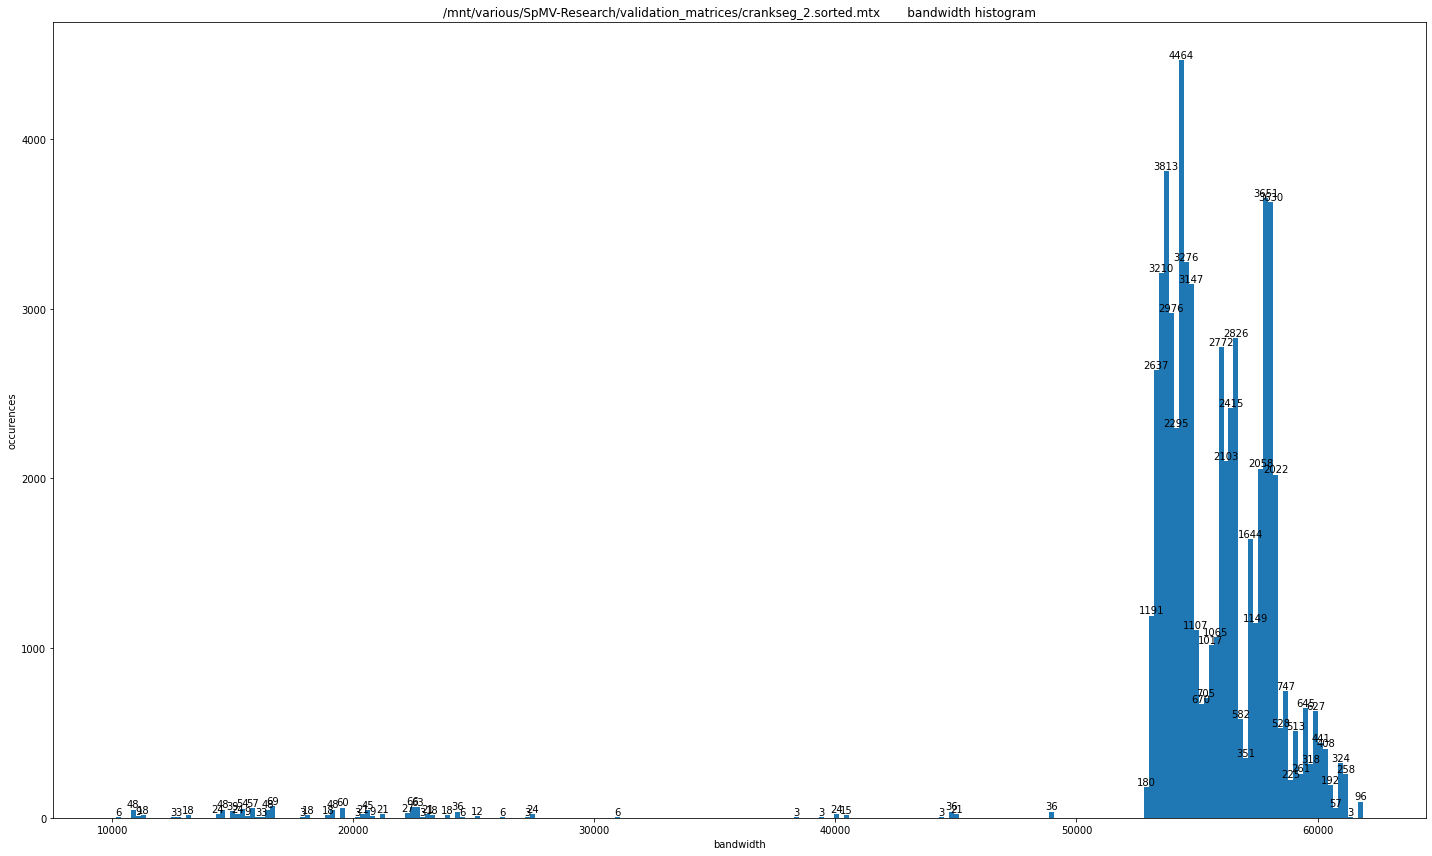

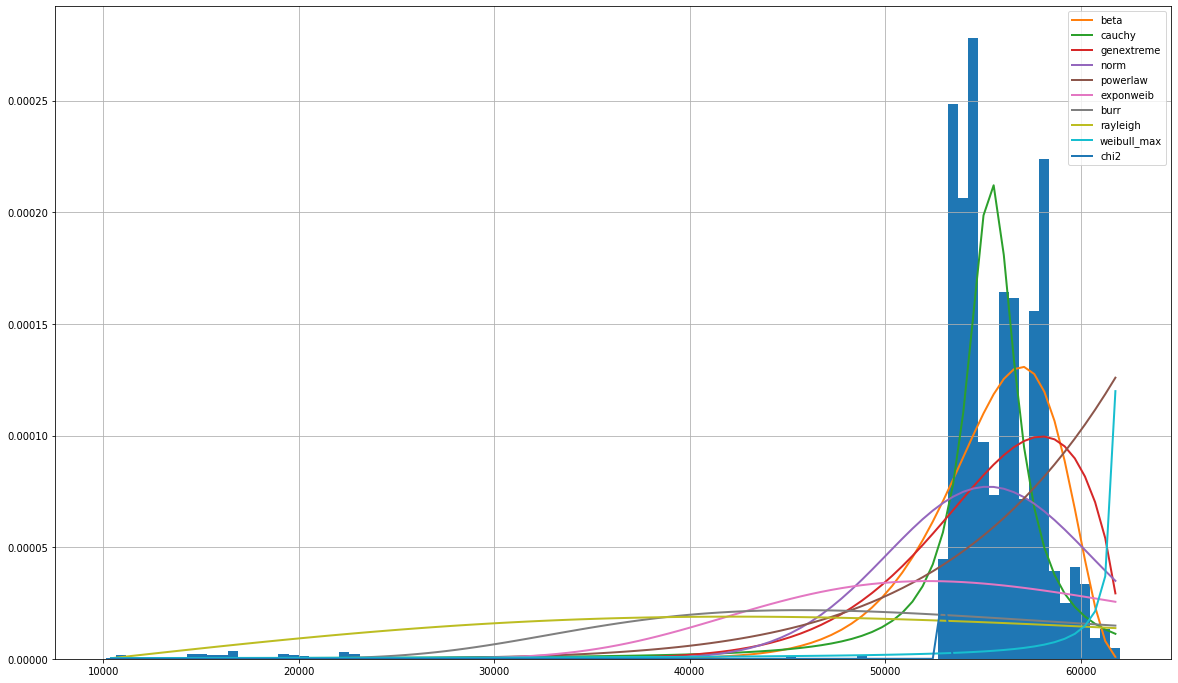

{'beta': {'a': 1148981597.2785735, 'b': 4.041312468843078, 'loc': -1954536625094.0059, 'scale': 1954536687257.001}}
------
pwtk.sorted.mtx :	dimensions (217918, 217918) / nnz 11634424 / mem footprint 133.977 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 180
nnz-row : min = 2 max = 180 nr_bins = 180


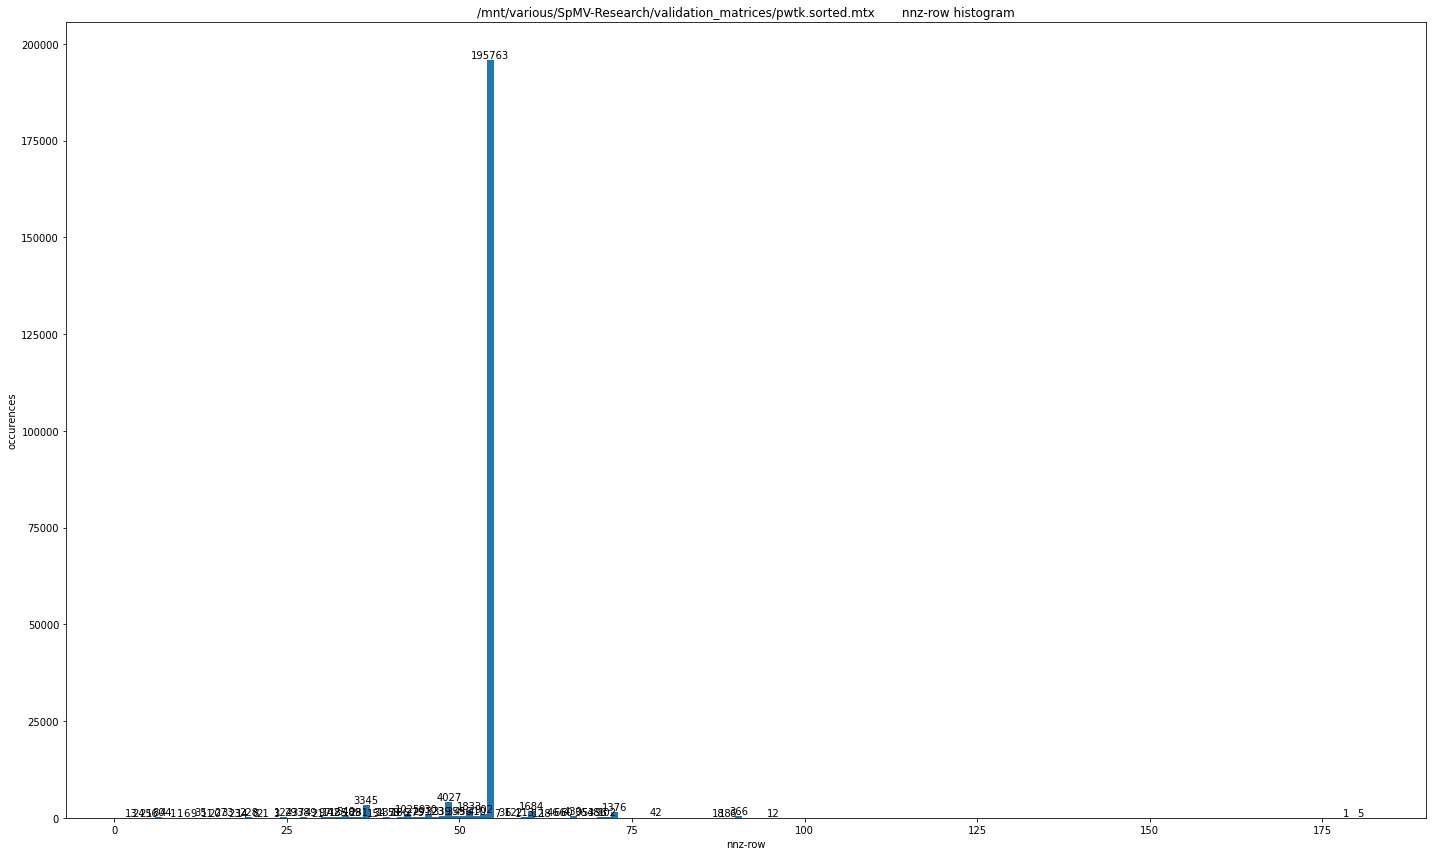

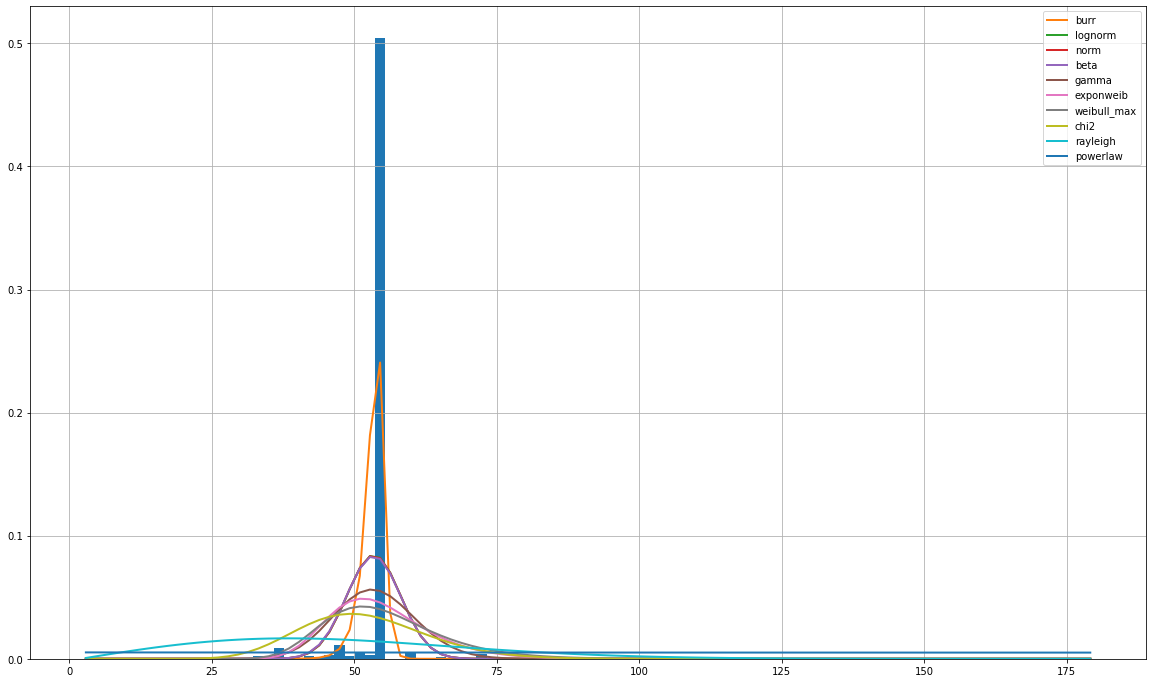

{'burr': {'c': 637.4228534736471, 'd': 0.36695848356823313, 'loc': -342.3568154858766, 'scale': 396.98007875516214}}
GOOD 251
bandwidth : min = 2 max = 189337 nr_bins = 251


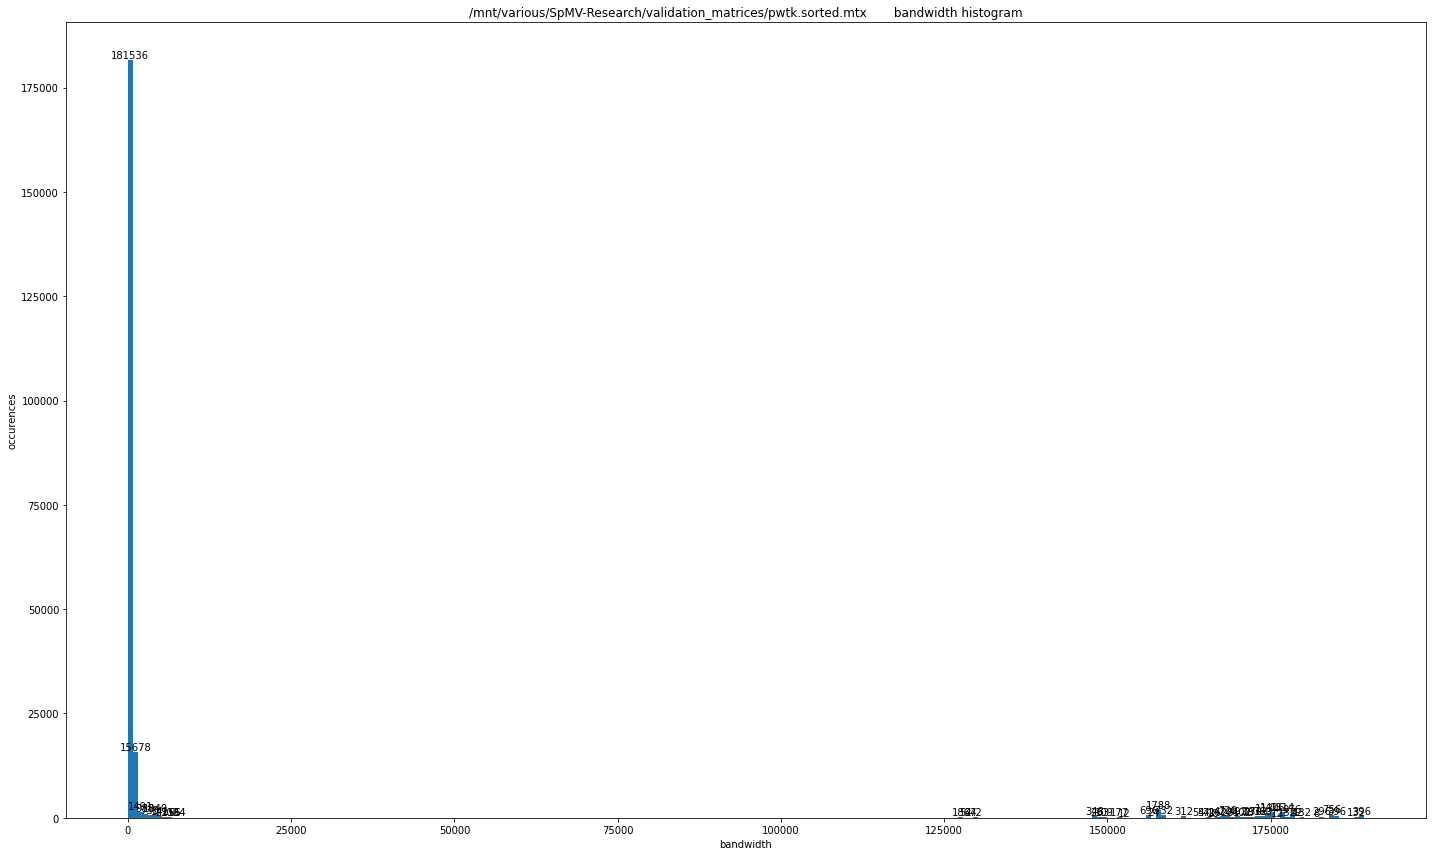

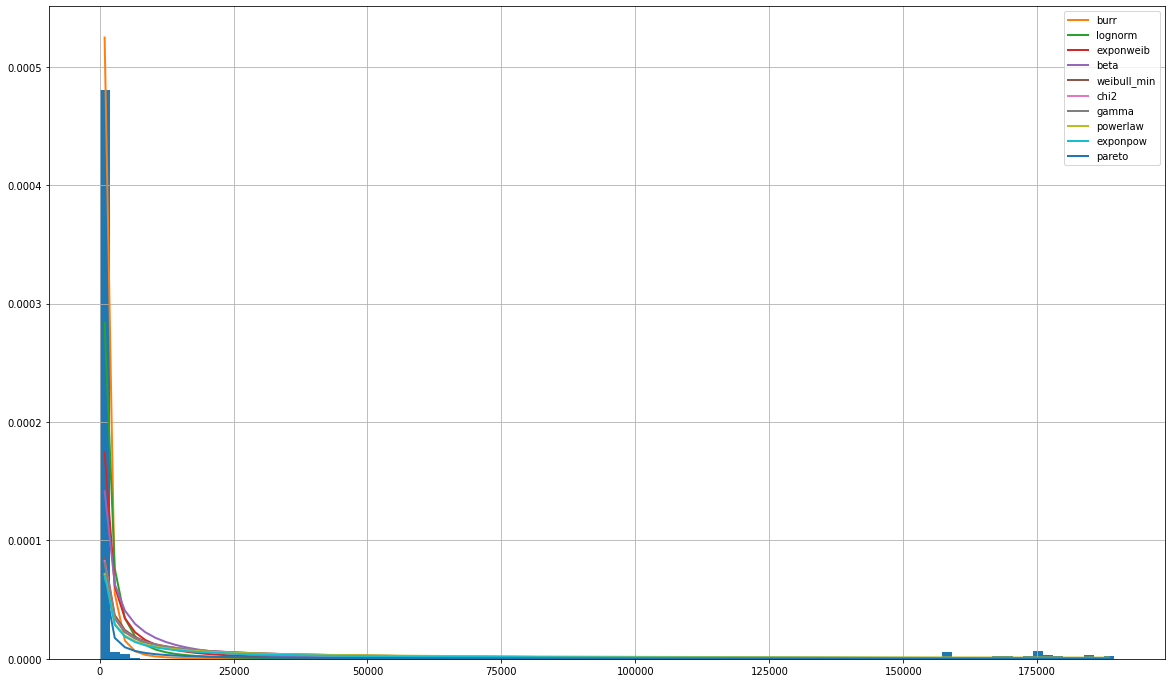

{'burr': {'c': 1.6558314379246202, 'd': 3.2289321355611165, 'loc': -2.551166933212632, 'scale': 366.9429621349034}}
------
rail4284.real.mtx :	dimensions (4284, 1096894) / nnz 11284032 / mem footprint 129.152 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 251
nnz-row : min = 2 max = 56182 nr_bins = 251


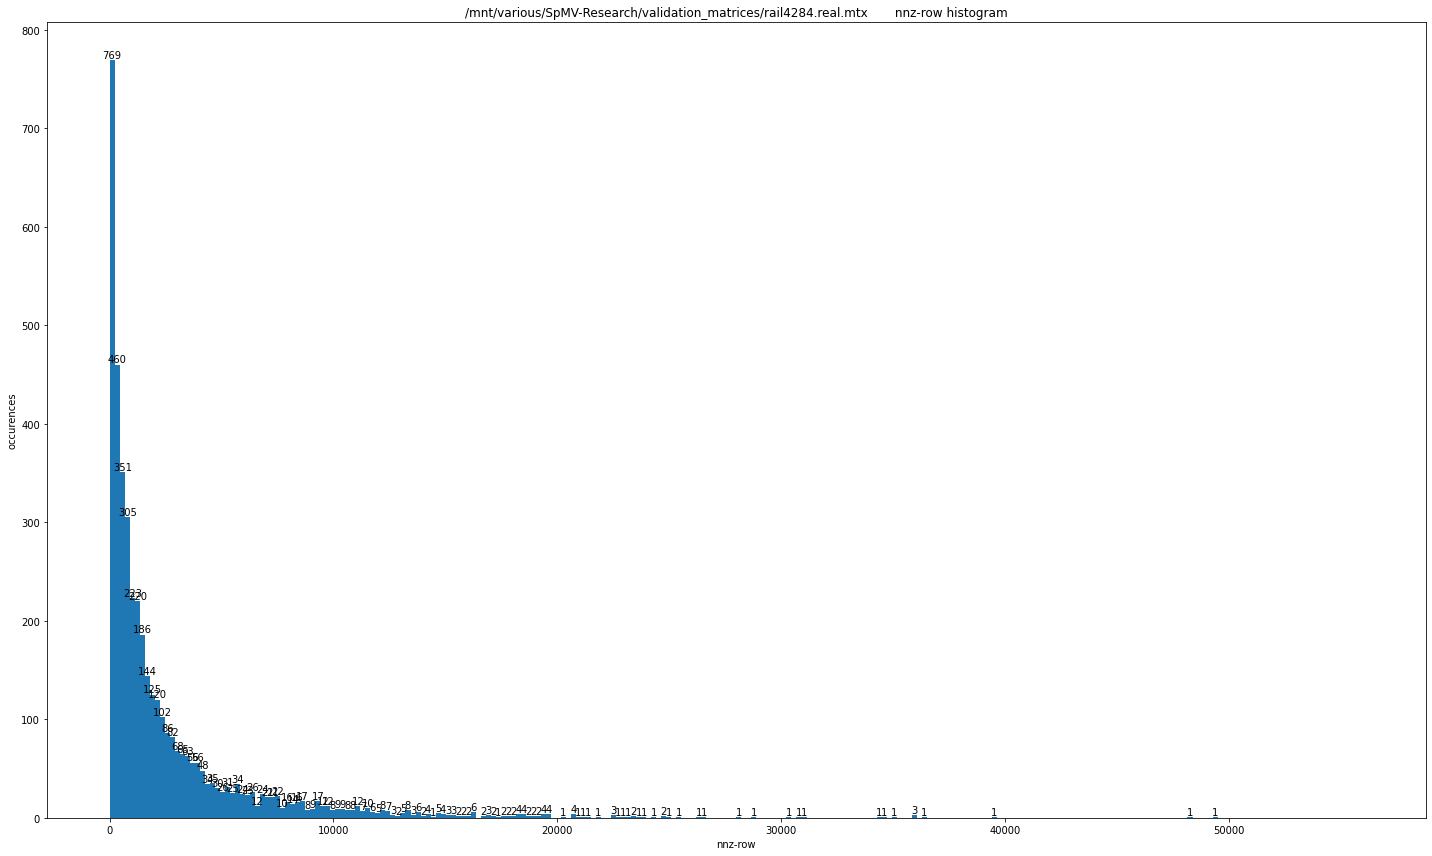

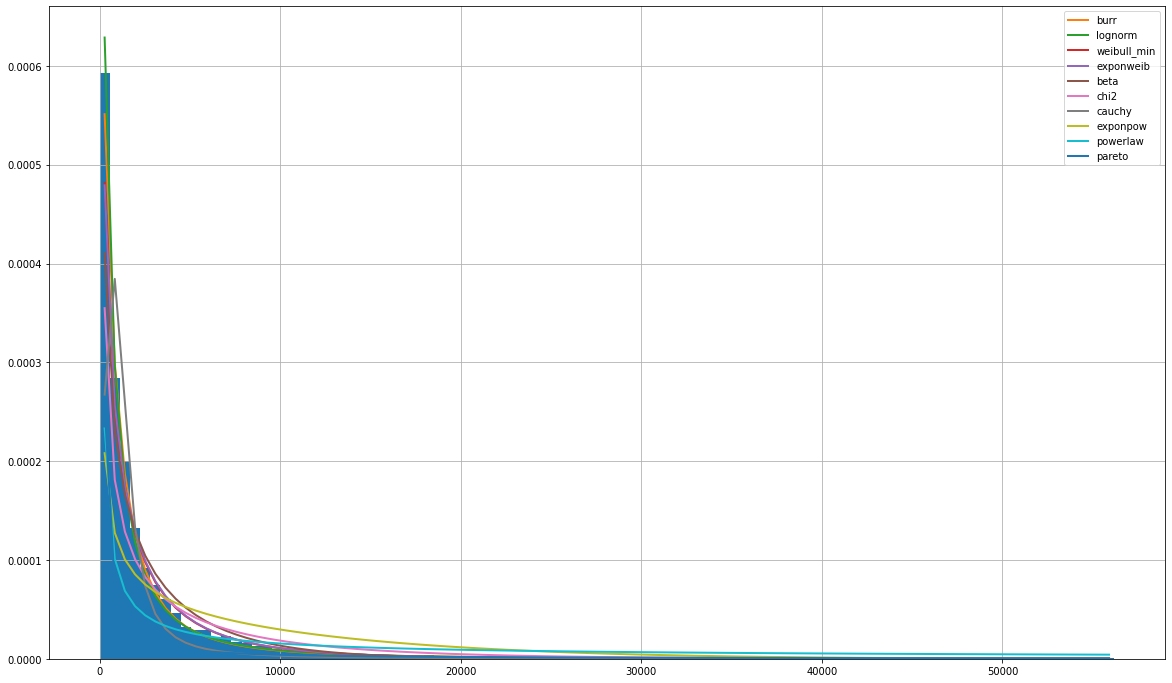

{'burr': {'c': 1.194548585869244, 'd': 0.6937374206679359, 'loc': 1.9961185224811, 'scale': 1697.611958858677}}
GOOD 251
bandwidth : min = 18341 max = 1096766 nr_bins = 251


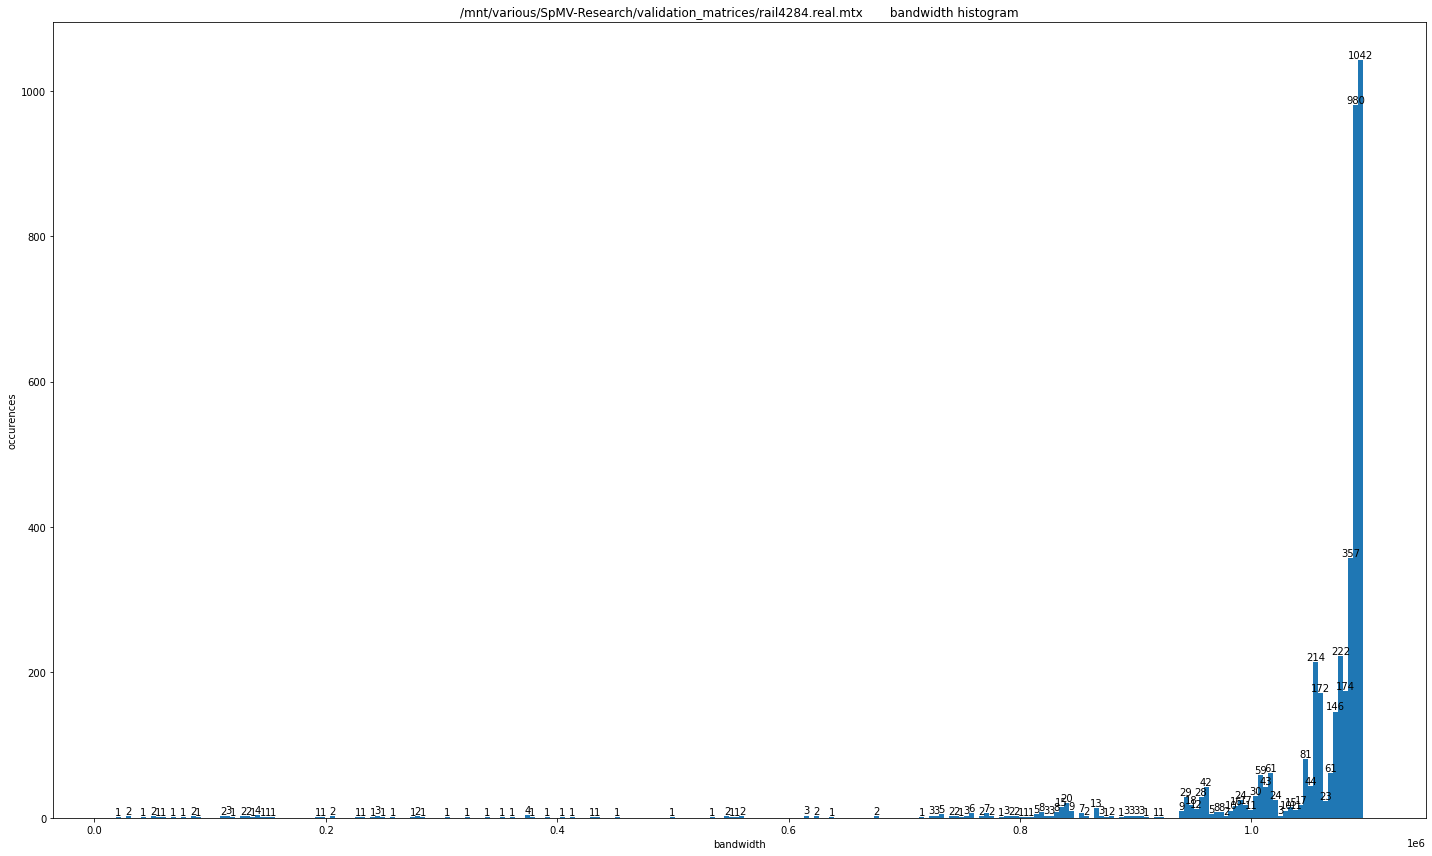

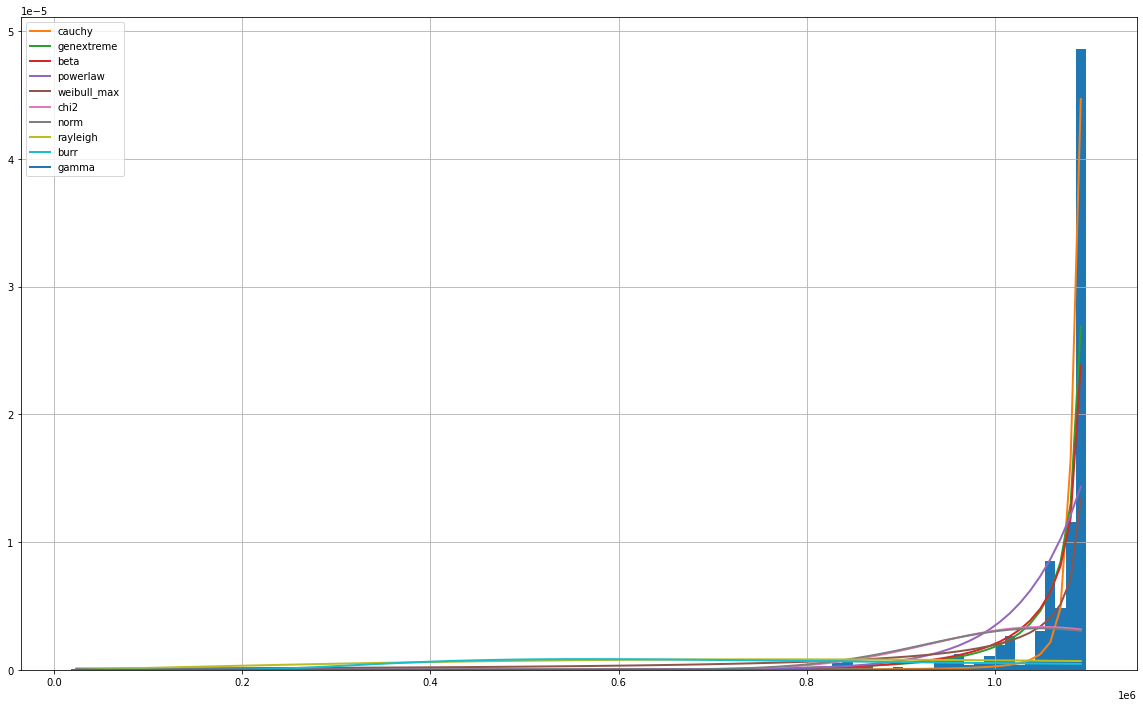

{'cauchy': {'loc': 1089821.5992035577, 'scale': 6769.003737400719}}
------
Chebyshev4.sorted.mtx :	dimensions (68121, 68121) / nnz 5377761 / mem footprint 61.803 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 251
nnz-row : min = 9 max = 68121 nr_bins = 251


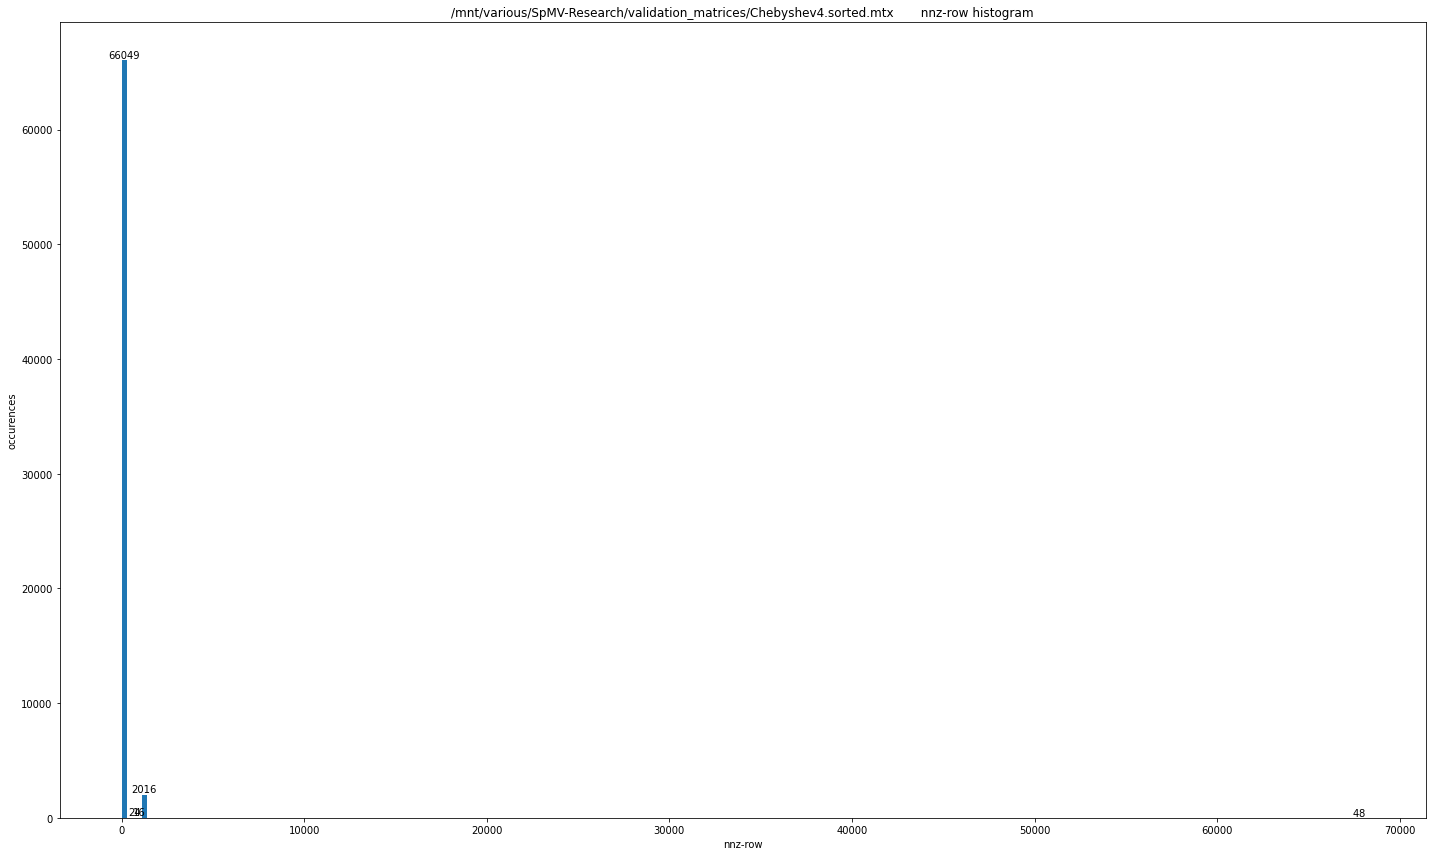

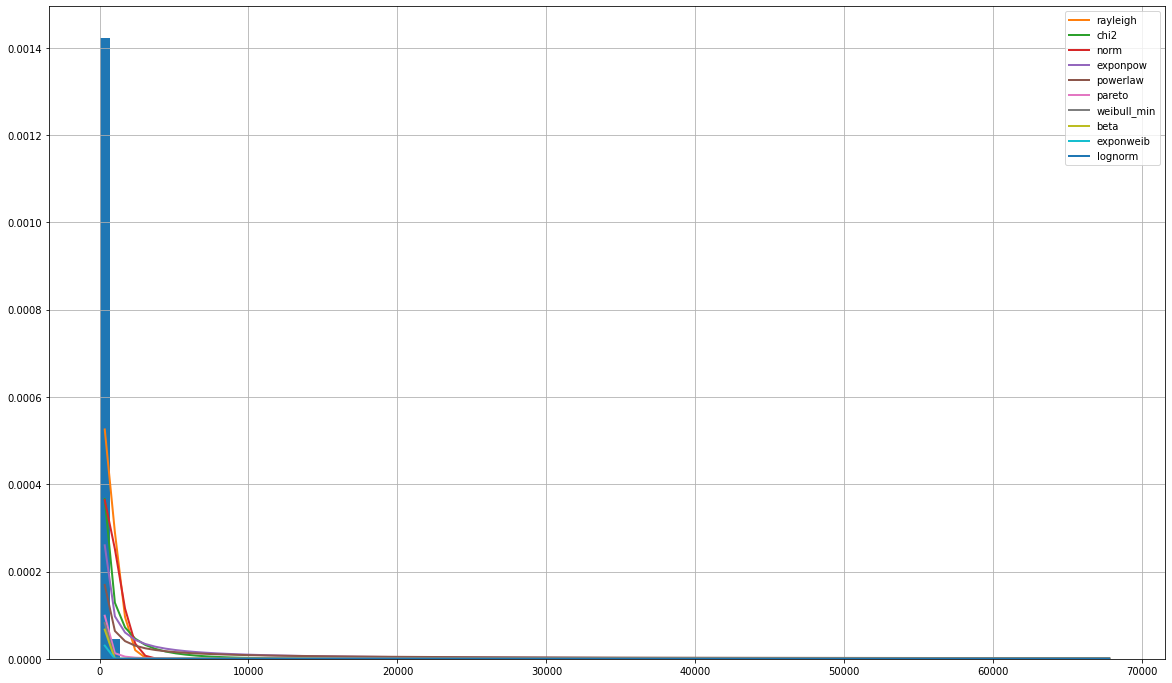

{'rayleigh': {'loc': -1019.5556335456442, 'scale': 1080.1288590881118}}
GOOD 251
bandwidth : min = 1048 max = 68120 nr_bins = 251


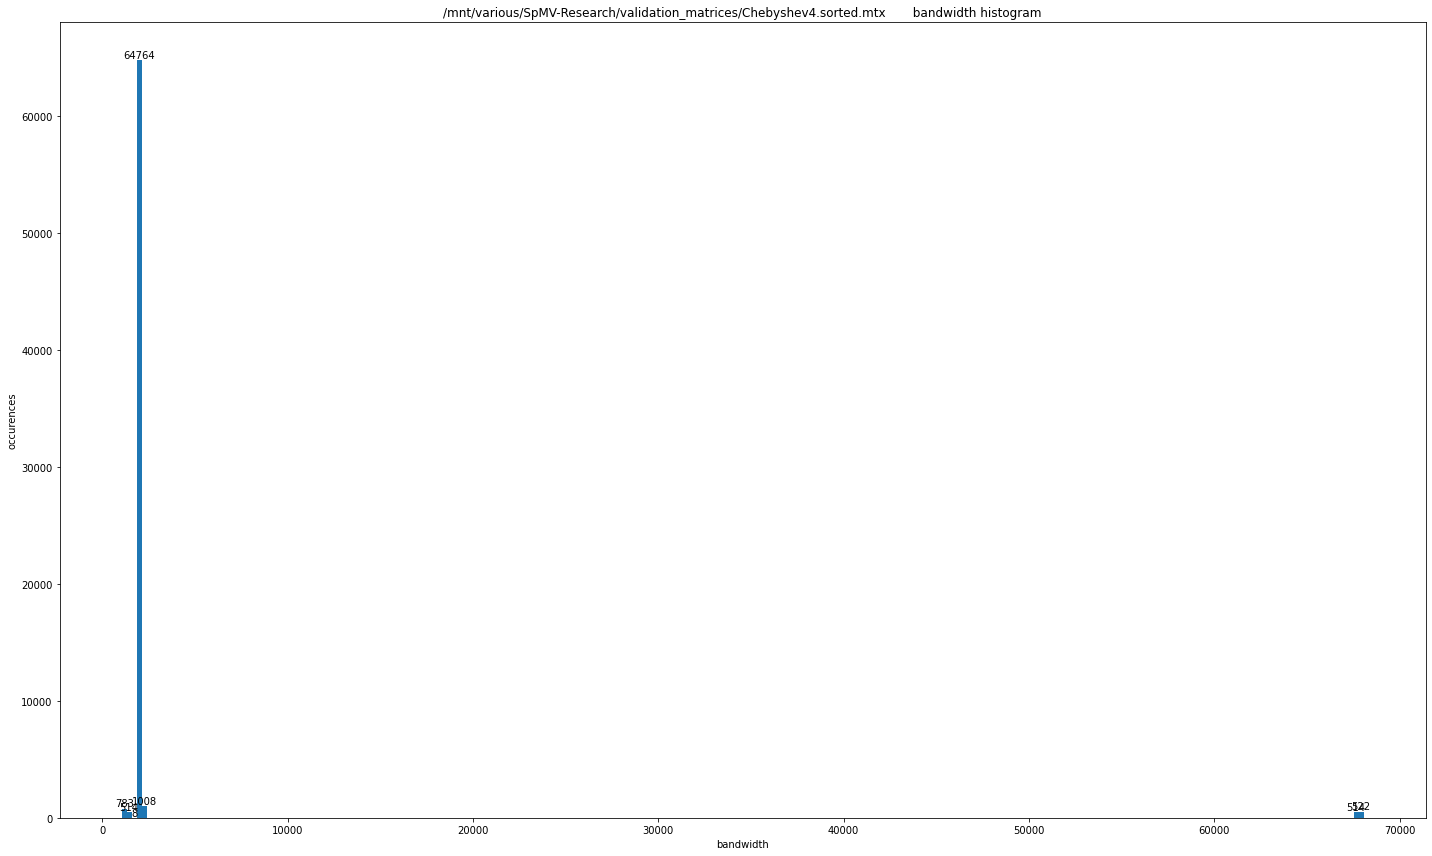

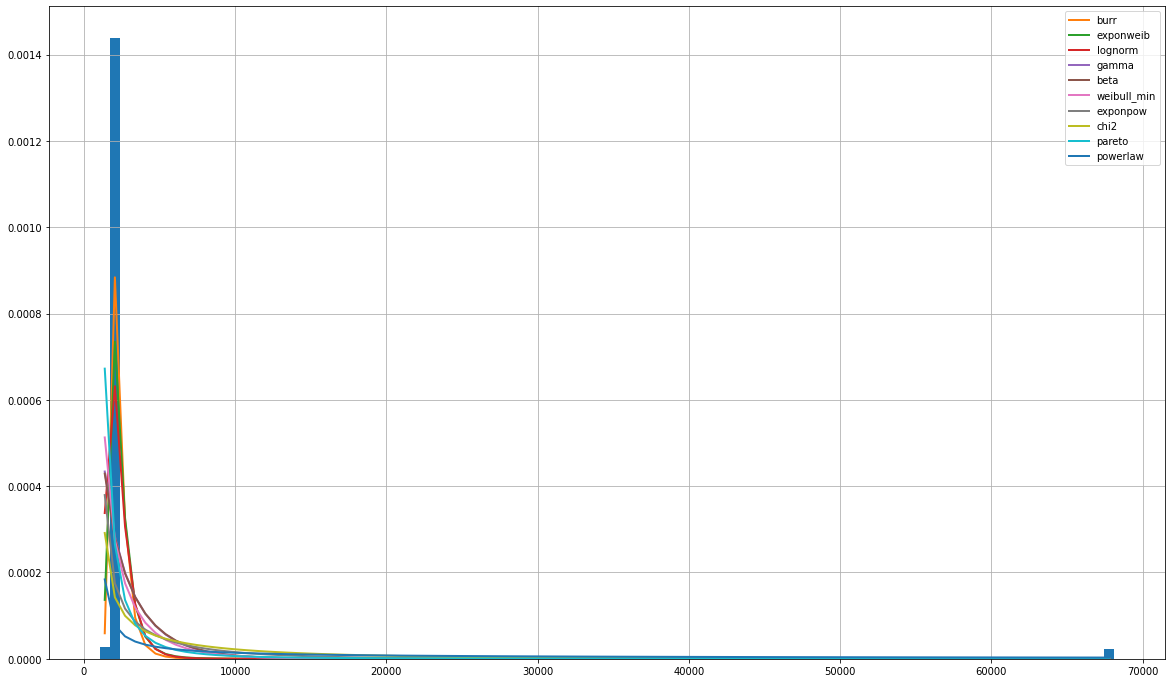

{'burr': {'c': 6.113008734571536, 'd': 180035.2098345859, 'loc': -466.9761094510742, 'scale': 340.51801044375657}}
------
in-2004.sorted.mtx :	dimensions (1382908, 1382908) / nnz 16917053 / mem footprint 198.876 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 251
nnz-row : min = 0 max = 7753 nr_bins = 251


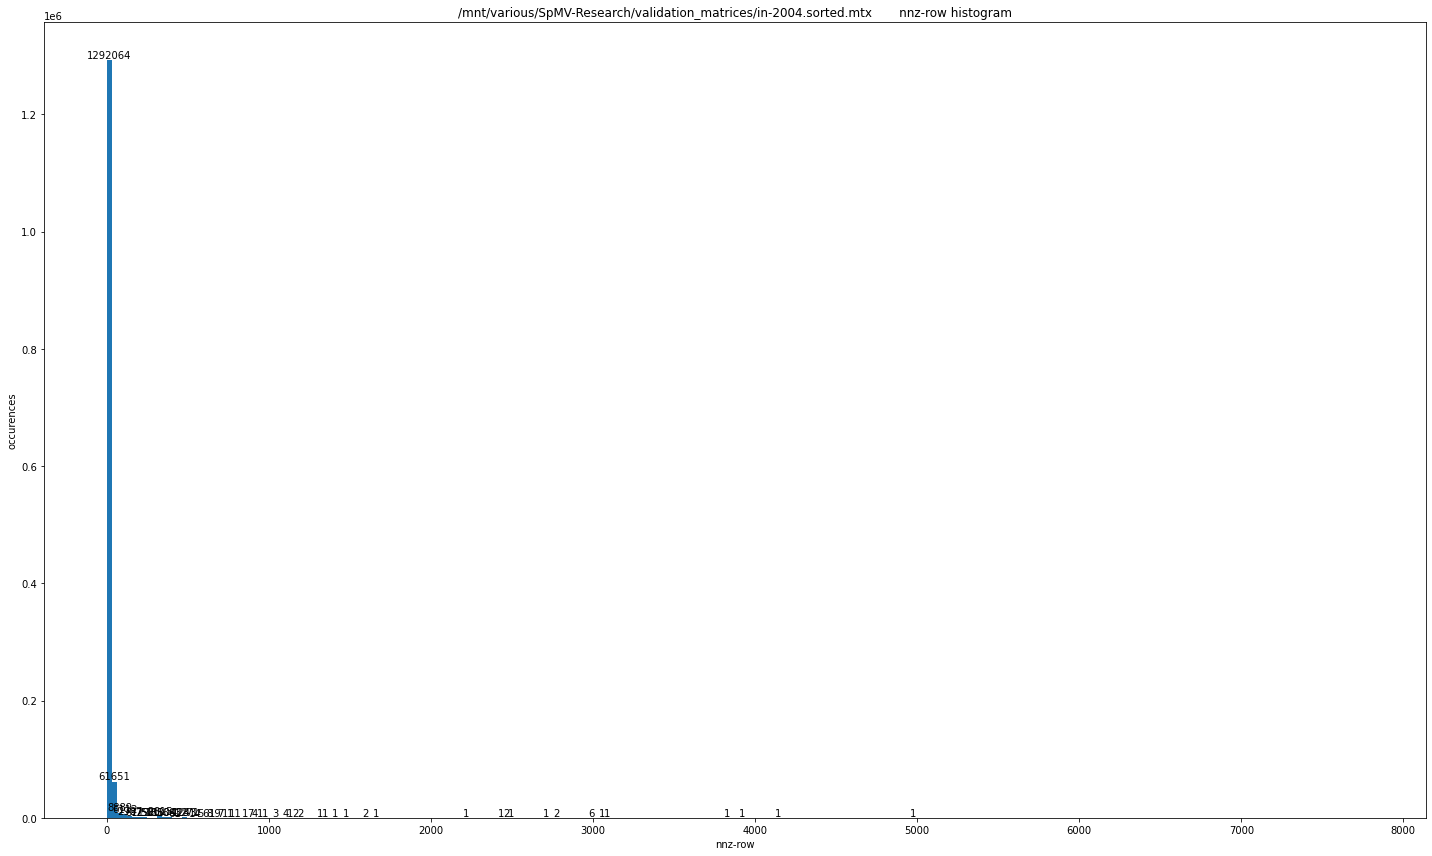

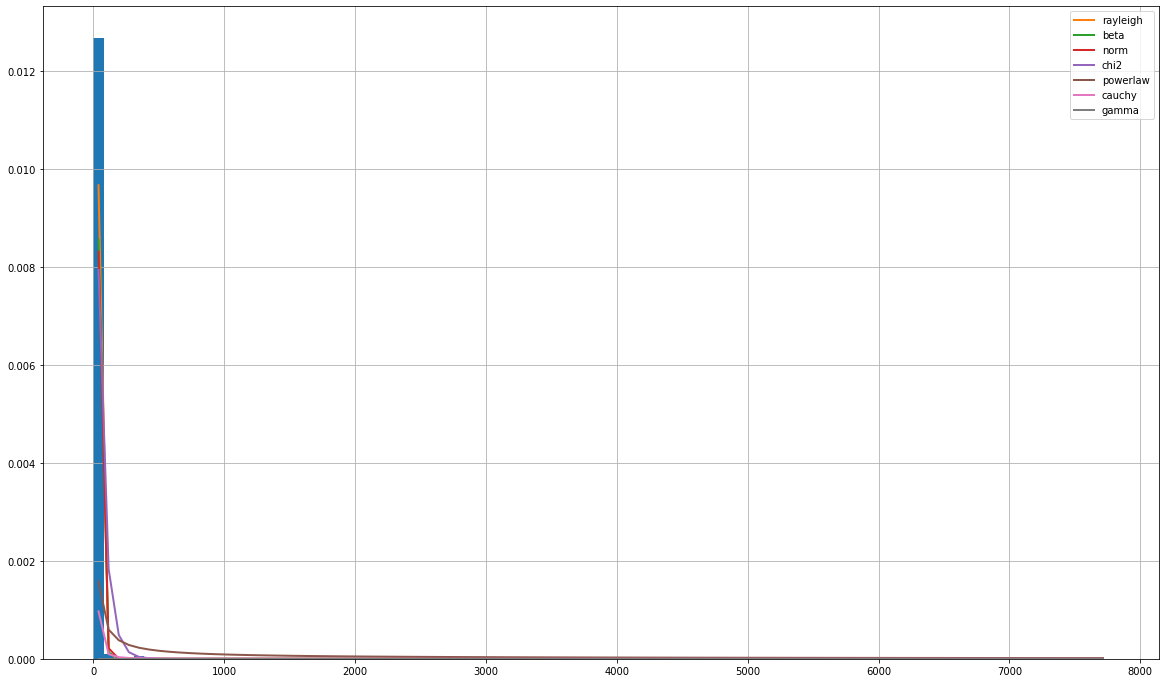

{'rayleigh': {'loc': -30.591212107511495, 'scale': 40.12470996527448}}
GOOD 251
bandwidth : min = 0 max = 1353281 nr_bins = 251


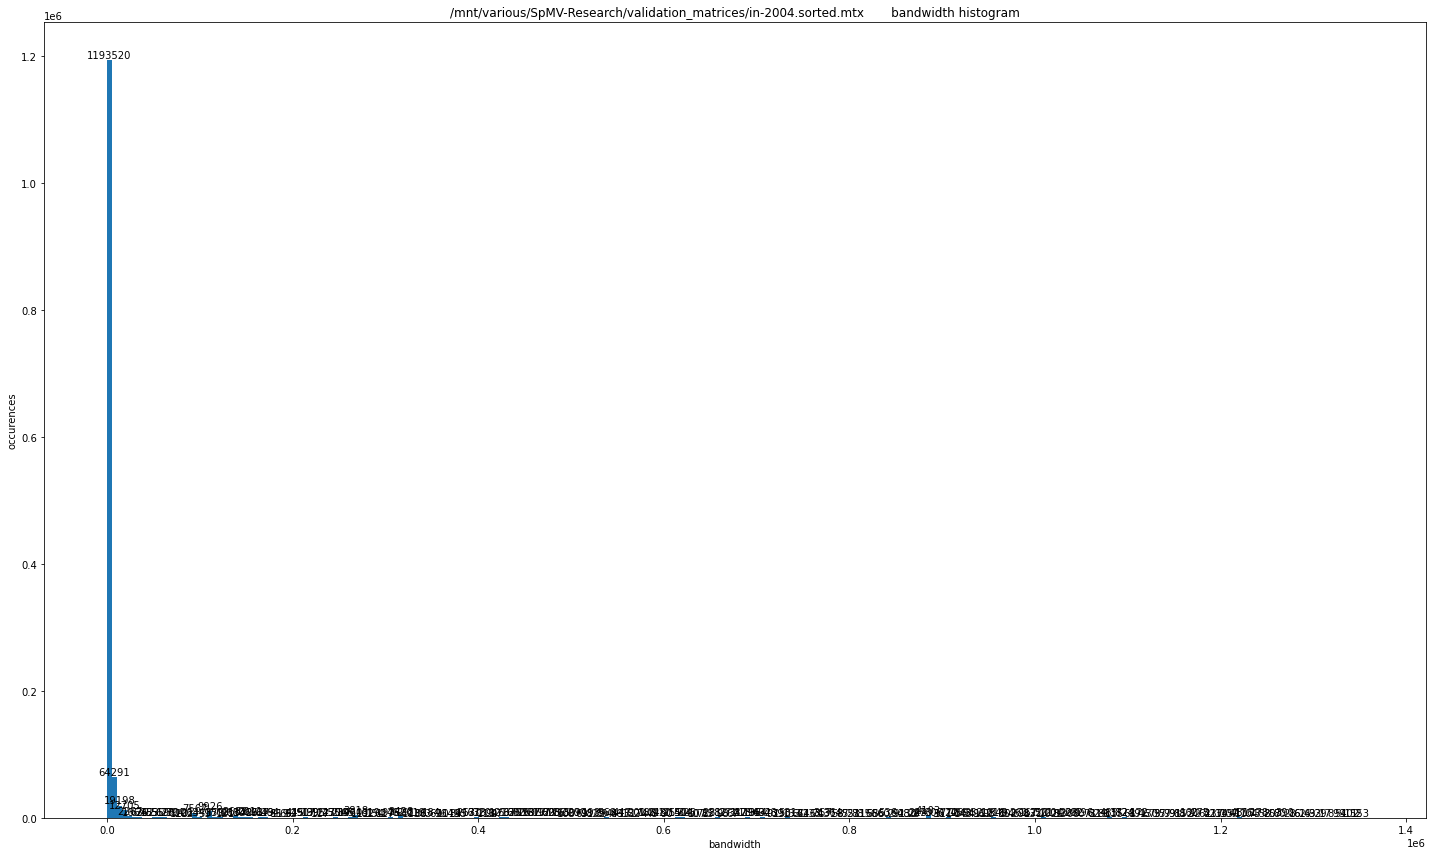

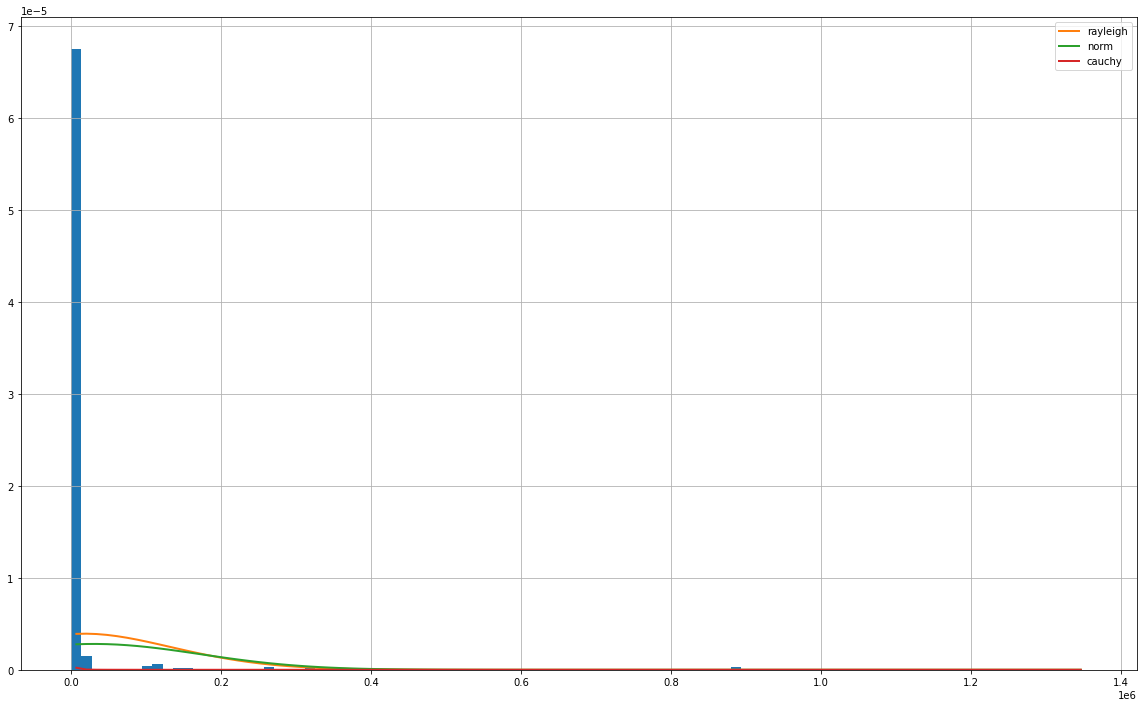

{'rayleigh': {'loc': -136269.78417369697, 'scale': 154380.00922166824}}
------
Si41Ge41H72.sorted.mtx :	dimensions (185639, 185639) / nnz 15011265 / mem footprint 172.498 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 326
nnz-row : min = 13 max = 662 nr_bins = 326


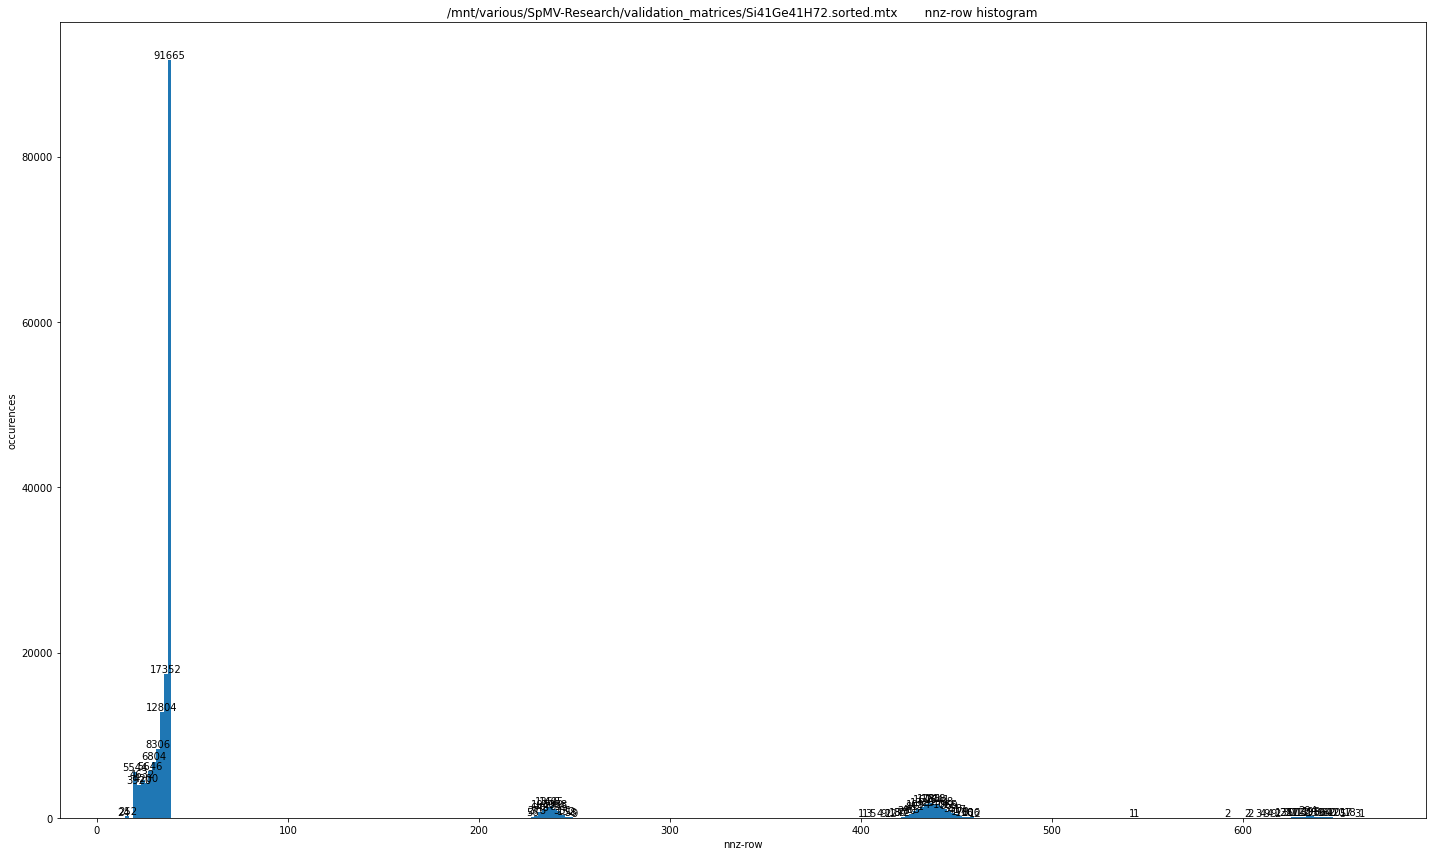

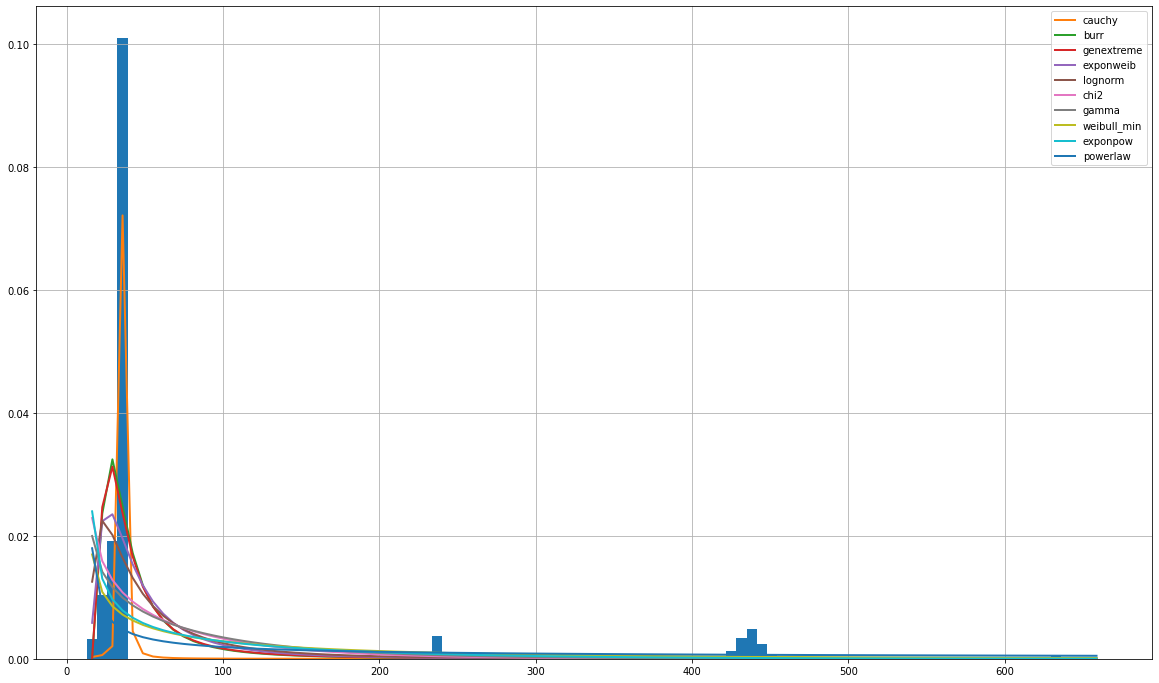

{'cauchy': {'loc': 36.96647039425149, 'scale': 0.3894581286296003}}
GOOD 251
bandwidth : min = 323 max = 54580 nr_bins = 251


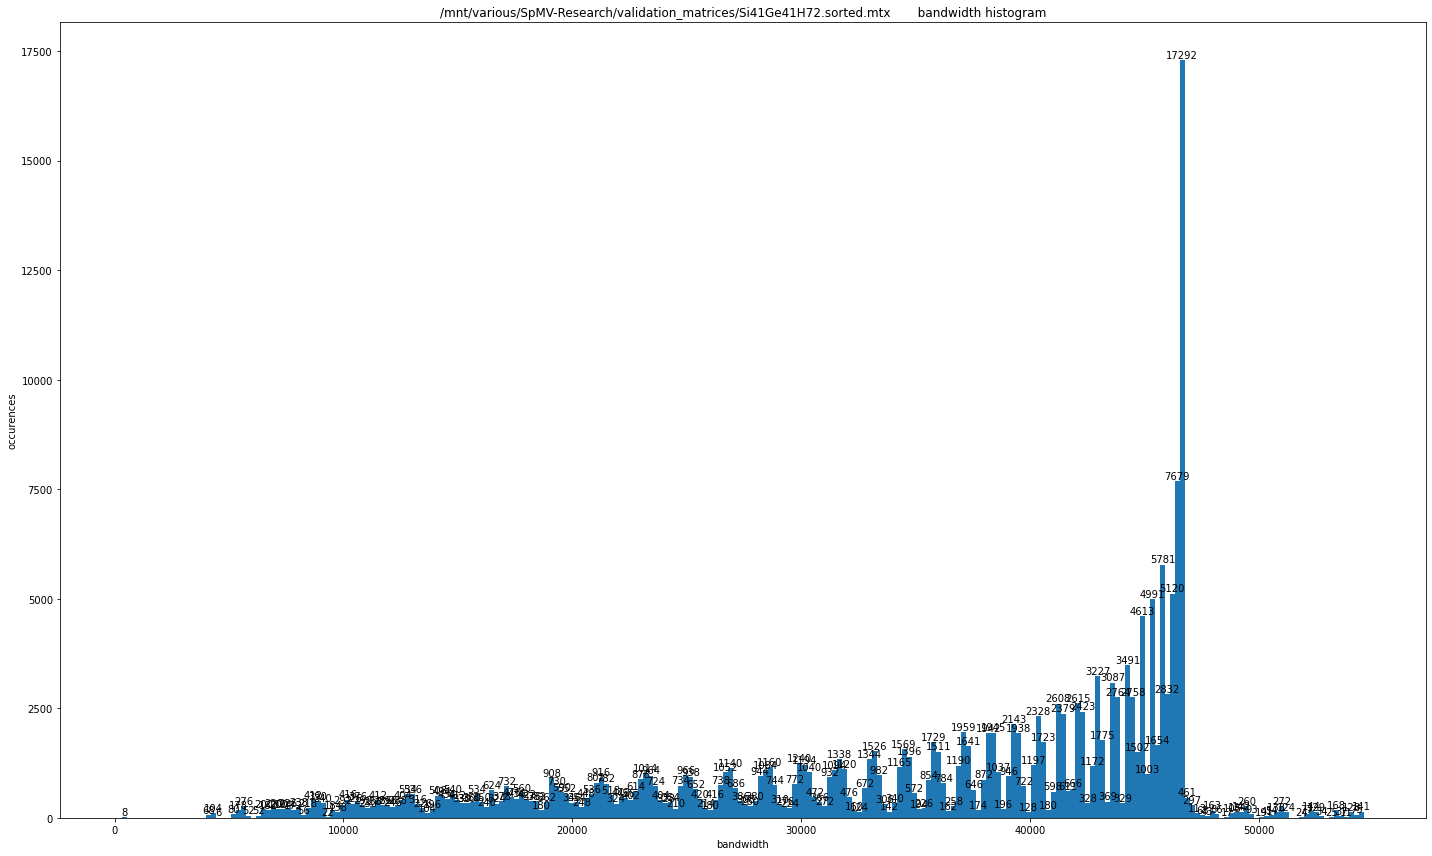

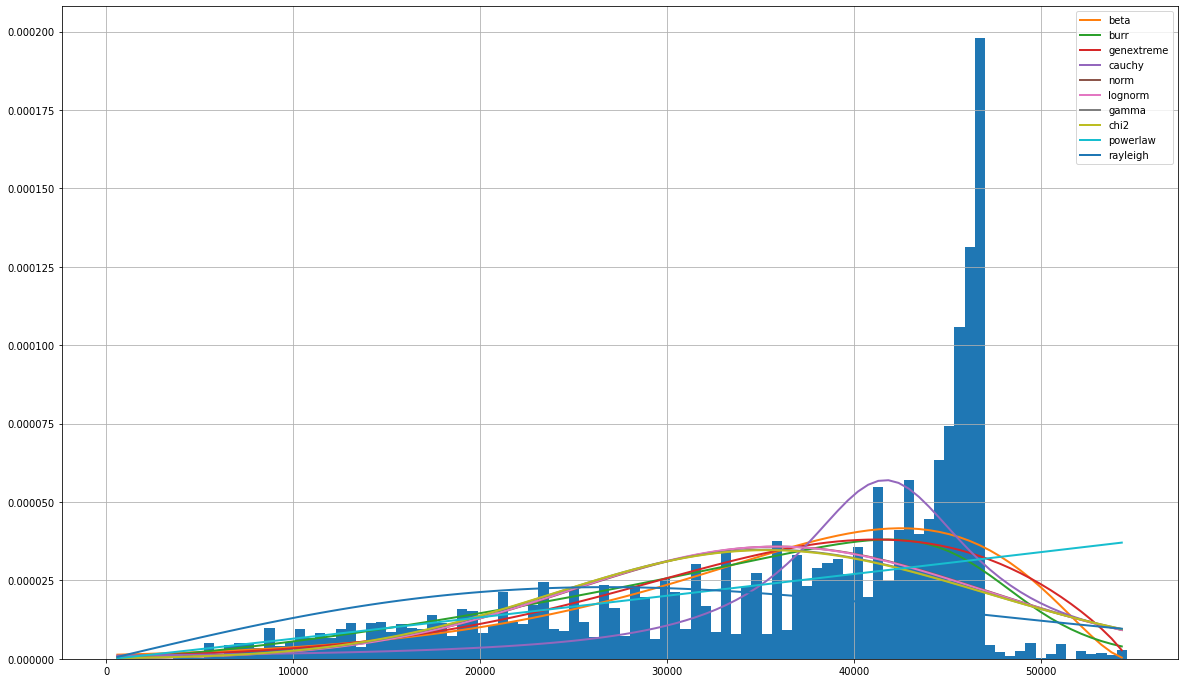

{'beta': {'a': 578749.5907862121, 'b': 2.7609580732837067, 'loc': -3987752035.7338448, 'scale': 3987806669.6575975}}
------
PR02R.sorted.mtx :	dimensions (161070, 161070) / nnz 8185136 / mem footprint 94.286 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 93
nnz-row : min = 1 max = 92 nr_bins = 93


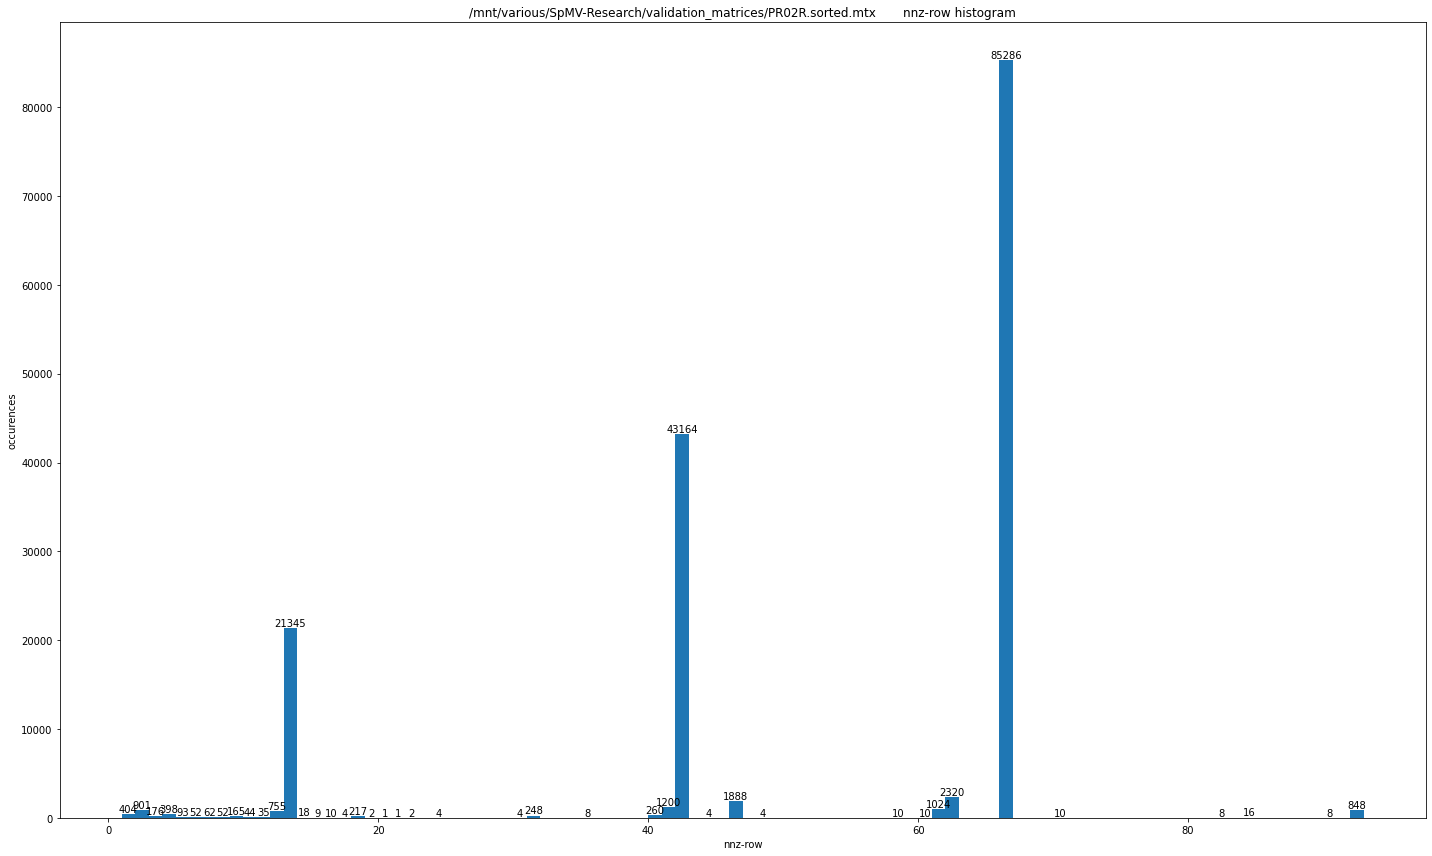

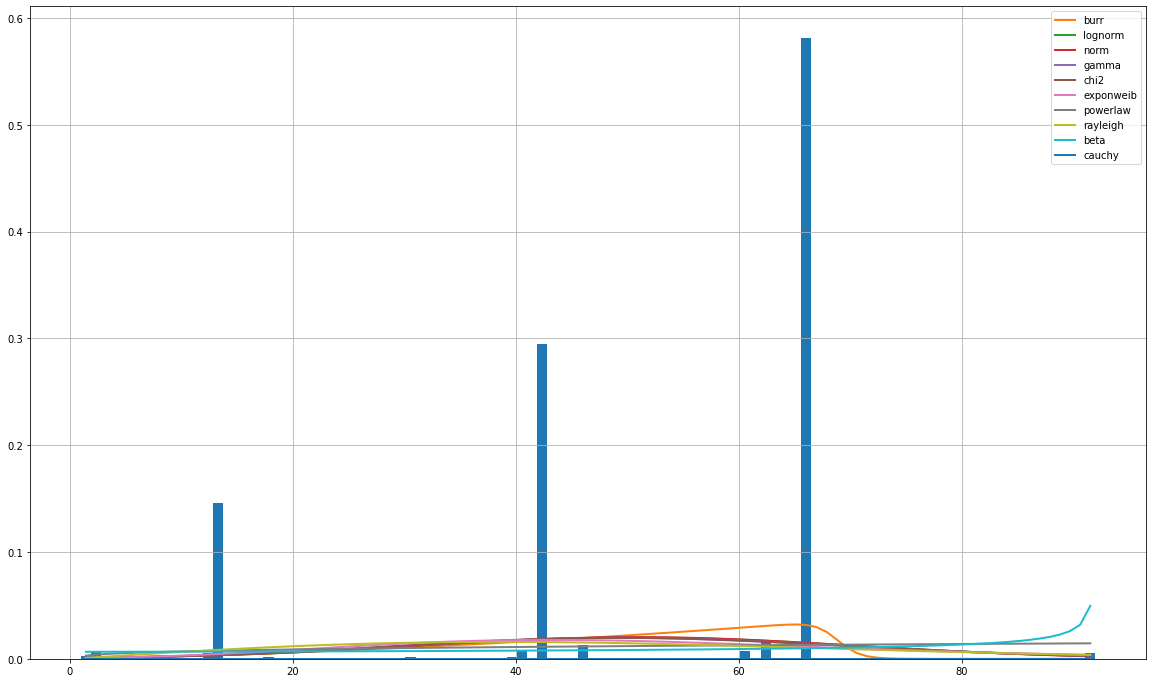

{'burr': {'c': 75.0420577835597, 'd': 0.03624280643338576, 'loc': -6.840127267947642, 'scale': 75.70037432705232}}
GOOD 251
bandwidth : min = 0 max = 86727 nr_bins = 251


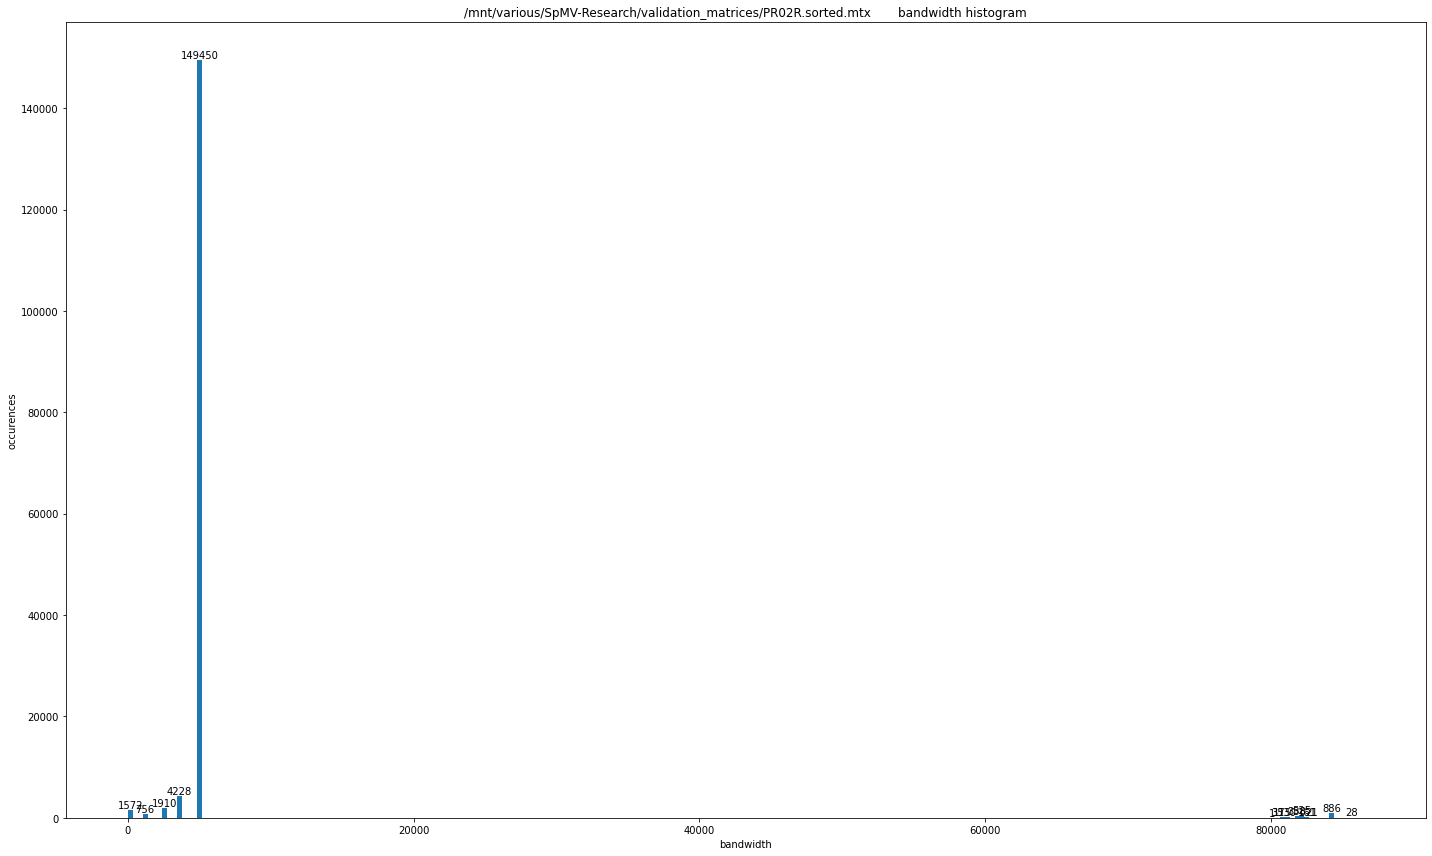

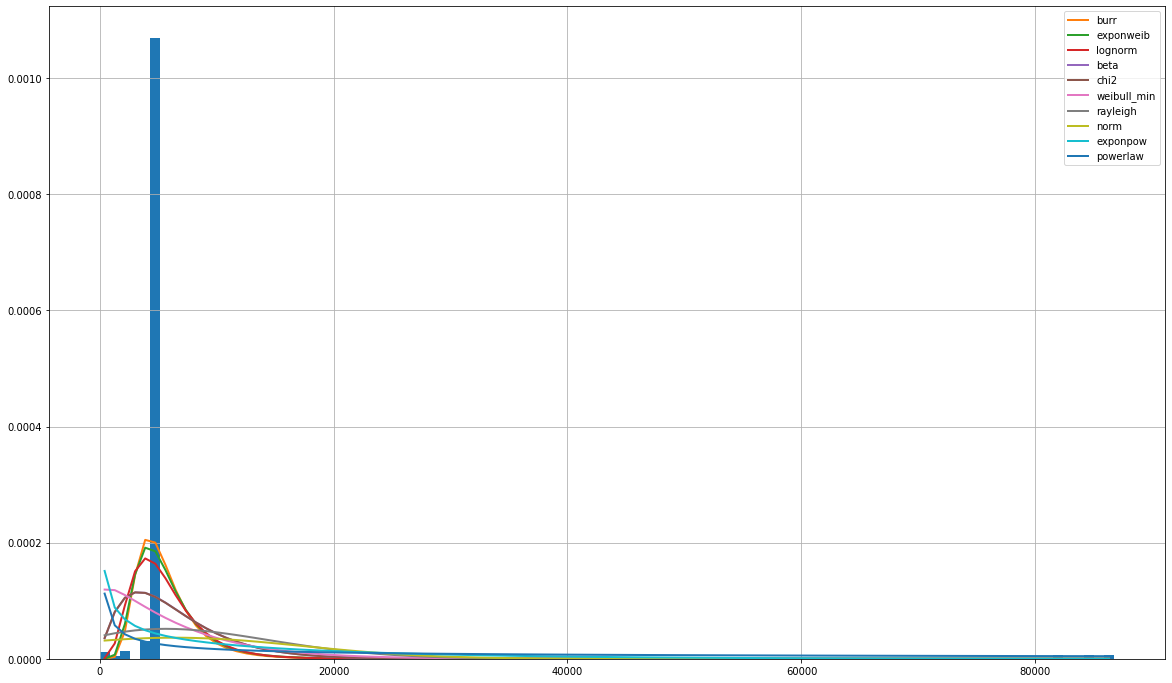

{'burr': {'c': 8.070053057210792, 'd': 594.4182890539779, 'loc': -9824.764128120723, 'scale': 6464.943914502075}}
------
eu-2005.sorted.mtx :	dimensions (862664, 862664) / nnz 19235140 / mem footprint 223.42 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 259
nnz-row : min = 0 max = 6985 nr_bins = 259


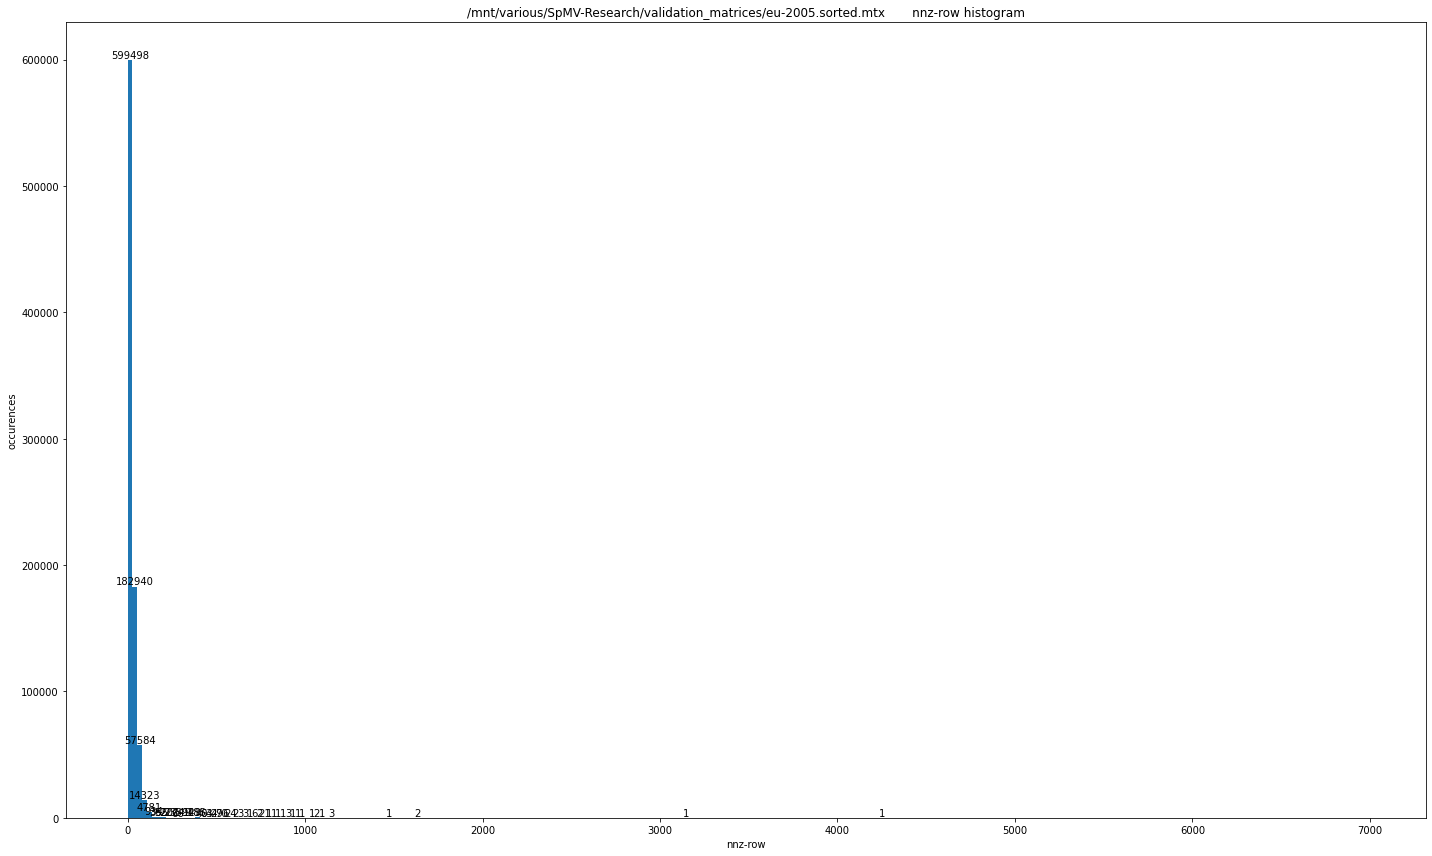

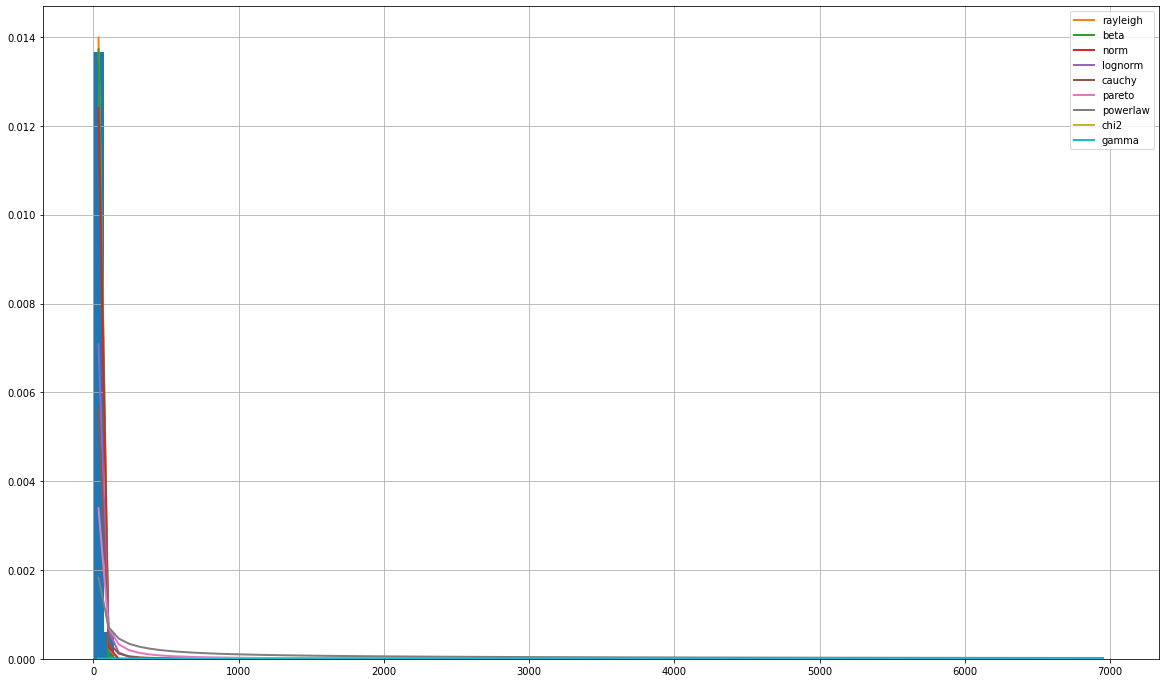

{'rayleigh': {'loc': -17.295924555241612, 'scale': 34.843072136353825}}
GOOD 251
bandwidth : min = 0 max = 850640 nr_bins = 251


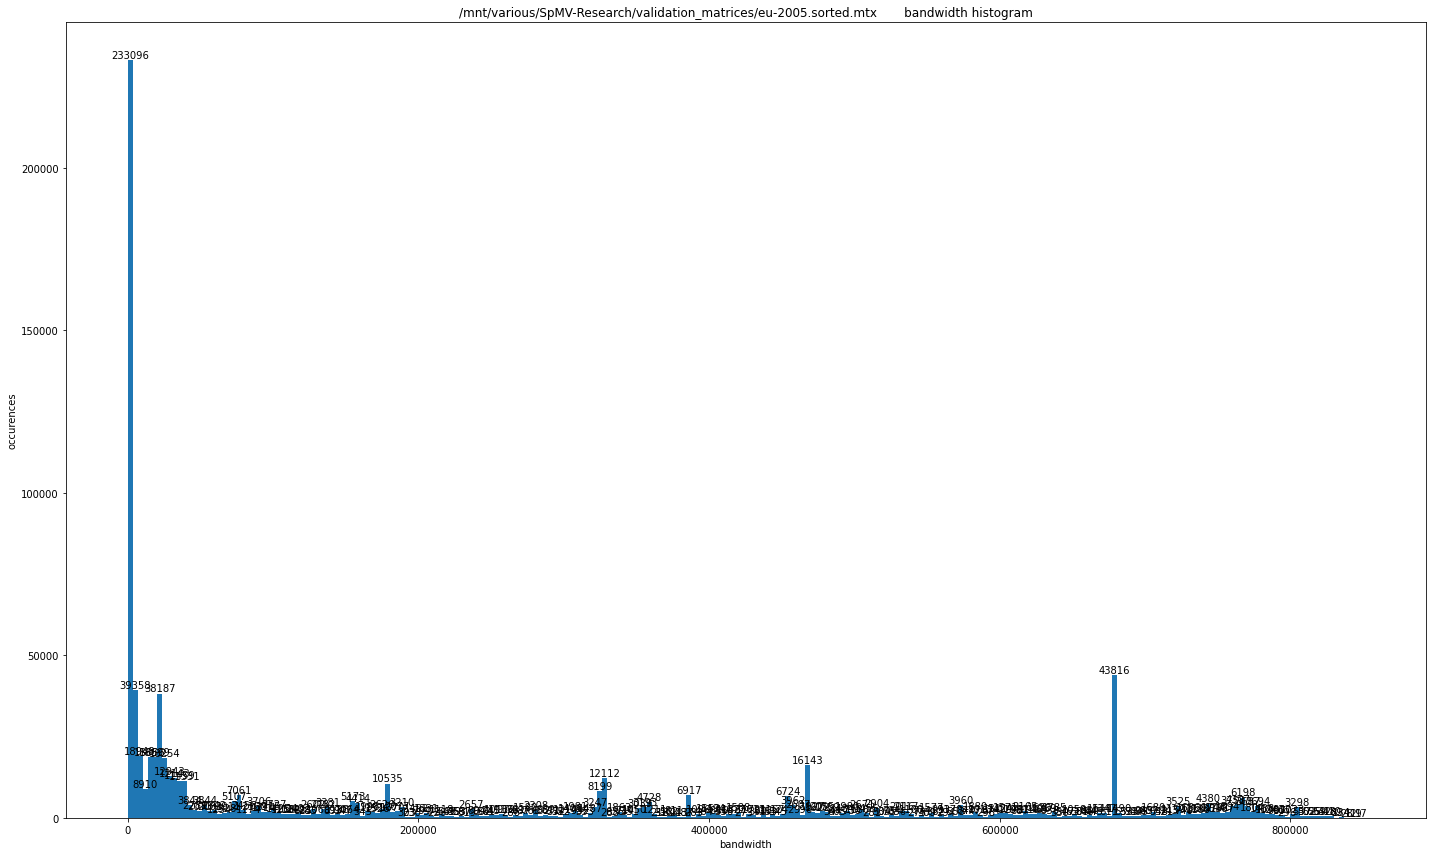

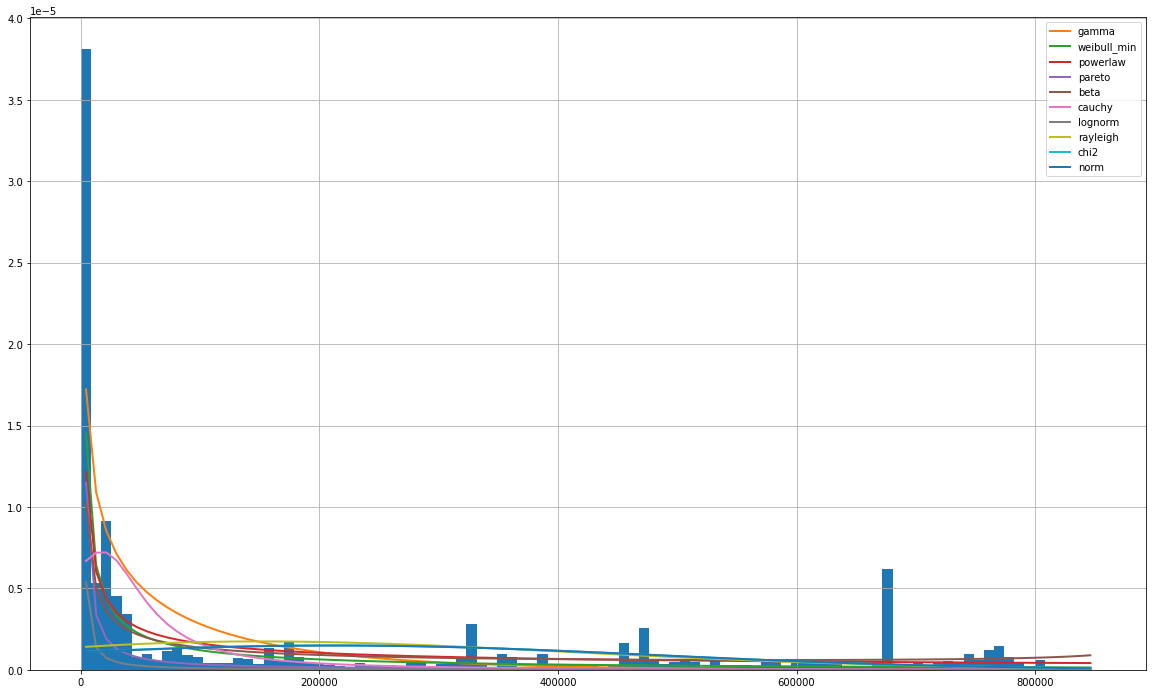

{'gamma': {'a': 0.6380330323502903, 'loc': -1.2772871140212233e-22, 'scale': 142847.27506666444}}
------
wikipedia-20051105.sorted.mtx :	dimensions (1634989, 1634989) / nnz 19753078 / mem footprint 232.293 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 262
nnz-row : min = 0 max = 4970 nr_bins = 262


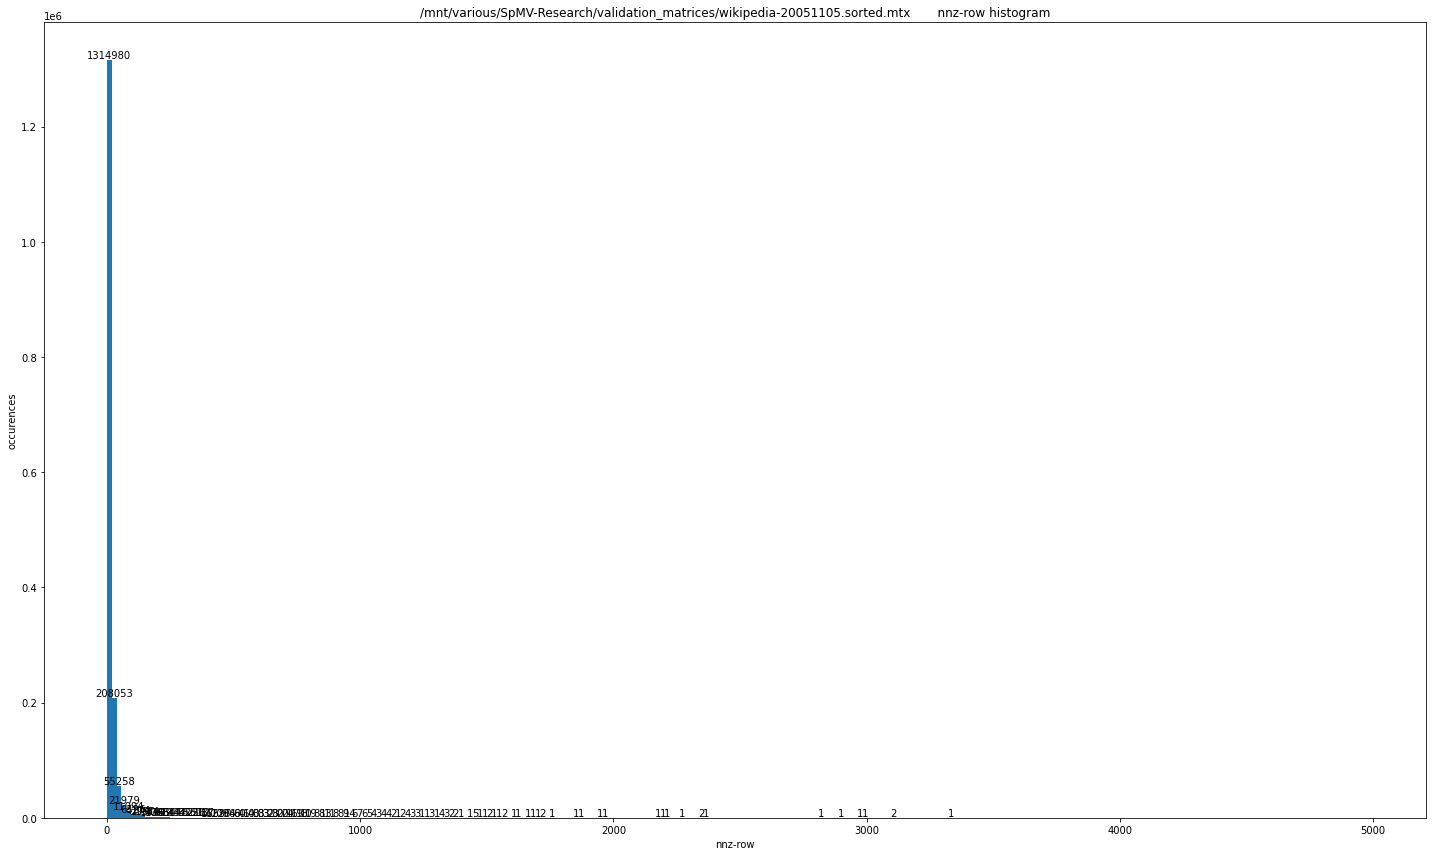

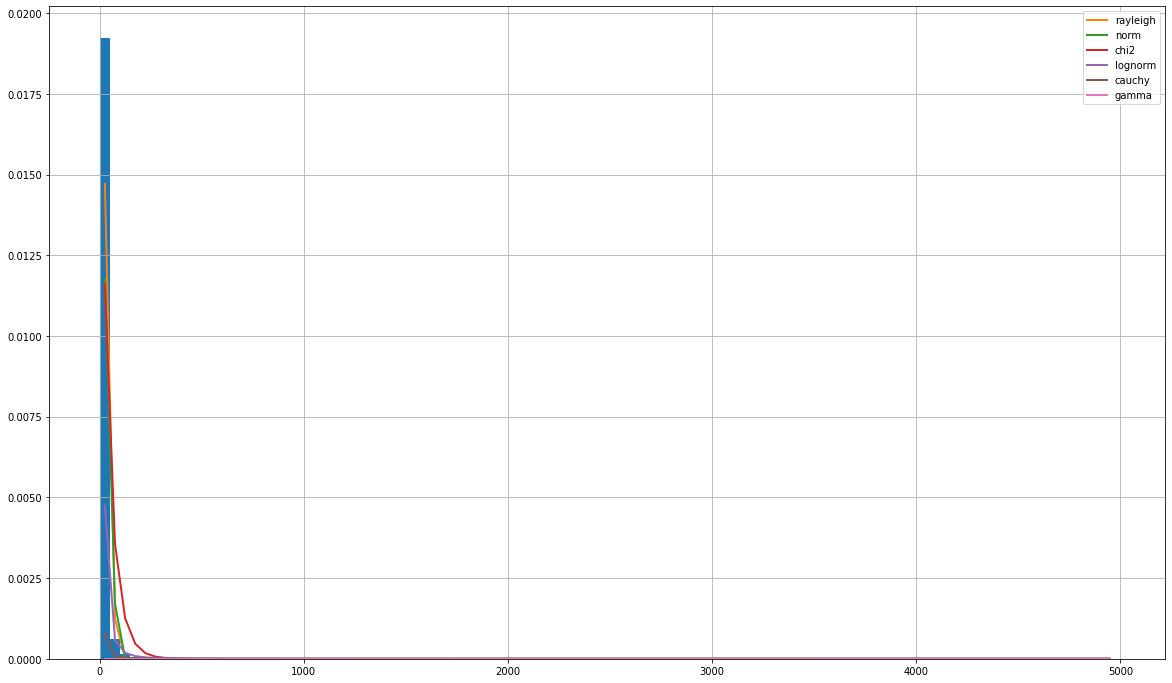

{'rayleigh': {'loc': -25.047041989338645, 'scale': 34.235791914171024}}
GOOD 251
bandwidth : min = 0 max = 1634906 nr_bins = 251


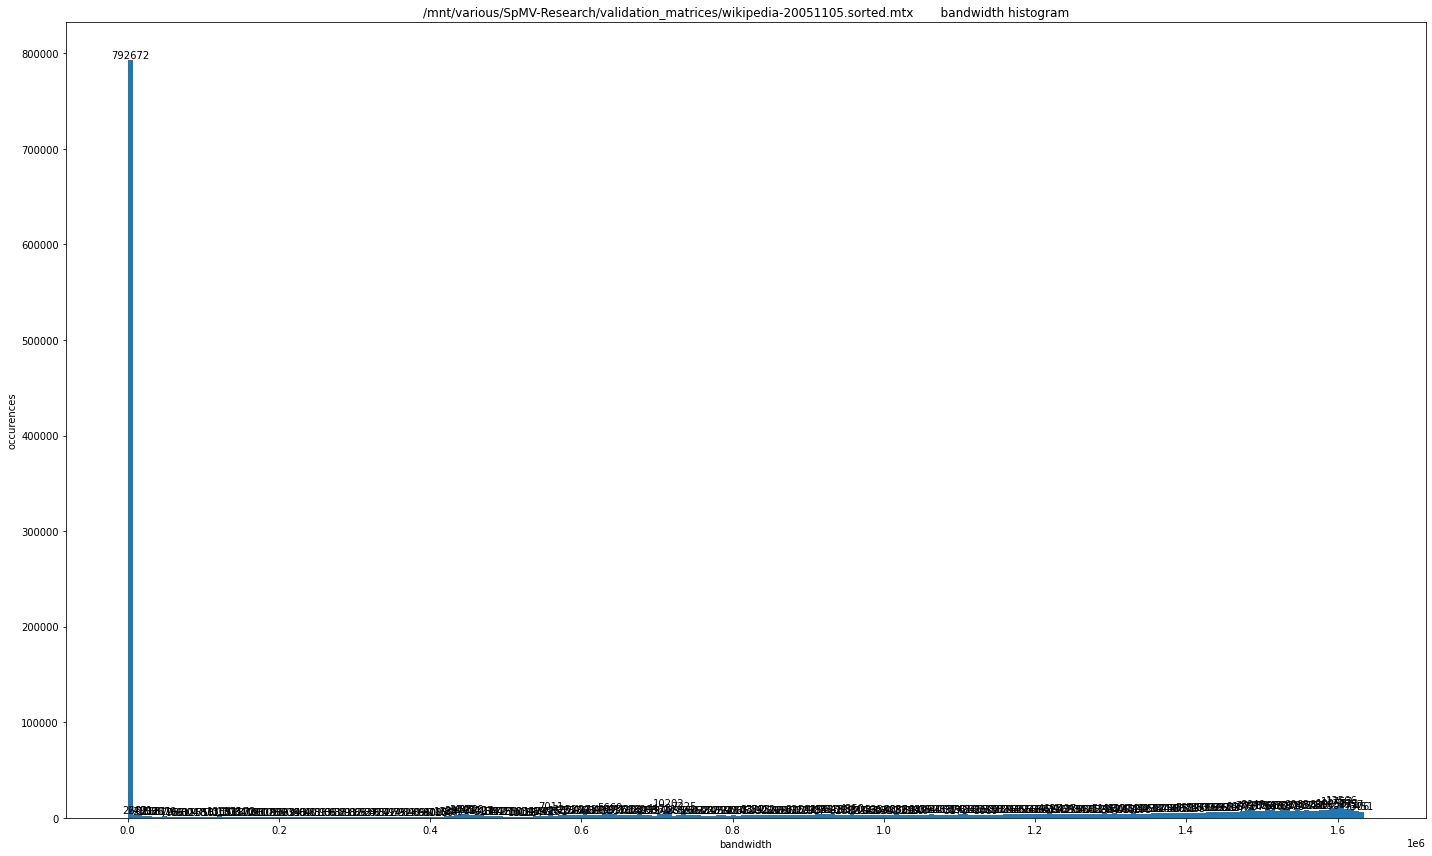

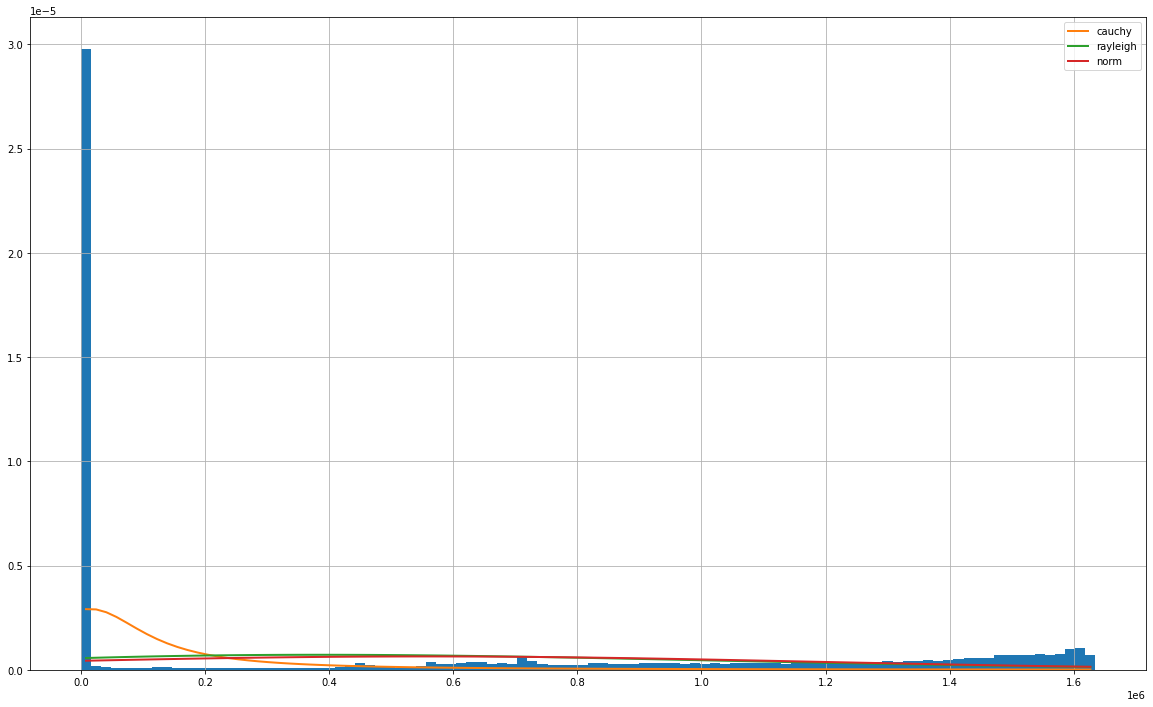

{'cauchy': {'loc': 14732.923515030212, 'scale': 109000.45228334563}}
------
Ga41As41H72.sorted.mtx :	dimensions (268096, 268096) / nnz 18488476 / mem footprint 212.607 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 343
nnz-row : min = 18 max = 702 nr_bins = 343


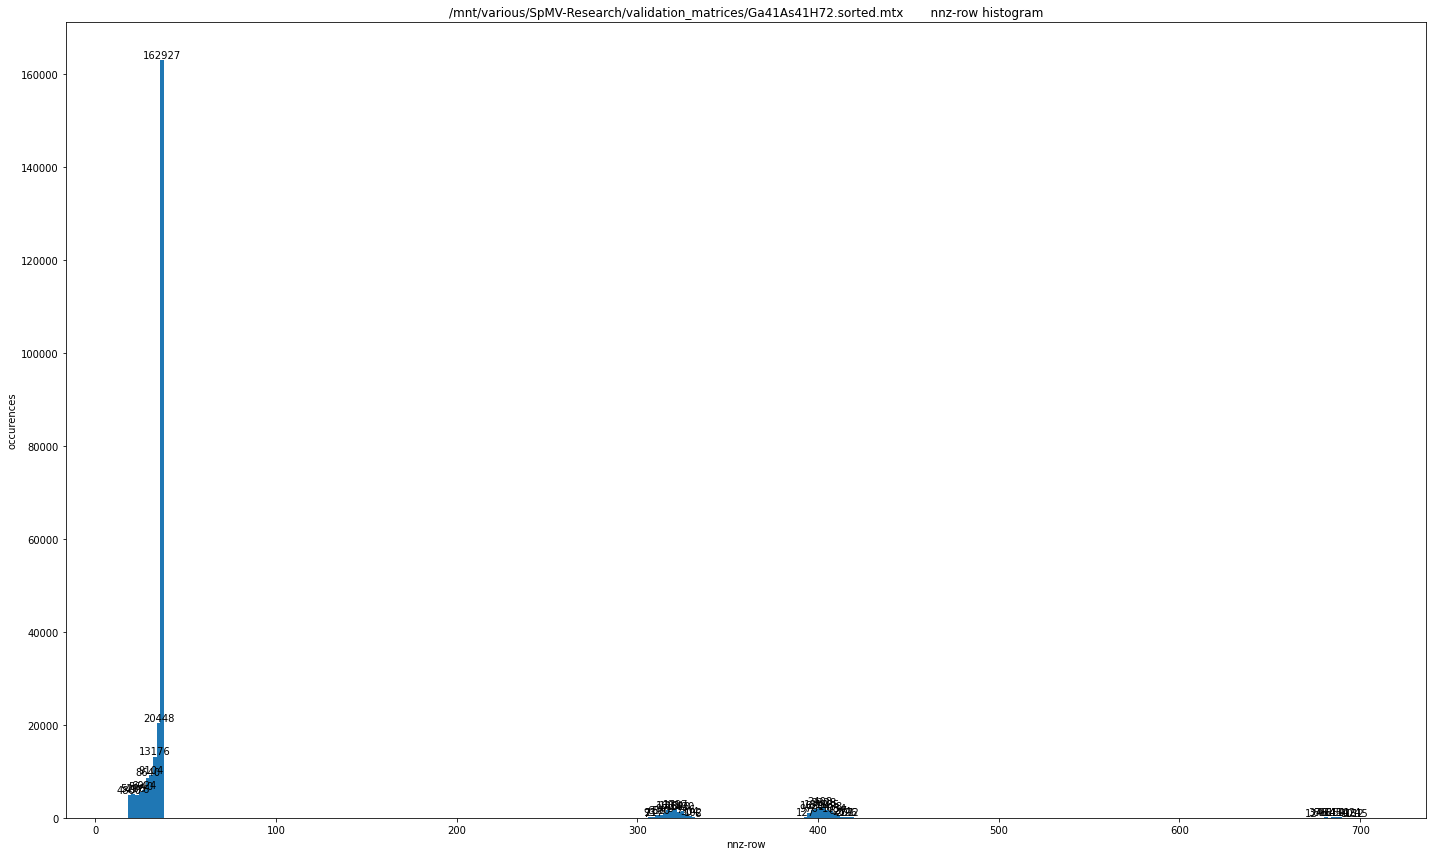

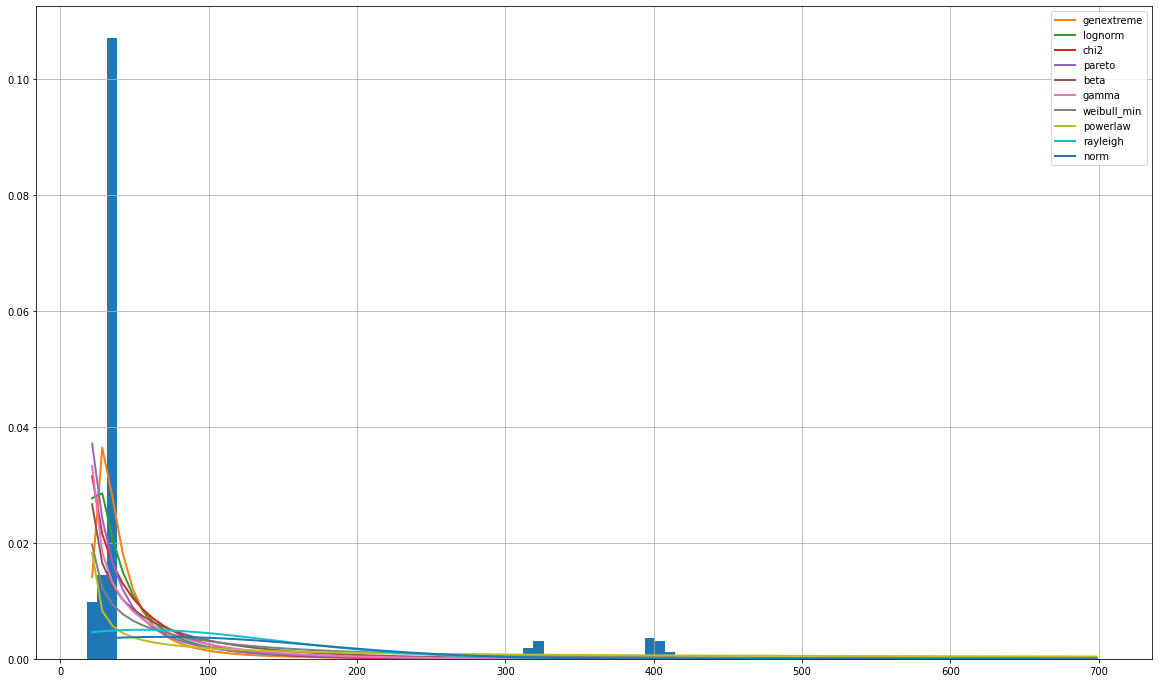

{'genextreme': {'c': -0.5483291073611346, 'loc': 32.50398745668518, 'scale': 11.486134568355954}}
GOOD 251
bandwidth : min = 4796 max = 69927 nr_bins = 251


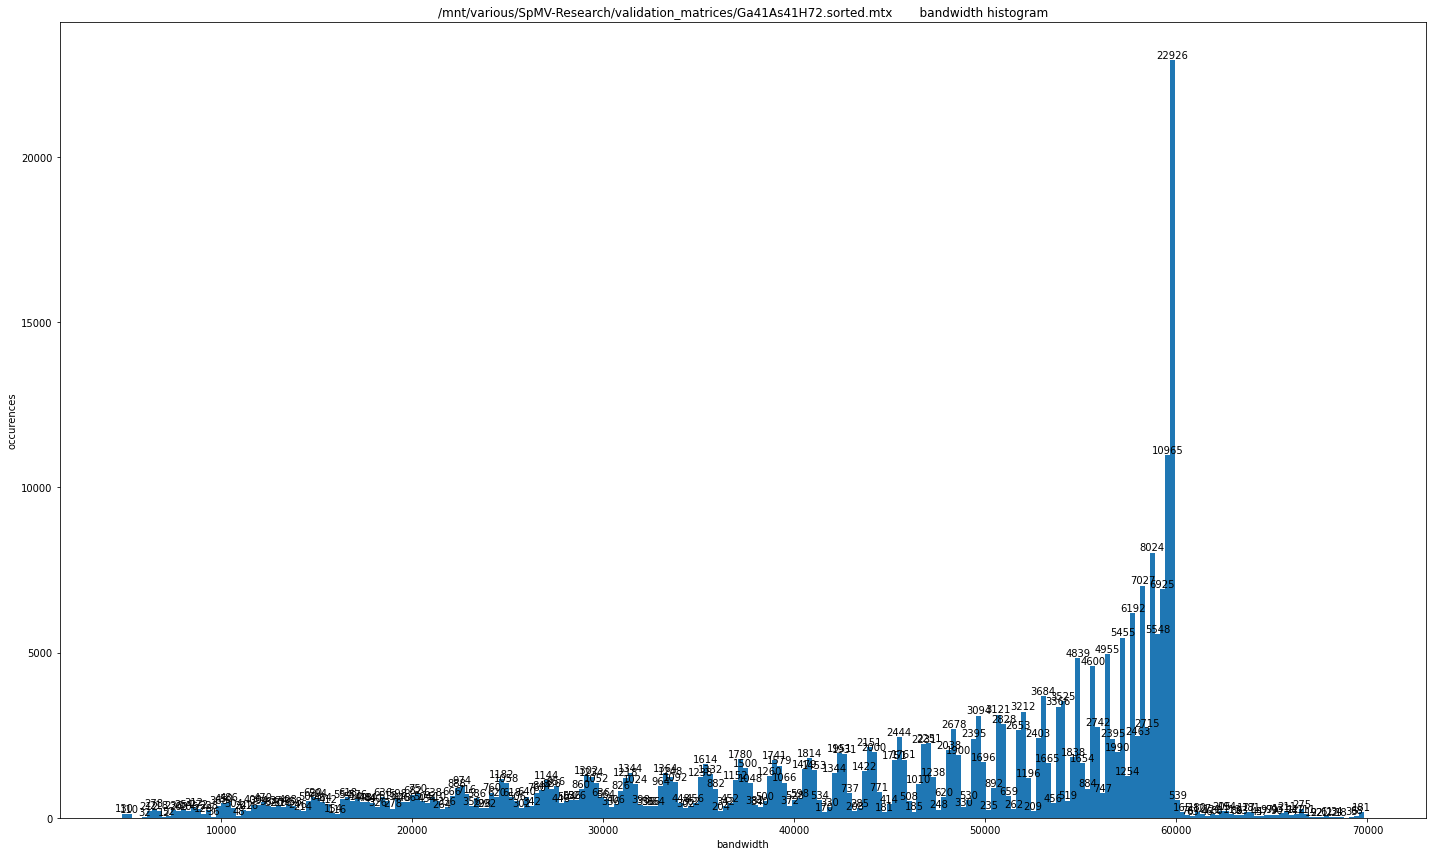

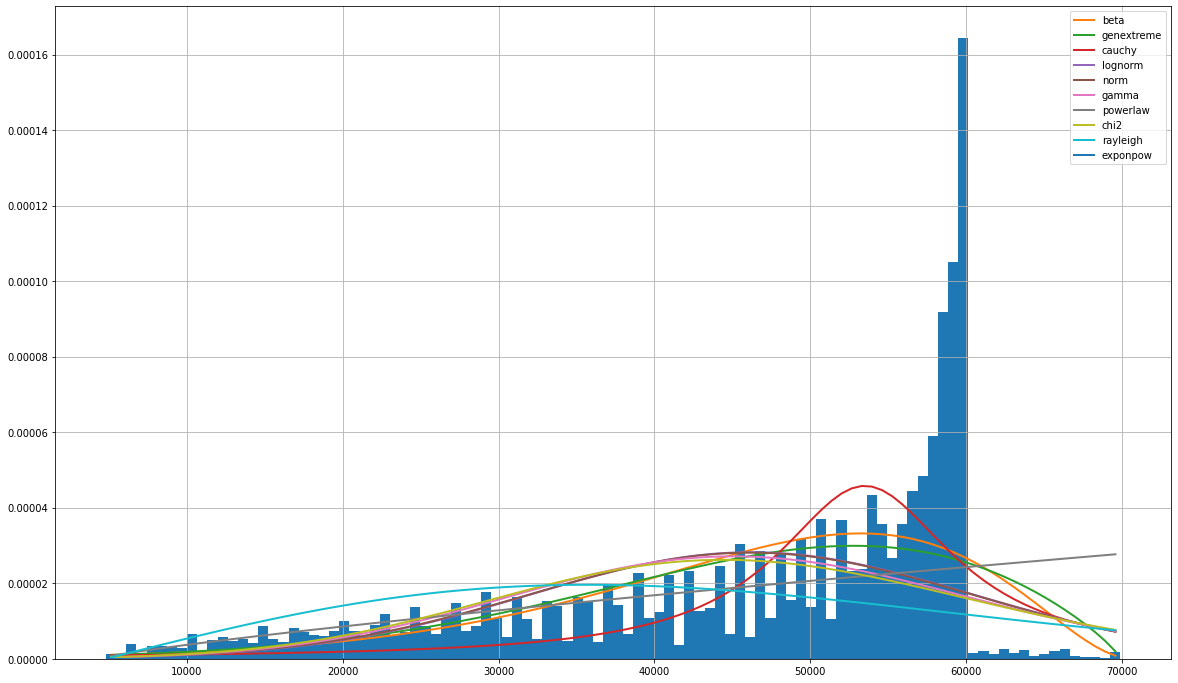

{'beta': {'a': 32.09466251081085, 'b': 3.0375572449863295, 'loc': -213885.8607987108, 'scale': 284631.6071541513}}
------
TSOPF_RS_b2383.sorted.mtx :	dimensions (38120, 38120) / nnz 16171169 / mem footprint 185.21 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 328
nnz-row : min = 2 max = 983 nr_bins = 328


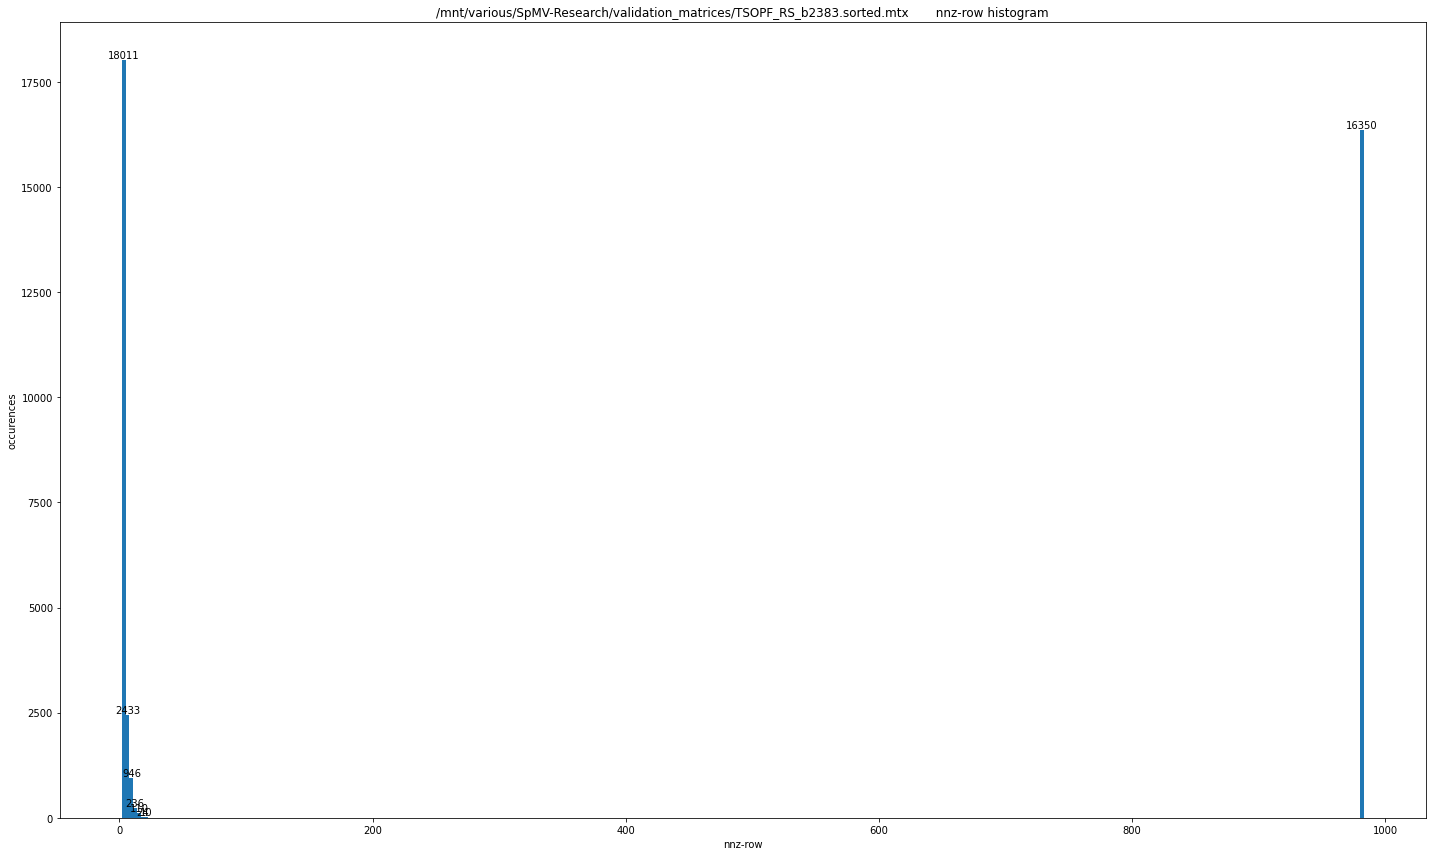

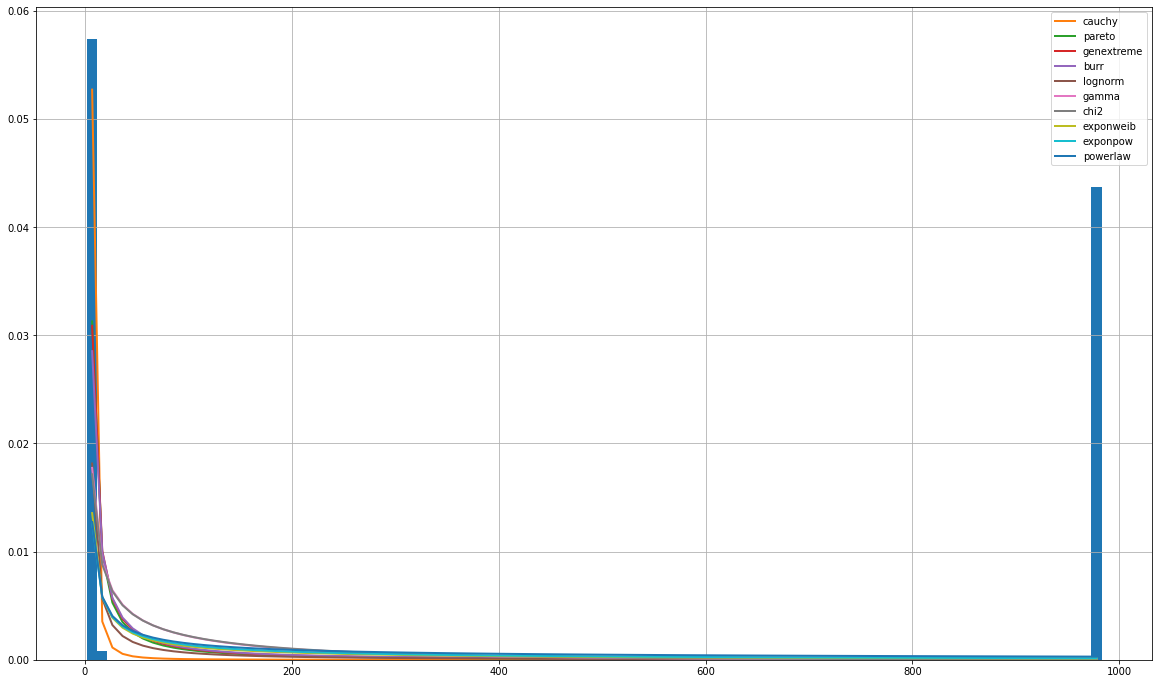

{'cauchy': {'loc': 4.145550352689552, 'scale': 1.7940249552741787}}
GOOD 251
bandwidth : min = 1 max = 33353 nr_bins = 251


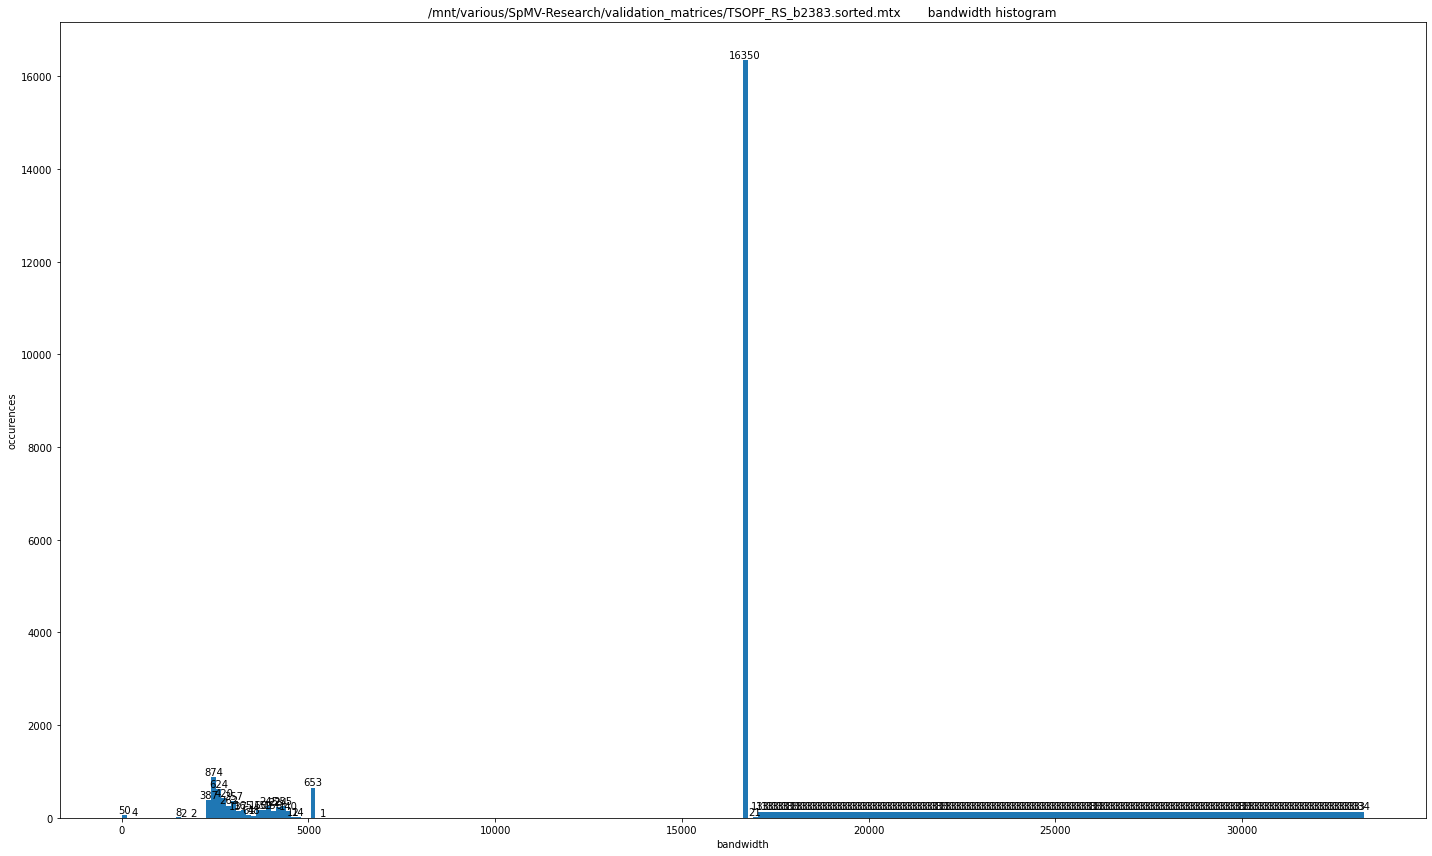

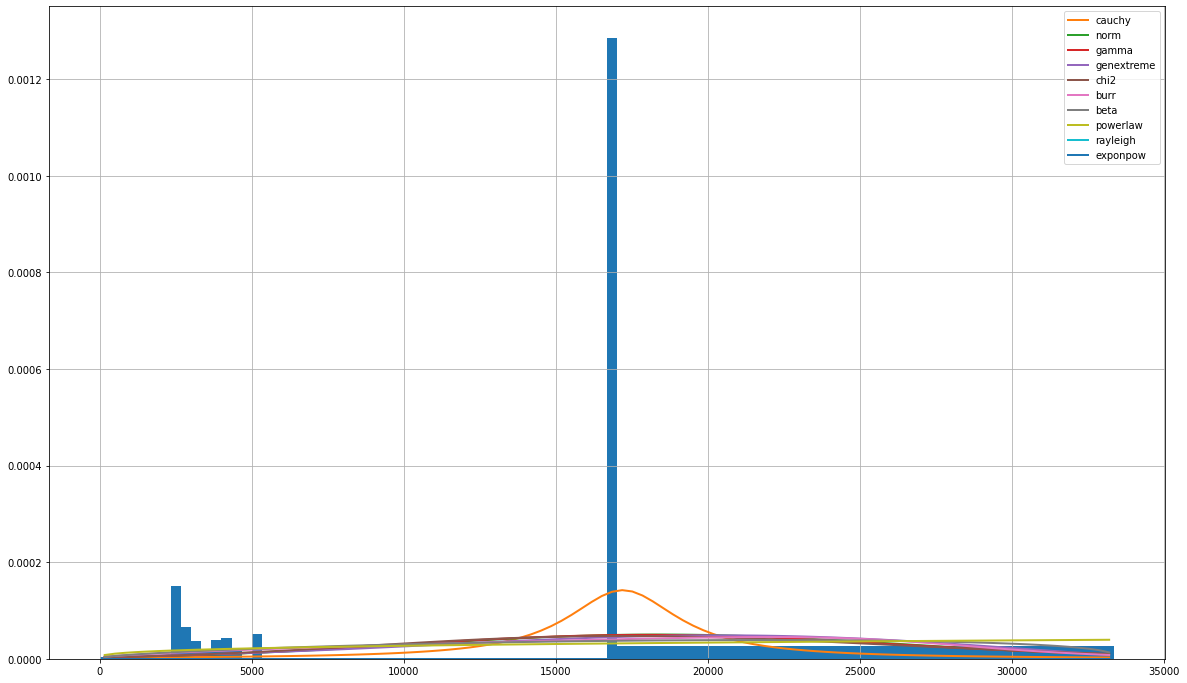

{'cauchy': {'loc': 17193.662810751423, 'scale': 2238.4598472356074}}
------
rajat31.sorted.mtx :	dimensions (4690002, 4690002) / nnz 20316253 / mem footprint 250.392 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 251
nnz-row : min = 1 max = 1252 nr_bins = 251


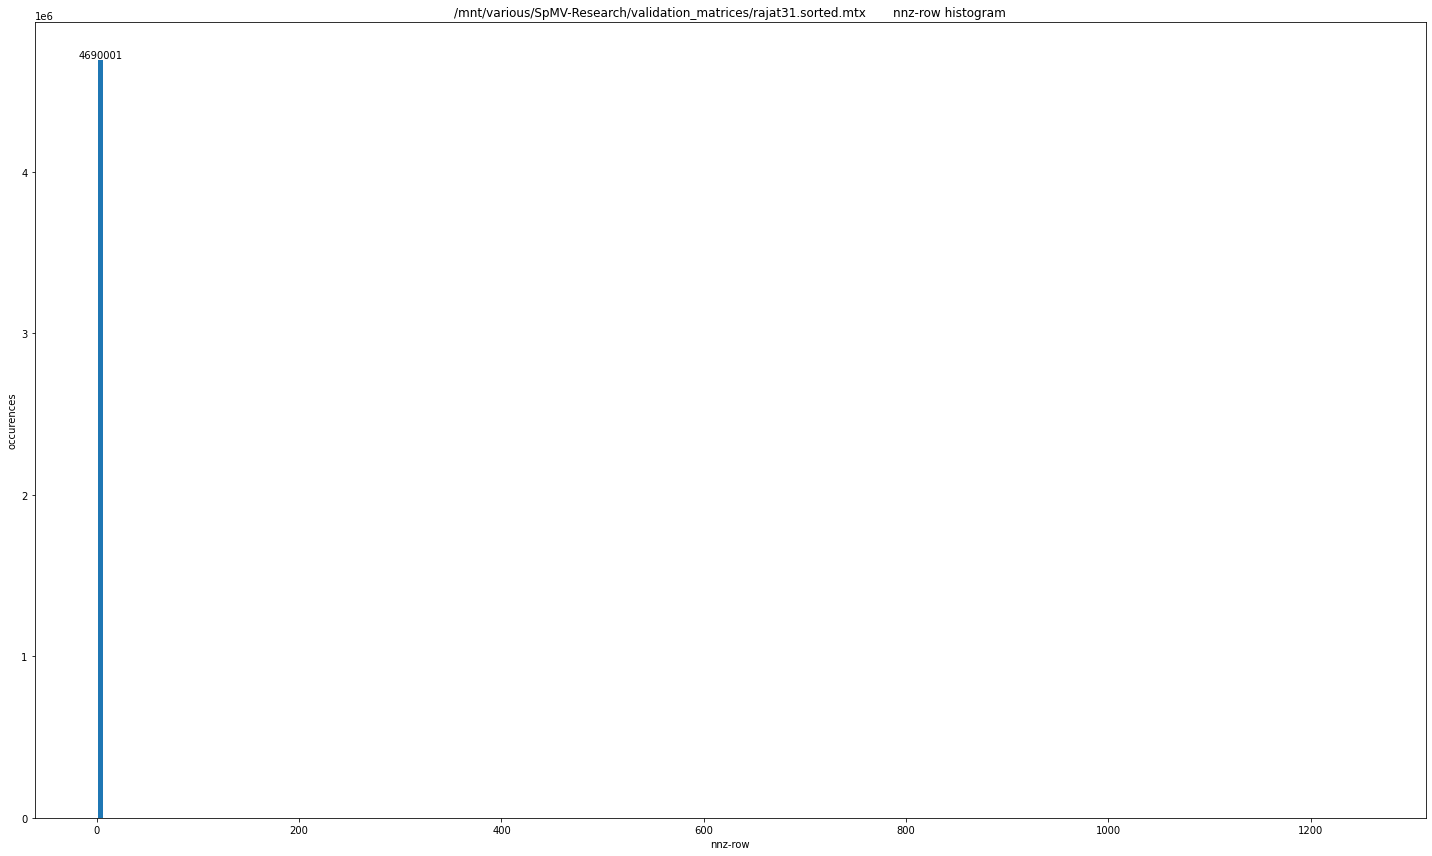

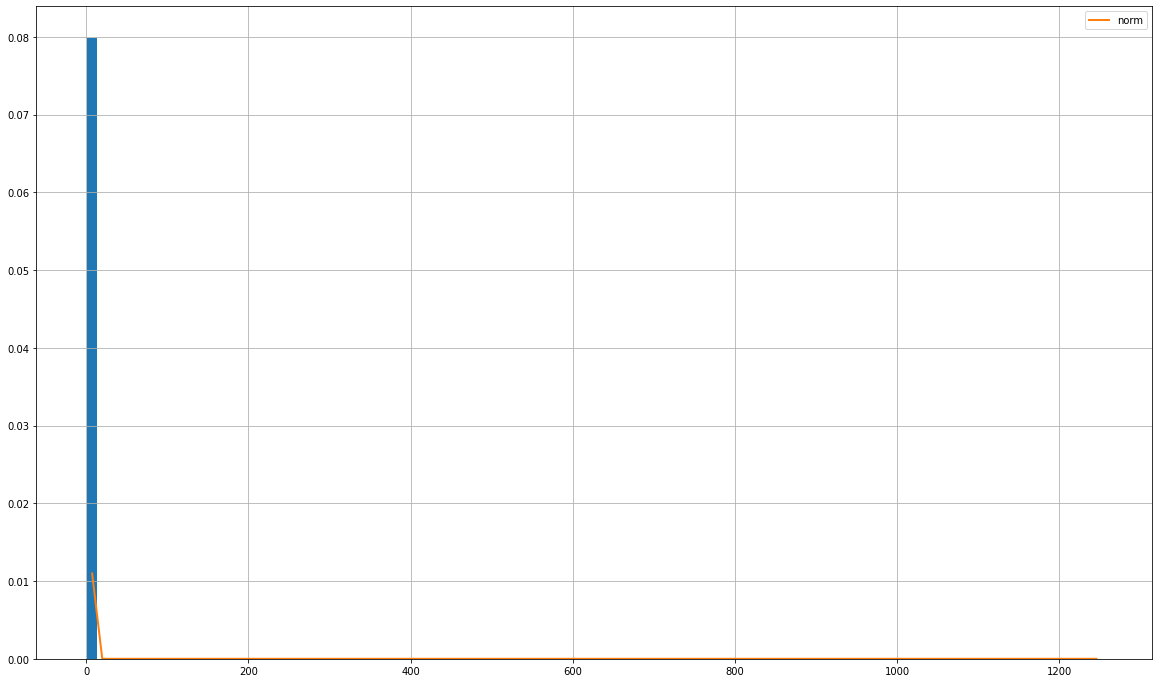

{'norm': {'loc': 4.331821820118627, 'scale': 1.1061578468601982}}
GOOD 251
bandwidth : min = 0 max = 4688751 nr_bins = 251


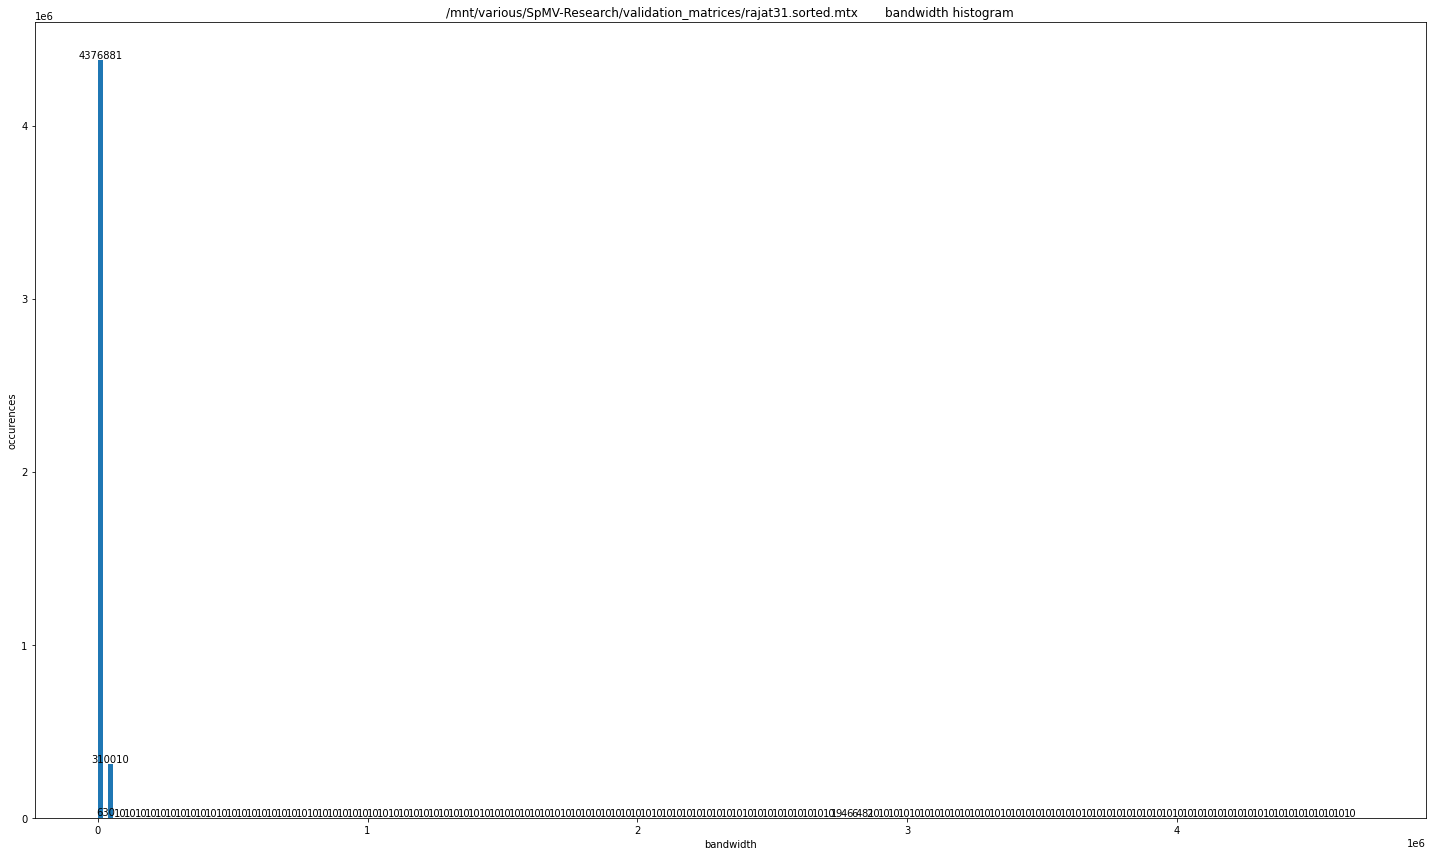

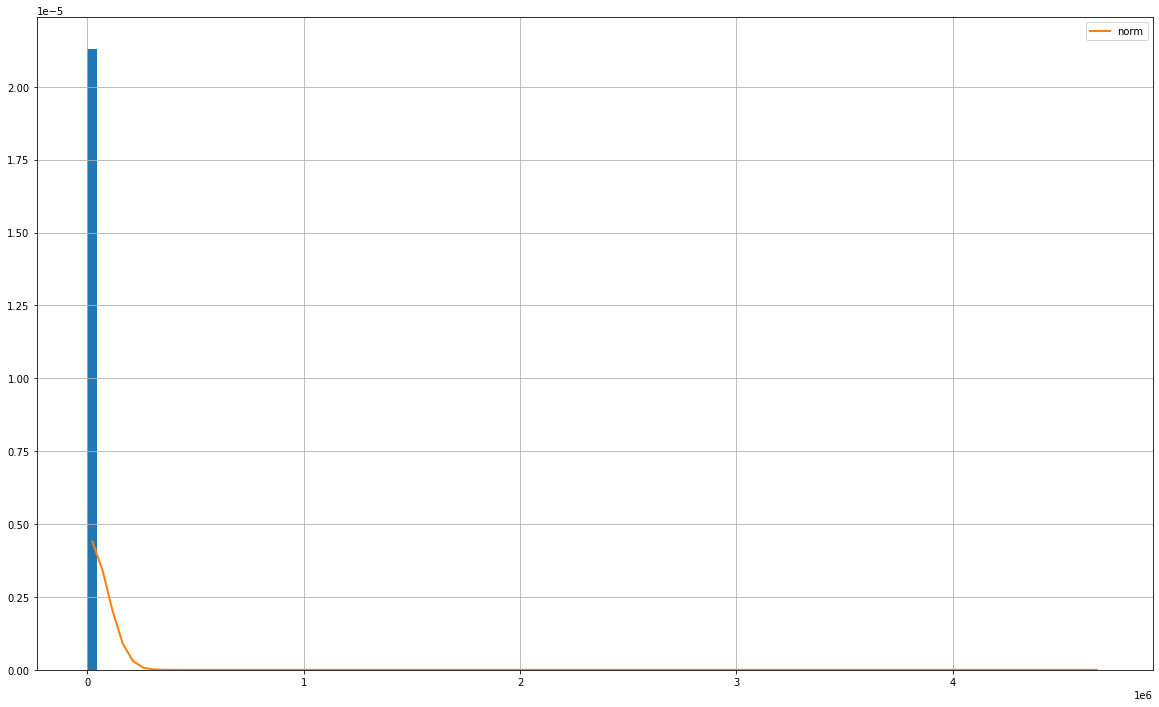

{'norm': {'loc': 4557.086543033457, 'scale': 88691.64819843609}}
------
ldoor.sorted.mtx :	dimensions (952203, 952203) / nnz 46522475 / mem footprint 536.04 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 51
nnz-row : min = 28 max = 77 nr_bins = 51


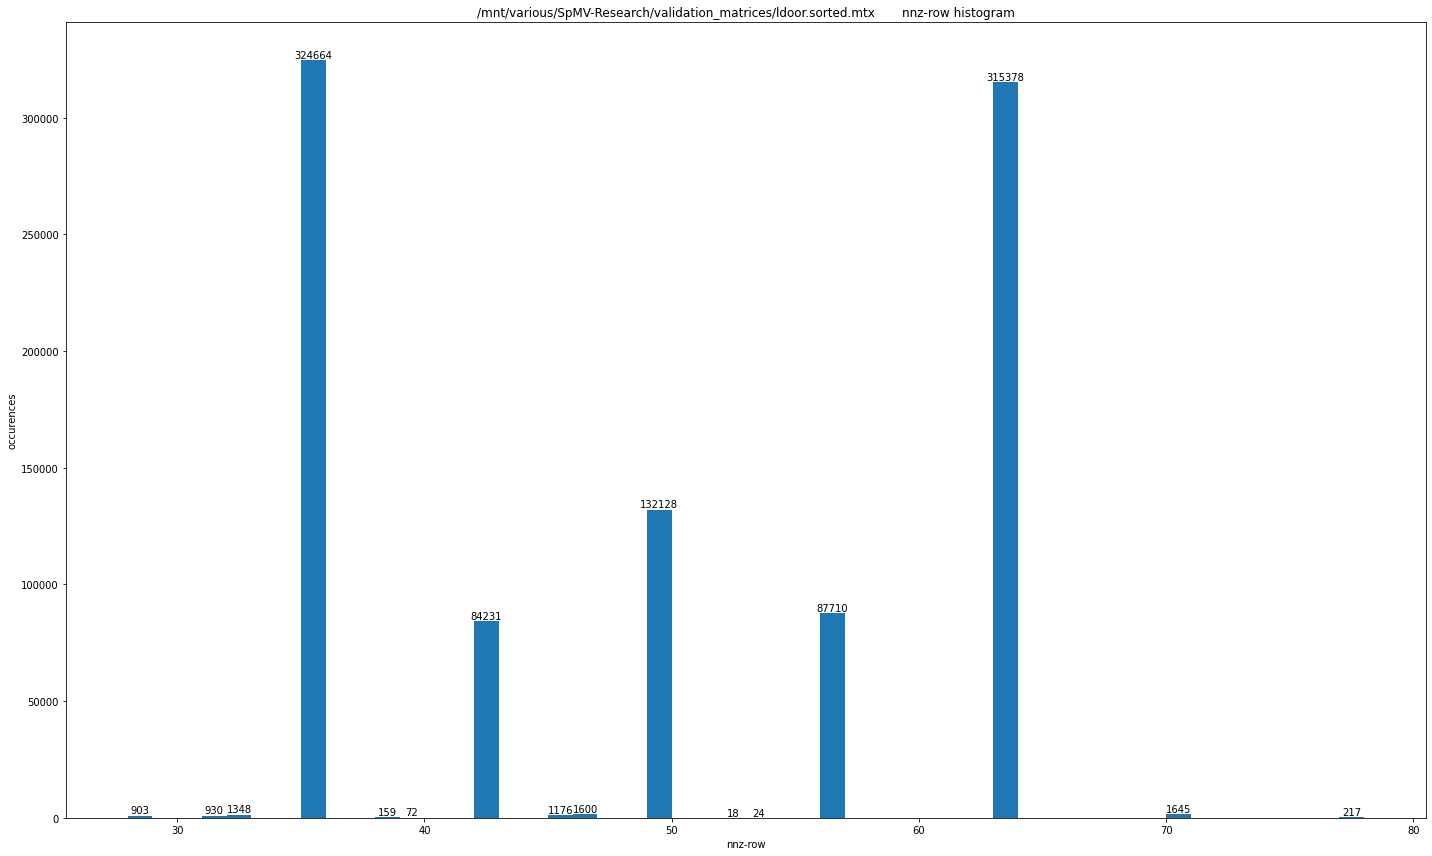

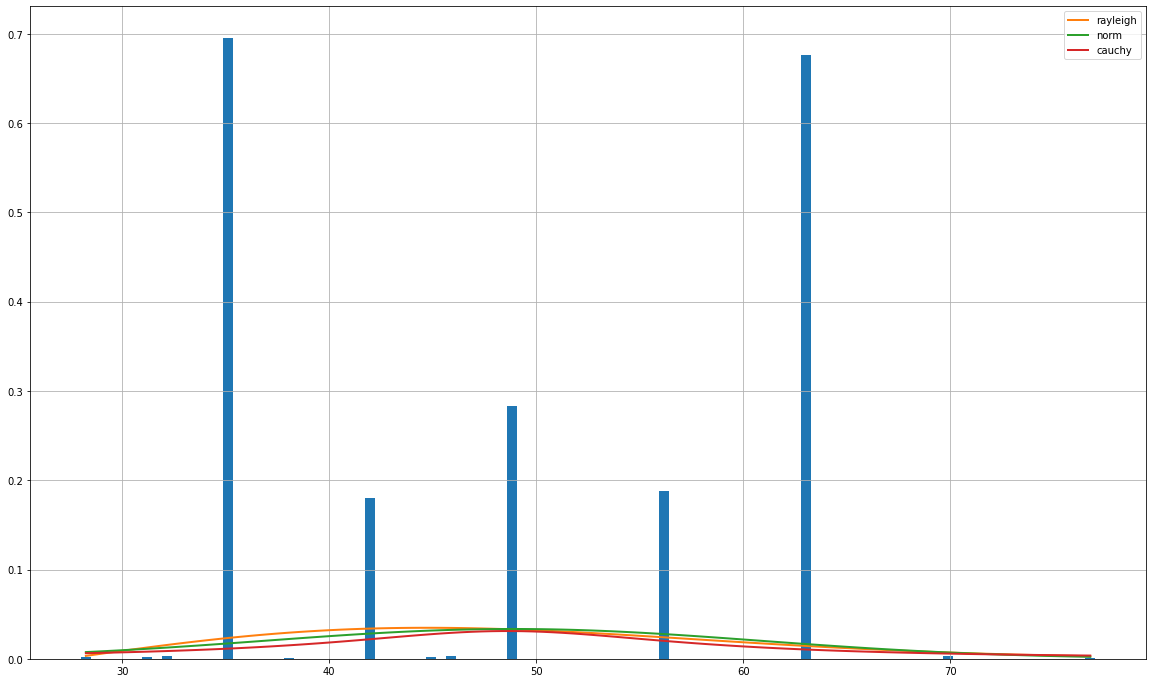

{'rayleigh': {'loc': 27.249772400990814, 'scale': 17.4588845101539}}
GOOD 251
bandwidth : min = 41 max = 687560 nr_bins = 251


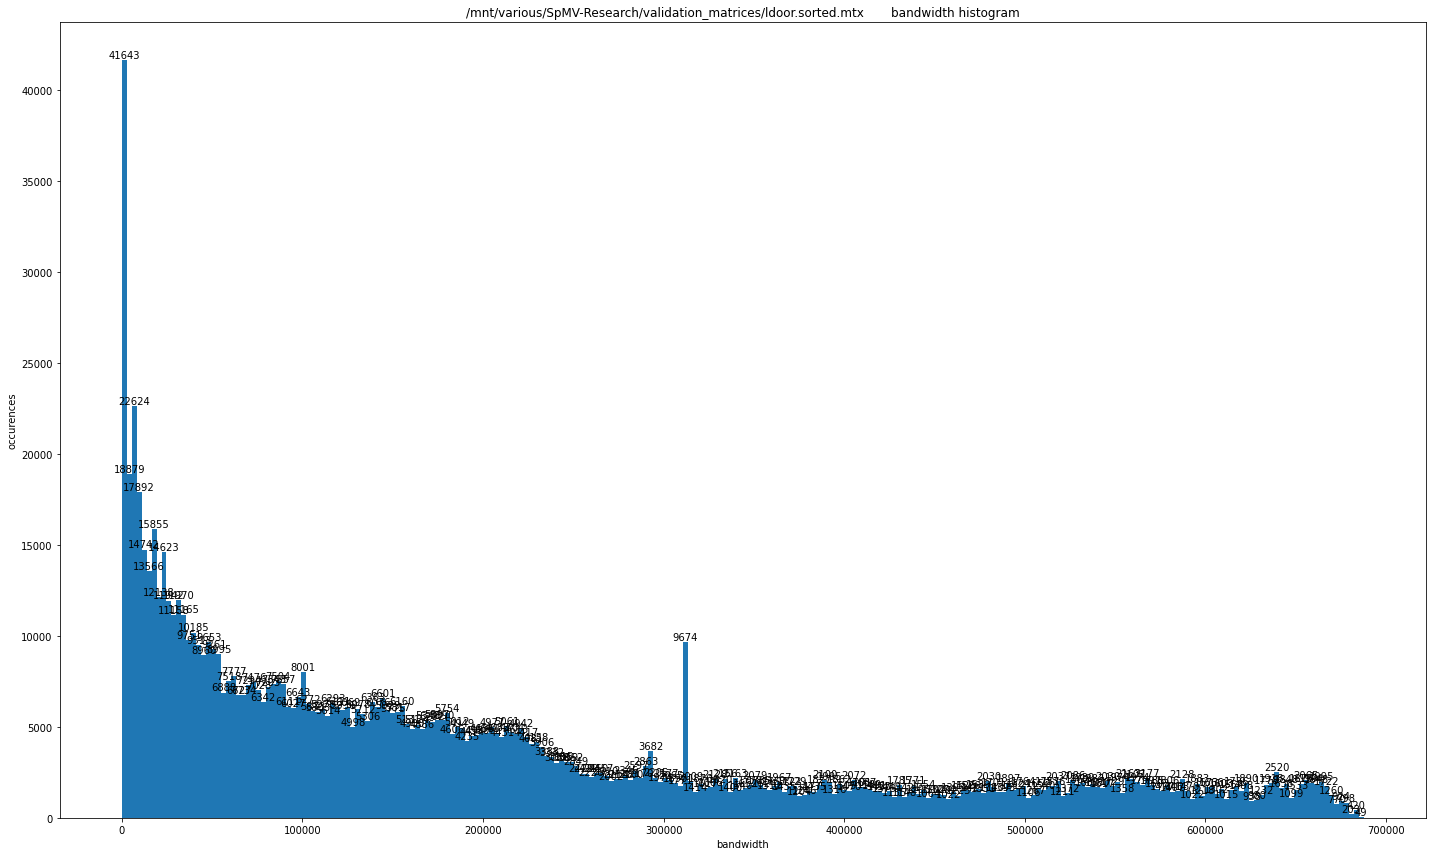

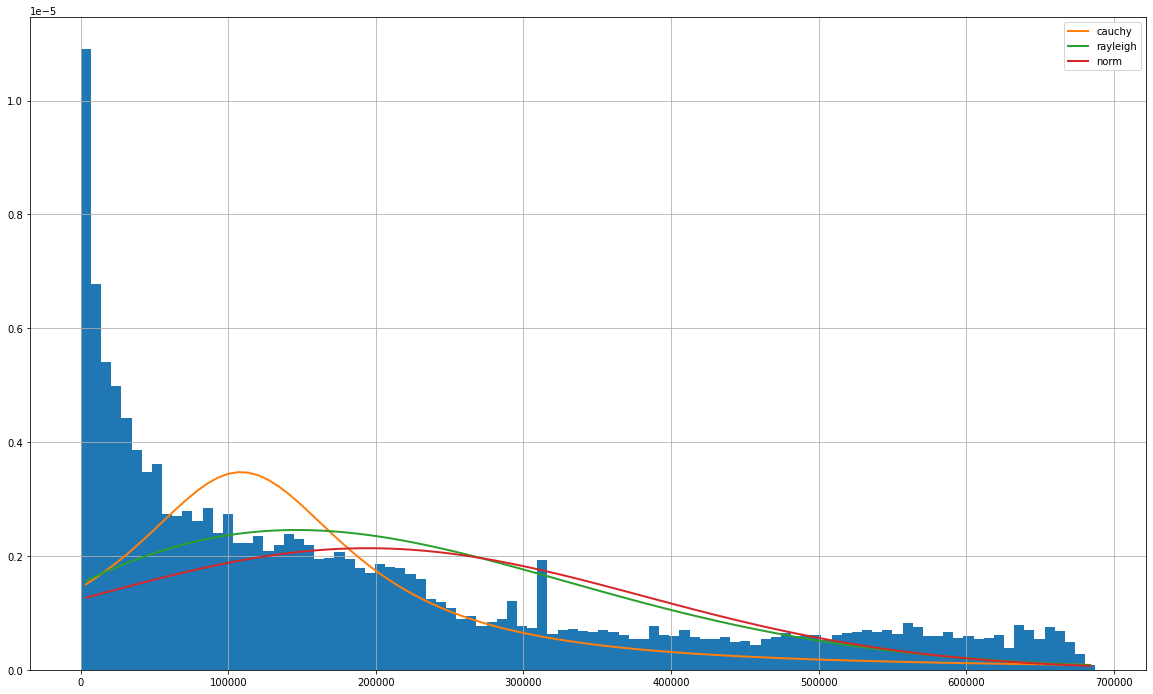

{'cauchy': {'loc': 108554.63248855234, 'scale': 91639.62043075252}}
------
bone010.sorted.mtx :	dimensions (986703, 986703) / nnz 71666325 / mem footprint 823.92 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 71
nnz-row : min = 12 max = 81 nr_bins = 71


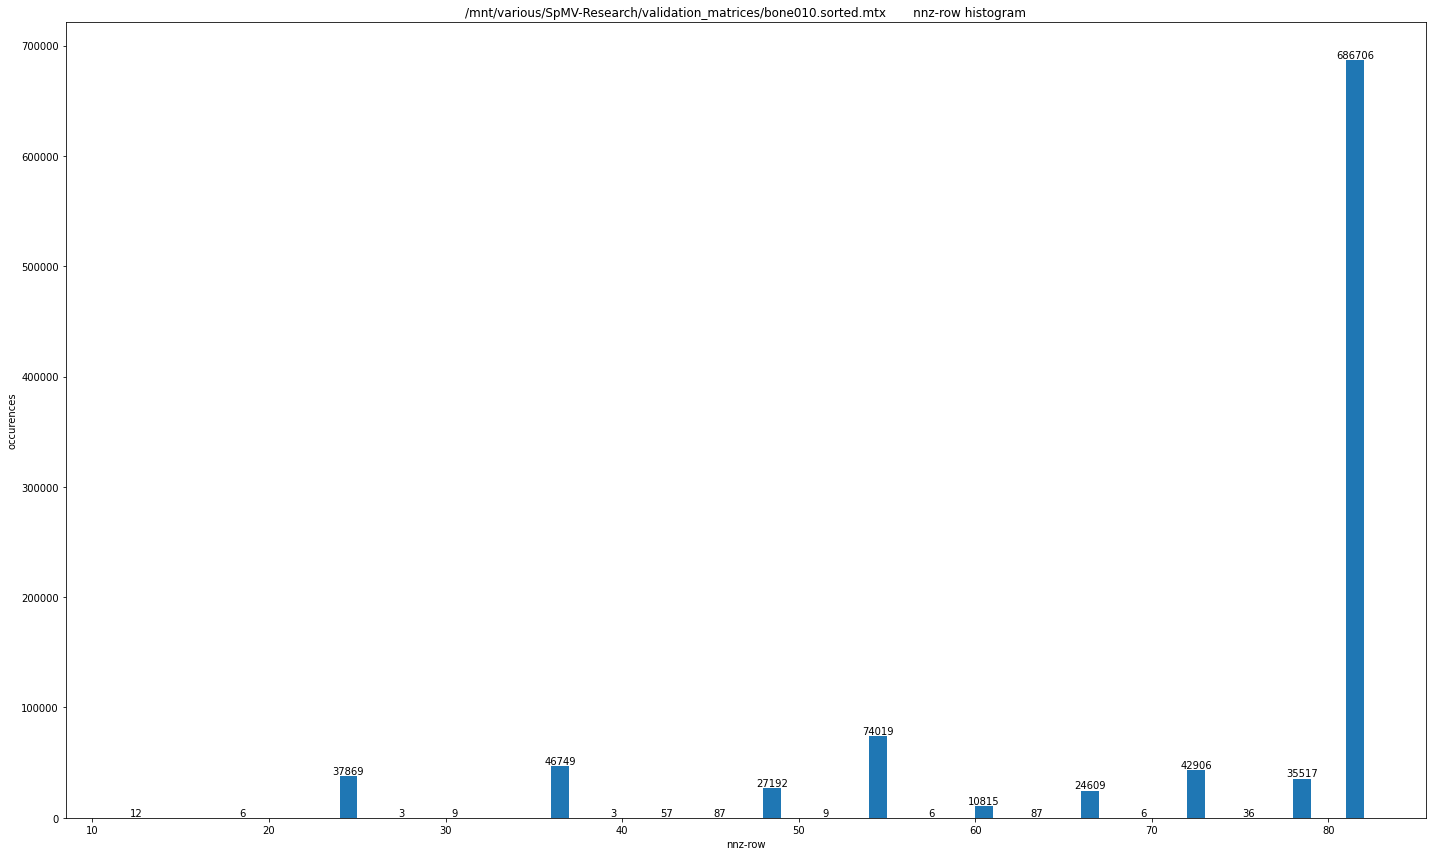

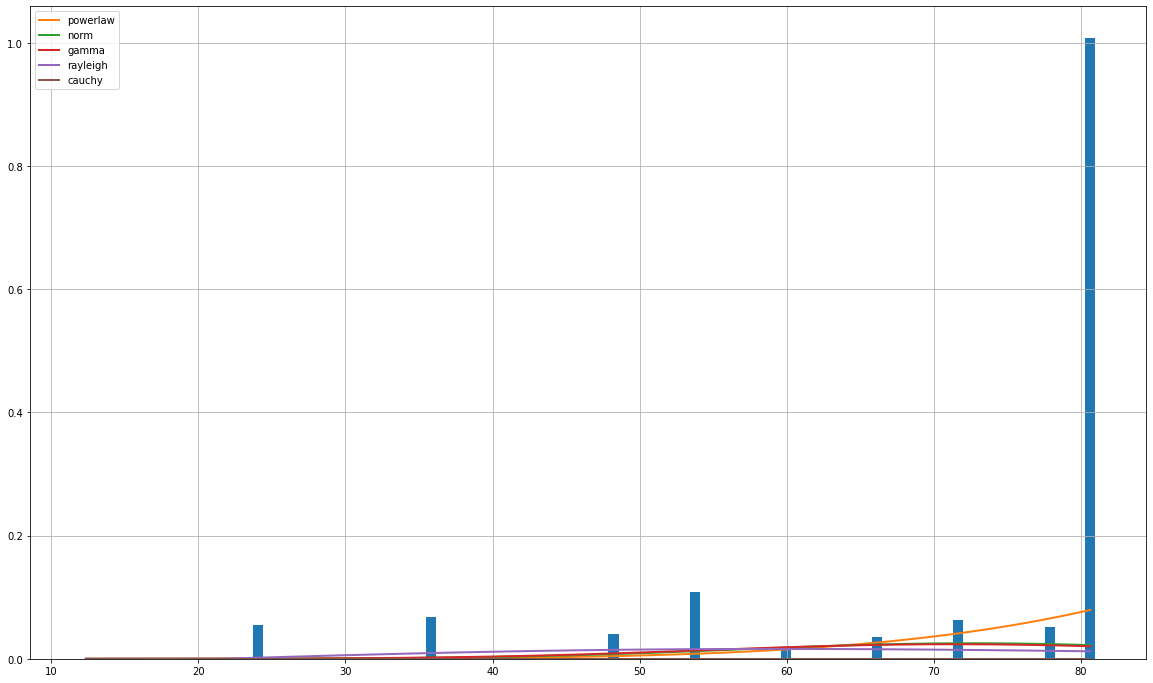

{'powerlaw': {'a': 6.116109137651462, 'loc': 5.687853677964229, 'scale': 75.31214632553039}}
GOOD 251
bandwidth : min = 104 max = 25952 nr_bins = 251


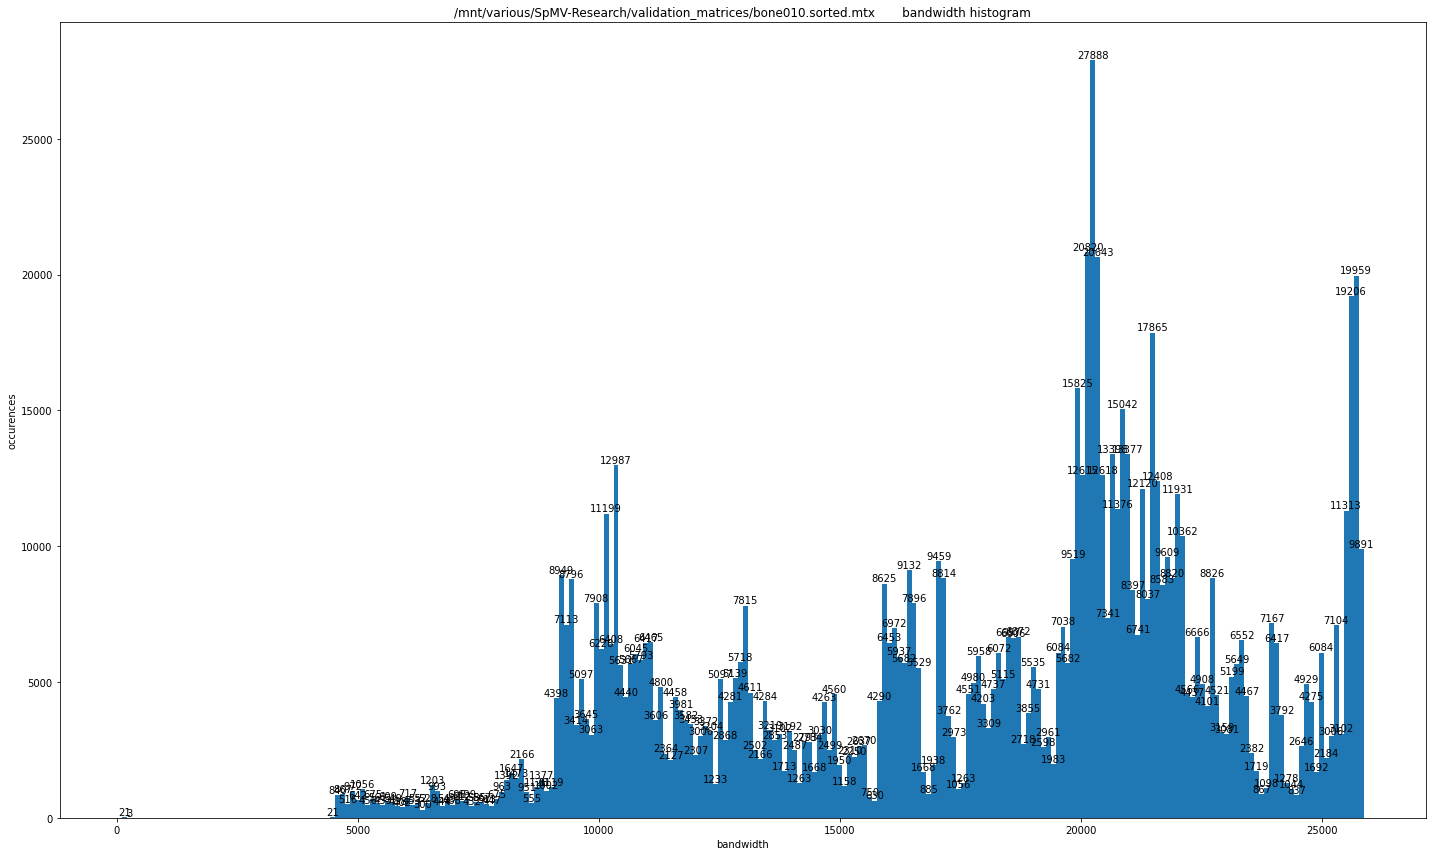

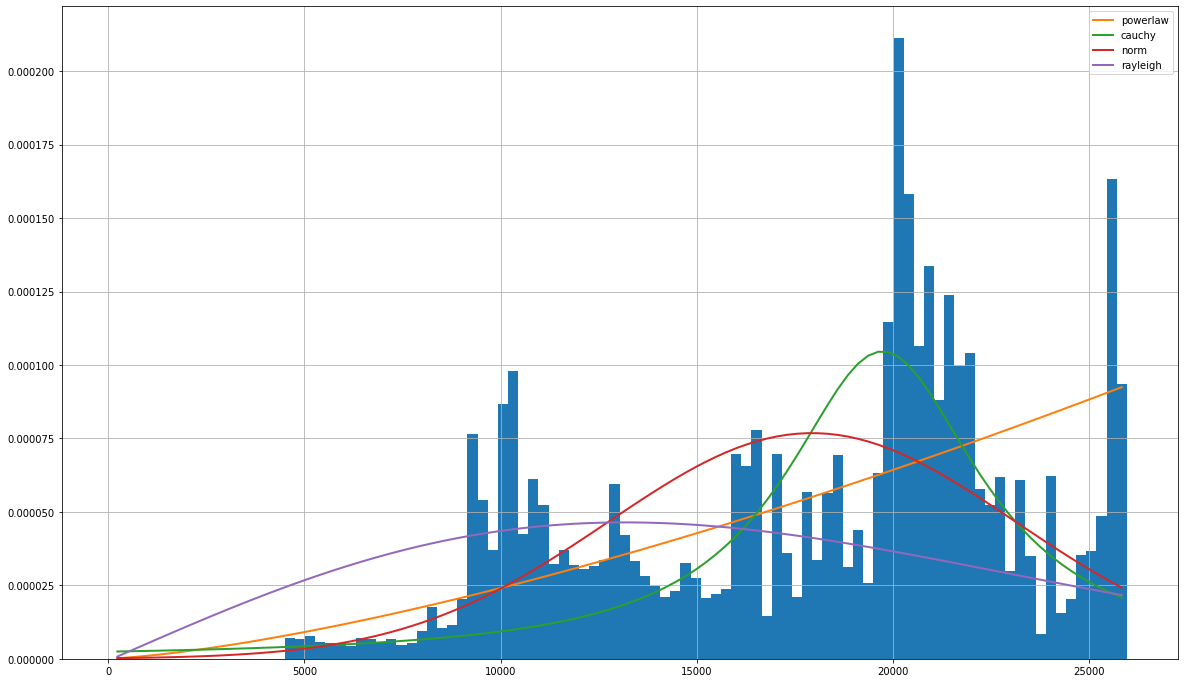

{'powerlaw': {'a': 2.427611600875207, 'loc': -115.34339049792948, 'scale': 26067.343390497947}}
------
circuit5M.sorted.mtx :	dimensions (5558326, 5558326) / nnz 59524291 / mem footprint 702.405 MB (CSR)
nnz_per_row ready
bandwidth2  ready
GOOD 251
nnz-row : min = 1 max = 1290501 nr_bins = 251


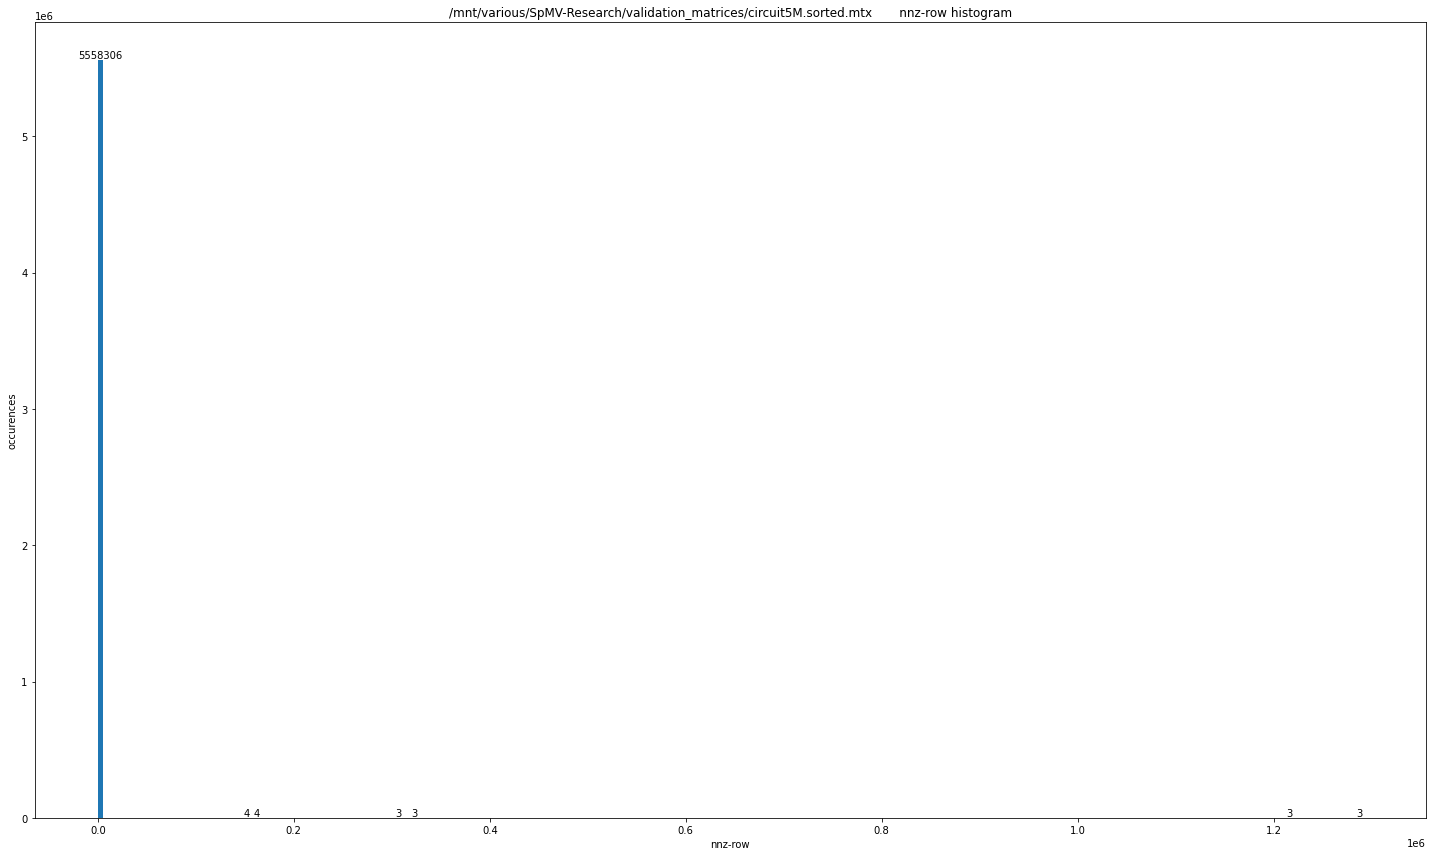

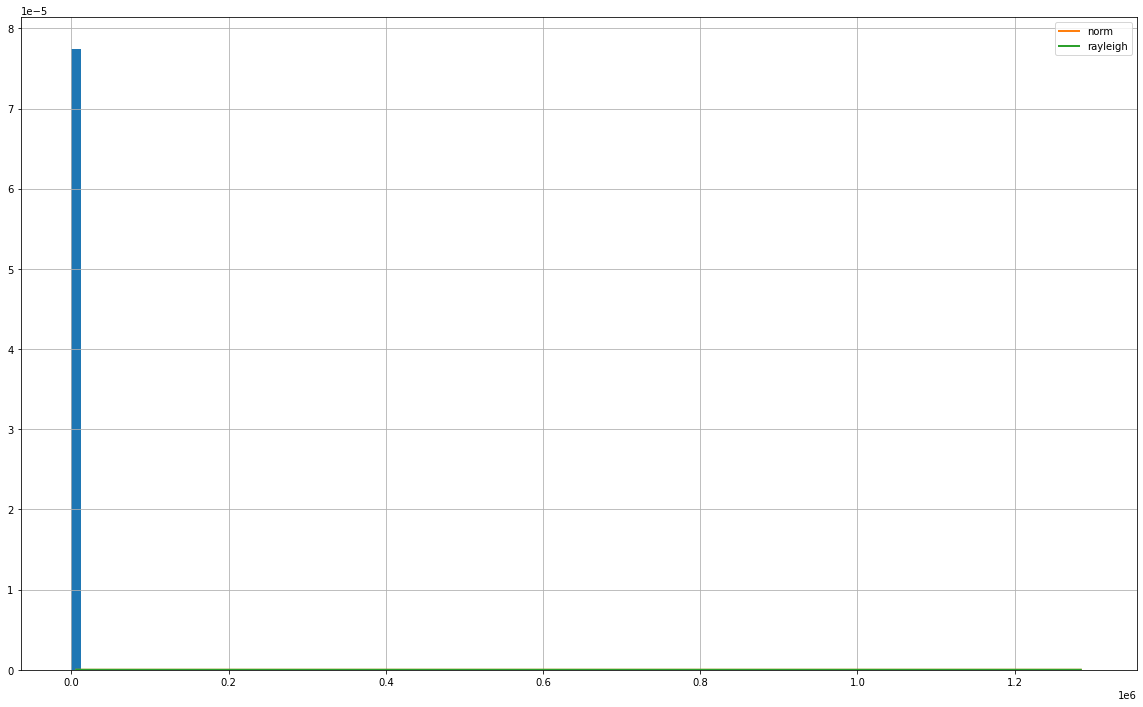

{'norm': {'loc': 10.70903199992228, 'scale': 1356.6162743453974}}
GOOD 251
bandwidth : min = 0 max = 5558122 nr_bins = 251


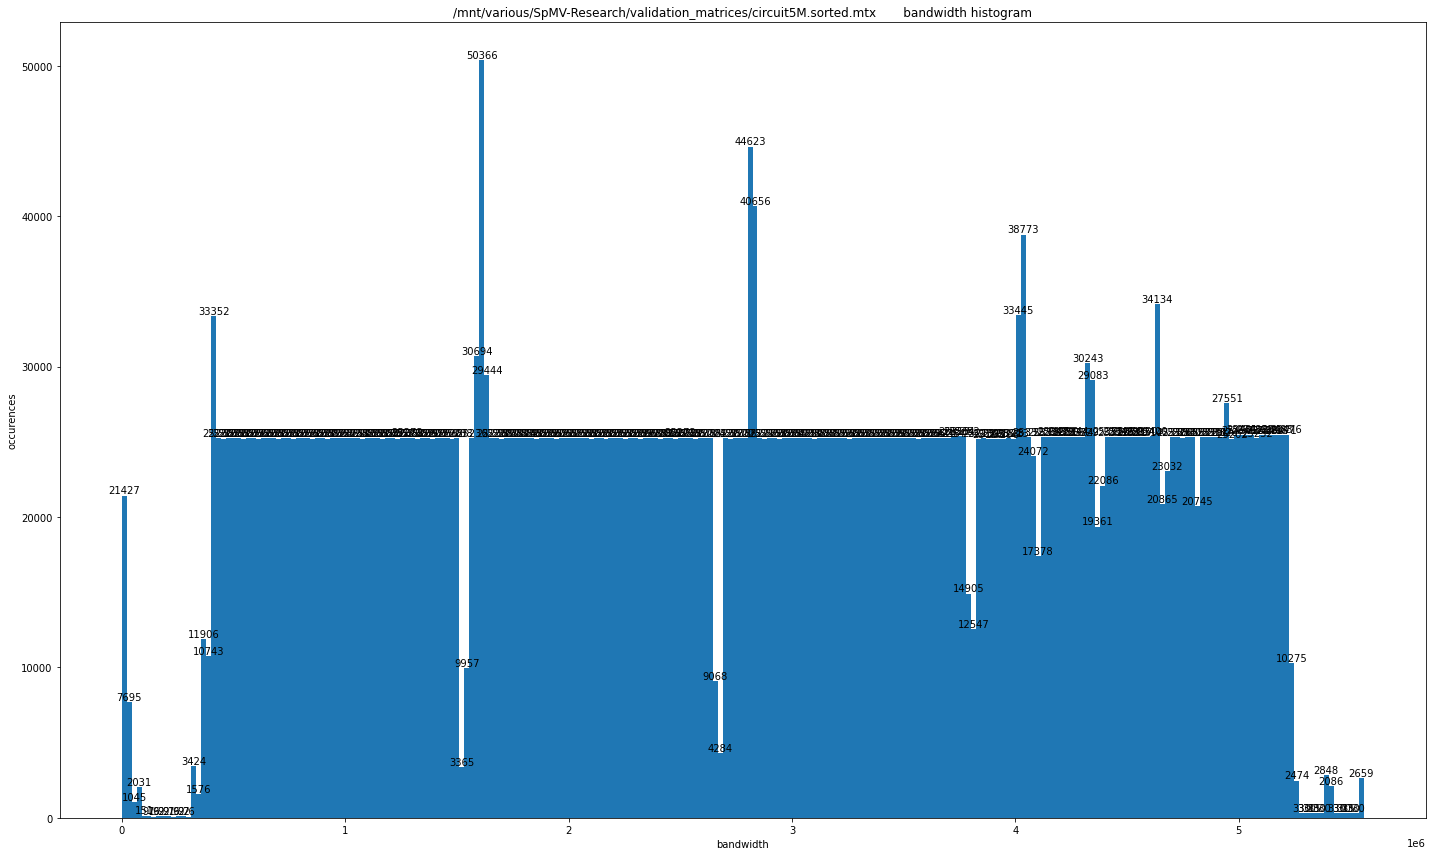

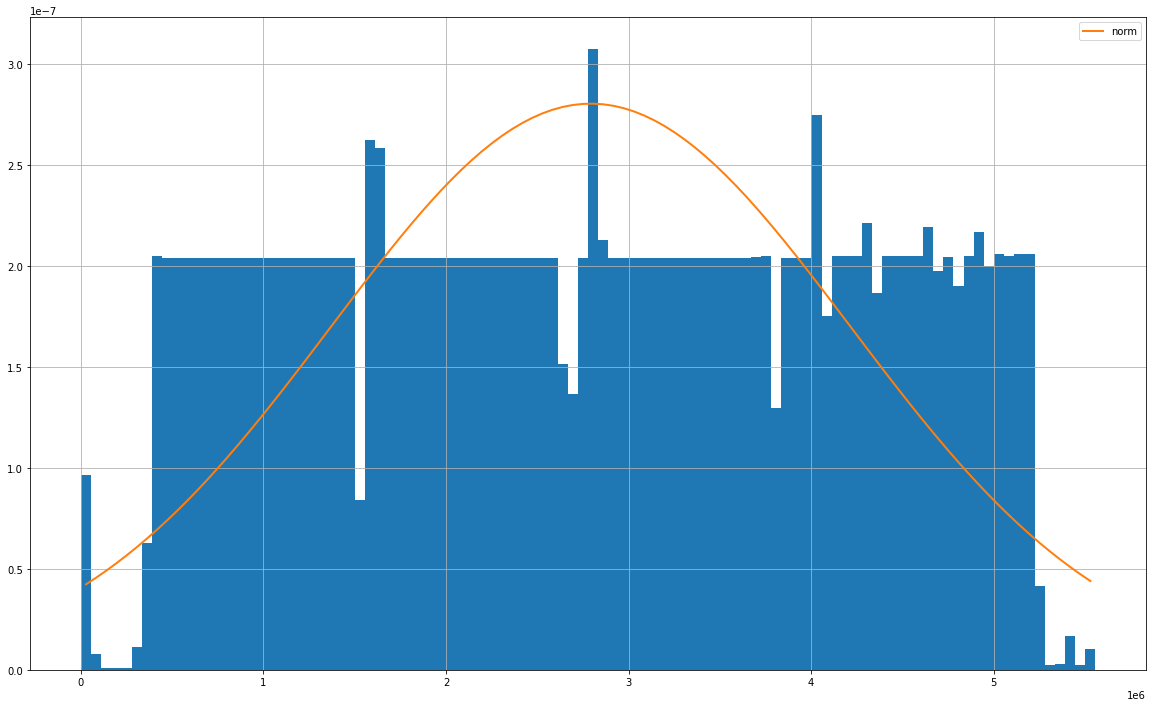

{'norm': {'loc': 2793149.8803168437, 'scale': 1421933.857605854}}
------
cage15.sorted.mtx :	dimensions (5154859, 5154859) / nnz 99199551 / mem footprint 1154.913 MB (CSR)
nnz_per_row ready
bandwidth2  ready
BADD 46
nnz-row : min = 3 max = 47 nr_bins = 46


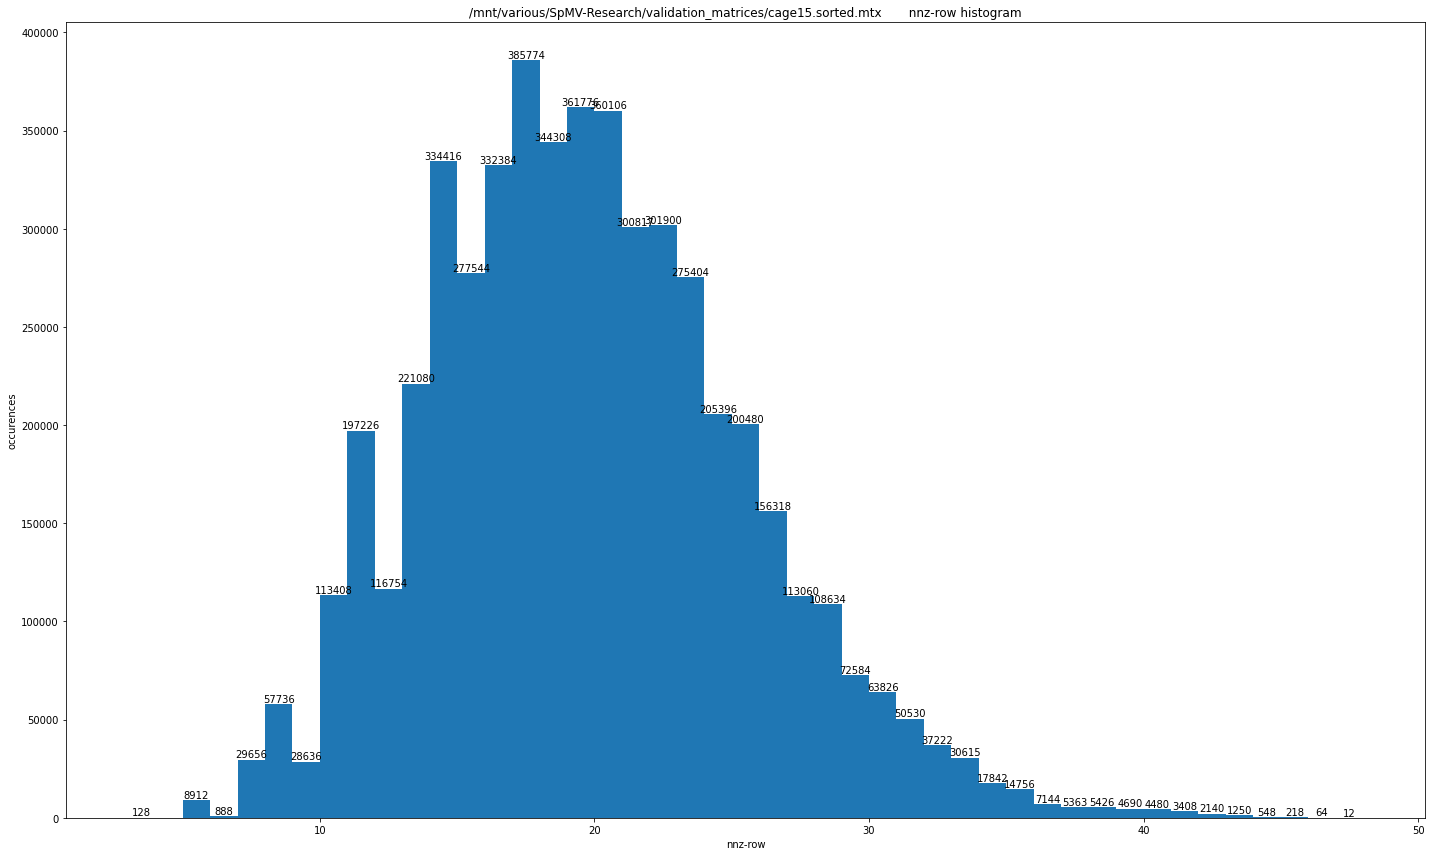

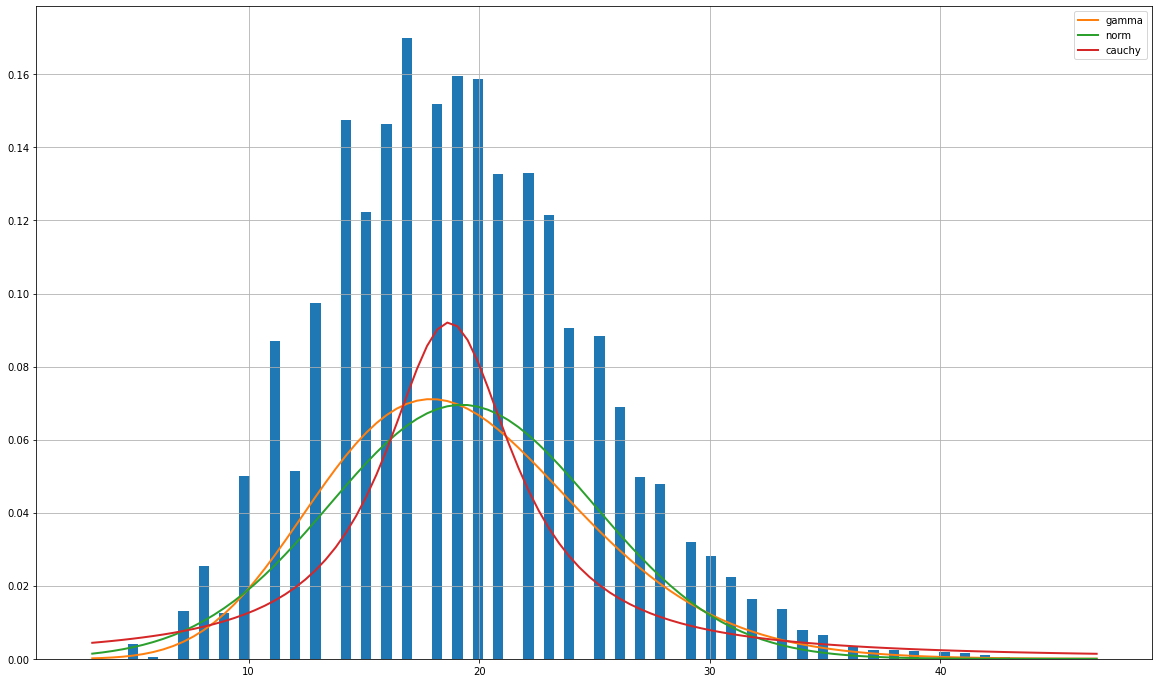

{'gamma': {'a': 18.83293529310129, 'loc': -5.660121770191361, 'scale': 1.3223649902672001}}
GOOD 251
bandwidth : min = 1844 max = 3460749 nr_bins = 251


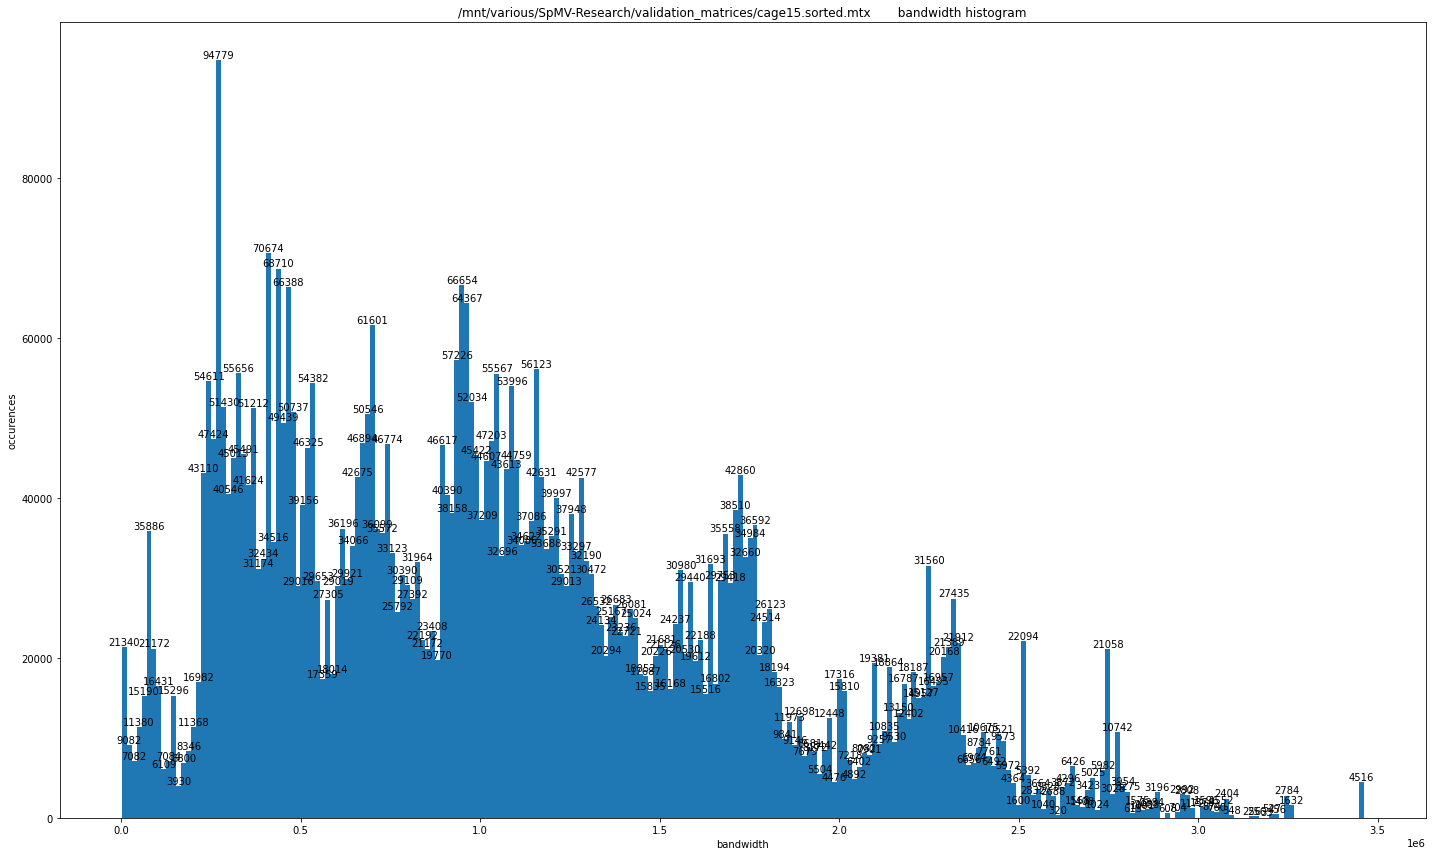

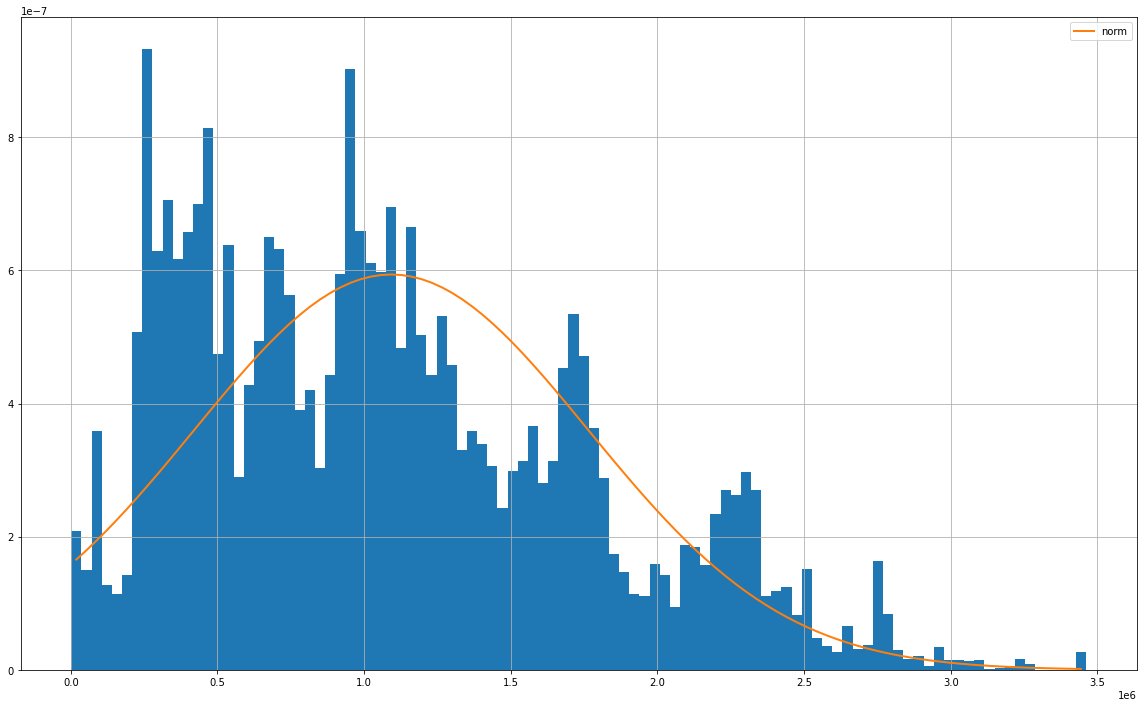

{'norm': {'loc': 1092607.234342588, 'scale': 671828.3300775691}}


In [7]:
filenames = [
    "/mnt/various/SpMV-Research/validation_matrices/cop20k_A.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/scircuit.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/mac_econ_fwd500.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/mc2depi.real.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/raefsky3.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/bbmat.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/pdb1HYS.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/conf5_4-8x8-15.real.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/cant.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/rma10.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/mip1.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/webbase-1M.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/consph.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/shipsec1.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/TSOPF_RS_b300_c3.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/crankseg_2.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/pwtk.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/rail4284.real.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/Chebyshev4.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/in-2004.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/Si41Ge41H72.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/PR02R.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/eu-2005.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/wikipedia-20051105.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/Ga41As41H72.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/TSOPF_RS_b2383.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/rajat31.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/ldoor.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/bone010.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/circuit5M.sorted.mtx",
    "/mnt/various/SpMV-Research/validation_matrices/cage15.sorted.mtx",
]

for filename in filenames:
    print("------")
    nnzr_hist, nnzr_bin_edges_r, bw_hist, bw_bin_edges_r = mmread_fun2(filename, plot_it = True)

---
# RCM (Reverse Cuthill-McKee) reordering

In [ ]:
filenames = [
    "/mnt/various/athena_ppopp_matrices/filtered/Ronis/xenon2.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/PARSEC/Si41Ge41H72.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Dziekonski/dielFilterV3real.mtx",

    "/mnt/various/athena_ppopp_matrices/filtered/Botonakis/thermomech_dK.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Gleich/wikipedia-20051105.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/SNAP/soc-LiveJournal1.mtx",

    "/mnt/various/athena_ppopp_matrices/filtered/Sandia/ASIC_680k.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Freescale/circuit5M.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/LAW/in-2004.mtx",

    "/mnt/various/exafoam_matrices/100K.mtx",
    "/mnt/various/exafoam_matrices/600K.mtx"]

plot_it = True

stats_list = []
plot_it = True
for filename in filenames:
    line = stats_extraction(filename, plot_it)
    stats_list.append(line)

file = open("targeted_matrices_features.txt","w")
for line in stats_list:
    file.write(line+"\n")
file.close()

In [ ]:
filenames=[
    "/mnt/various/athena_ppopp_matrices/filtered/Ronis/xenon2_rcm.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/PARSEC/Si41Ge41H72_rcm.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Dziekonski/dielFilterV3real_rcm.mtx",
    
    "/mnt/various/athena_ppopp_matrices/filtered/Botonakis/thermomech_dK_rcm.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Gleich/wikipedia-20051105_rcm.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/SNAP/soc-LiveJournal1_rcm.mtx",
    
    "/mnt/various/athena_ppopp_matrices/filtered/Sandia/ASIC_680k_rcm.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/LAW/in-2004_rcm.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Freescale/circuit5M_rcm.mtx",
    
    "/mnt/various/exafoam_matrices/100K_rcm.mtx",
    "/mnt/various/exafoam_matrices/600K_rcm.mtx"]

plot_it = True

stats_list = []
plot_it = True
for filename in filenames:
    line = stats_extraction(filename, plot_it)
    stats_list.append(line)

file = open("targeted_matrices_rcm_features.txt","w")
for line in stats_list:
    file.write(line+"\n")
file.close()

---
# dgal partitioning

In [ ]:
# dgal partitioning
filenames=[
    "/mnt/various/athena_ppopp_matrices/filtered/Freescale/circuit5M_sorted_1.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Freescale/circuit5M_sorted_2.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Freescale/circuit5M_sorted_3.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Freescale/circuit5M_sorted_4.mtx",

    "/mnt/various/athena_ppopp_matrices/filtered/Dziekonski/dielFilterV3real_sorted_1.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Dziekonski/dielFilterV3real_sorted_2.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Dziekonski/dielFilterV3real_sorted_3.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Dziekonski/dielFilterV3real_sorted_4.mtx",

    "/mnt/various/athena_ppopp_matrices/filtered/SNAP/soc-LiveJournal1_sorted_1.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/SNAP/soc-LiveJournal1_sorted_2.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/SNAP/soc-LiveJournal1_sorted_3.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/SNAP/soc-LiveJournal1_sorted_4.mtx",

    "/mnt/various/athena_ppopp_matrices/filtered/Gleich/wikipedia-20051105_sorted_1.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Gleich/wikipedia-20051105_sorted_2.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Gleich/wikipedia-20051105_sorted_3.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/Gleich/wikipedia-20051105_sorted_4.mtx"
]

plot_it = True

stats_list = []
plot_it = True
for filename in filenames:
    line = stats_extraction(filename, plot_it)
    stats_list.append(line)

file = open("targeted_large_matrices_dgal_partitioning.txt","w")
for line in stats_list:
    file.write(line+"\n")
file.close()

In [ ]:
# dgal partitioning
filenames=[
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_gamma_distribution_soc-LiveJournal1_sorted_4_3953914_3953914_16582299_random_seed_10.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_gamma_distribution_soc-LiveJournal1_sorted_4_3953914_3953914_16582299_diagonal_df0.5_seed_10.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_gamma_distribution_soc-LiveJournal1_sorted_4_3953914_3953914_16582299_diagonal_df0.05_seed_10.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_gamma_distribution_soc-LiveJournal1_sorted_4_3953914_3953914_16582299_diagonal_df0.005_seed_10.mtx",    
    
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_normal_distribution_dielFilterV3real_sorted_4_636608_636608_19688400_random_seed_29.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_normal_distribution_dielFilterV3real_sorted_4_636608_636608_19688400_diagonal_df0.5_seed_29.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_normal_distribution_dielFilterV3real_sorted_4_636608_636608_19688400_diagonal_df0.05_seed_29.mtx",
    "/mnt/various/athena_ppopp_matrices/filtered/dgal_partitioning/artificial_normal_distribution_dielFilterV3real_sorted_4_636608_636608_19688400_diagonal_df0.005_seed_29.mtx",
]

stats_list = []
plot_it = False
for filename in filenames:
    line = stats_extraction(filename, plot_it)
    stats_list.append(line)

file = open("targeted_large_matrices_dgal_partitioning_artificial_digital_twins.txt","w")
for line in stats_list:
    file.write(line+"\n")
file.close()